<a href="https://colab.research.google.com/github/ProtossDragoon/paper_implementation_and_testing_tf2/blob/main/notebooks/sm_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training / Testing with Segmentation Models

## Author

name : Janghoo Lee <br>
github : https://github.com/ProtossDragoon <br>
contact : dlwkdgn1@naver.com <br>
circle : https://github.com/sju-coml <br>
organization : https://web.deering.co/ <br>
published date : May, 2021

## ThridParty

- github : https://github.com/qubvel/segmentation_models <br>
- github : https://github.com/albumentations-team/albumentations

## Related Notebook

[Notebooks](https://github.com/ProtossDragoon/paper_implementation_and_testing_tf2/tree/main/notebooks)


# Environment

## Import

In [15]:
import tensorflow as tf
print(tf.__version__)
!pip install tensorboard
!pip install tensorboard-plugin-profile
%load_ext tensorboard

2.7.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
import math
from tqdm.notebook import tqdm as tqdm

## Show HW Spec and Setup HW

### COLAB CPU

In [17]:
!cat /proc/cpuinfo
TRAINING_PARALLEL_STRATEGY = None

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

### GPU/TPU Setup

TPU를 사용하는 경우, 모든 입력 파일과 모델 디렉터리는 Cloud Storage 버킷 경로(gs://bucket-name/...)를 사용해야 하며 이 버킷은 TPU 서버에서 액세스할 수 있어야 합니다. 모든 데이터 처리 및 모델 체크포인트는 로컬 머신이 아닌 TPU 서버에서 수행됩니다. TPU에서 사용하기 위해 Cloud Storage를 적절하게 구성하는 방법은 Cloud Storage 버킷에 연결 가이드를 참조하세요.

In [18]:
if 'COLAB_TPU_ADDR' in os.environ: # Check TPU
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU.'
    print('\n\n[Info]: 1. tf.keras model.Model subclassing API is unstable for TPU.')
    print('[Info]: 2. TPU training required GCP and GCS bucket.')
    print('[Info]: 3. TPU training input pipeline does not support tf.keras data loader, tf.data + TFRecord instead.')
    print('[Info]: 4. TPU training should not have py_function in data loader. TensorFlow native only.\n\n')

    tf_master = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
    TPU_ADDRESS = tf_master
            
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
    tf.config.experimental_connect_to_cluster(resolver) # initialize the colab tpu
    tf.tpu.experimental.initialize_tpu_system(resolver) # https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/keras_mnist_tpu.ipynb?hl=ko&authuser=2#scrollTo=Hd5zB1G7Y9-7

    TRAINING_PARALLEL_STRATEGY = tf.distribute.TPUStrategy(resolver) # Choose distribution strategy for parallel processing.
    tpus = tf.config.list_logical_devices('TPU')
    print(f'total {len(tpus)} of TPU devices: {tpus}')

    USE_TPU = True
    USE_GPU = False
else: # GPU or CPU Only
    USE_TPU = False
    print('TPU Not found')
    TRAINING_PARALLEL_STRATEGY = None
    device_name = tf.test.gpu_device_name()
    if not device_name:
        USE_GPU = False
        print('GPU device not found.')
    else:
        USE_GPU = True
        !nvidia-smi -L
        gpus = tf.config.list_logical_devices('GPU')
        print(f'total {len(gpus)} GPU devices: {gpus}')

TPU Not found
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-310bc034-cd81-3852-8e19-3289237a099c)
total 1 GPU devices: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


### HW usage monitoring tool

In [19]:
"""
if not USE_TPU:
    %cd /content/
    !pip install wandb -q
    import wandb
    wandb.init()
    # clik link below
"""

'\nif not USE_TPU:\n    %cd /content/\n    !pip install wandb -q\n    import wandb\n    wandb.init()\n    # clik link below\n'

## Global Hyper Parameters

In [20]:
USE_GCS = False

HOME_DIR = "/content/gdrive/MyDrive"
WS = os.path.join(HOME_DIR, "ColabWorkspace")
DATA_DIR = os.path.join(HOME_DIR, 'data')
DATA_VIDEO_DIR = os.path.join(DATA_DIR, 'video')
DATA_INDEXFILE_DIR = os.path.join(DATA_DIR, 'index')
DATA_TFRECORD_DIR = os.path.join(DATA_DIR, 'tfrecord')

GIT_REPO_NAME = 'paper_implementation_and_testing_tf2'
GIT_WS = os.path.join(WS, GIT_REPO_NAME)

GIT_REPO_THIRDPARTY_NAME = 'segmentation_models'
GIT_WS_THIRDPARTY = os.path.join(WS, GIT_REPO_THIRDPARTY_NAME)
GIT_REPO_THIRDPARTY_NAME_2 = 'efficientnet'
GIT_WS_THIRDPARTY_2 = os.path.join(WS, GIT_REPO_THIRDPARTY_NAME_2)
GIT_REPO_THIRDPARTY_NAME_3 = 'albumentations'
GIT_WS_THIRDPARTY_3 = os.path.join(WS, GIT_REPO_THIRDPARTY_NAME_3)

LOG_DIR = os.path.join(GIT_WS, 'tboard')
MODEL_PLOT_DIR = os.path.join(GIT_WS, 'plotmodel')
WEIGHTS_DIR = os.path.join(GIT_WS, 'weights')
BACKUP_DIR = os.path.join(GIT_WS, 'temp', 'modelbackup')
MODELS_DIR = os.path.join(GIT_WS, 'models')

In [21]:
GIT_BRANCH = 'main'
GIT_USERNAME = None # Add here
GIT_EMAIL = None

## Google Drive / Git

In [22]:
#!rm -r /content/gdrive/
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
!mkdir -p {WS}
%cd {WS}
!git clone https://github.com/ProtossDragoon/{GIT_REPO_NAME}.git
%cd {GIT_WS}
!git config --global user.name {GIT_USERNAME}
!git config --global user.email {GIT_EMAIL}
!git pull origin {GIT_BRANCH}

%ls
print(GIT_WS_THIRDPARTY, GIT_WS_THIRDPARTY_2, GIT_WS_THIRDPARTY_3)
%cd {WS}

# segmentation_models
#!rm -r {GIT_REPO_THIRDPARTY_NAME}
!git clone https://github.com/qubvel/{GIT_REPO_THIRDPARTY_NAME}.git
!pip install {GIT_REPO_THIRDPARTY_NAME}

# efficientnet
#!rm -r {GIT_REPO_THIRDPARTY_NAME_2}
!git clone https://github.com/qubvel/{GIT_REPO_THIRDPARTY_NAME_2}.git
!pip install {GIT_REPO_THIRDPARTY_NAME_2}

# albumentations
#!rm -r {GIT_REPO_THIRDPARTY_NAME_3}
!git clone https://github.com/albumentations-team/{GIT_REPO_THIRDPARTY_NAME_3}.git
!pip install {GIT_REPO_THIRDPARTY_NAME_3}
!ls -al

!mkdir -p {MODEL_PLOT_DIR}
!mkdir -p {WEIGHTS_DIR}
!mkdir -p {BACKUP_DIR}
!mkdir -p {MODELS_DIR}

/content/gdrive/MyDrive/ColabWorkspace
fatal: destination path 'paper_implementation_and_testing_tf2' already exists and is not an empty directory.
/content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2
From https://github.com/ProtossDragoon/paper_implementation_and_testing_tf2
 * branch            main       -> FETCH_HEAD
Already up to date.
albumentations/  models/     plotmodel/        tboard/     utils/
DIRGUIDE.md      modules/    README.md         temp/       weights/
docs/            notebooks/  requirements.txt  trtmodels/
/content/gdrive/MyDrive/ColabWorkspace/segmentation_models /content/gdrive/MyDrive/ColabWorkspace/efficientnet /content/gdrive/MyDrive/ColabWorkspace/albumentations
/content/gdrive/MyDrive/ColabWorkspace
fatal: destination path 'segmentation_models' already exists and is not an empty directory.
fatal: destination path 'efficientnet' already exists and is not an empty directory.
fatal: destination path 'albumentations' already exists and i

total 24
drwx------ 10 root root 4096 Nov  3 09:04 albumentations
drwx------ 10 root root 4096 Nov 18 06:30 efficientnet
drwx------  2 root root 4096 Jun 25 04:43 .ipynb_checkpoints
drwx------ 15 root root 4096 May 25 05:07 paper_implementation_and_testing_tf2
drwx------  9 root root 4096 Jun 22 02:12 segmentation_models
drwx------  2 root root 4096 Nov 16 09:47 sknw


## Setup SM Lib

In [24]:
%cd {GIT_WS_THIRDPARTY}
%cd {GIT_WS_THIRDPARTY_2}
# way1
%set_env PYTHONPATH={'/env/python'+':'+GIT_WS_THIRDPARTY+':'+GIT_WS_THIRDPARTY_2}
!pip list
# 등록까지 약간의 시간이 소요됨. ModuleNotFoundError: No module named 'segmentation_models'
# 강제 등록
for path in [GIT_WS_THIRDPARTY, GIT_WS_THIRDPARTY_2]: #way2
    if path not in sys.path:
        sys.path.append(path)
print(sys.path)

/content/gdrive/MyDrive/ColabWorkspace/segmentation_models
/content/gdrive/MyDrive/ColabWorkspace/efficientnet
env: PYTHONPATH=/env/python:/content/gdrive/MyDrive/ColabWorkspace/segmentation_models:/content/gdrive/MyDrive/ColabWorkspace/efficientnet
Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                1.1.0
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4 

In [25]:
!pip install keras_applications>=1.0.7
!pip install image-classifiers==1.0.0
import segmentation_models as sm
sm.set_framework('tf.keras')

## Setup albumentations

In [26]:
PYTHONPATH = !echo $PYTHONPATH
PYTHONPATH = PYTHONPATH[0].strip('[').strip(']')
print(PYTHONPATH)

/env/python:/content/gdrive/MyDrive/ColabWorkspace/segmentation_models:/content/gdrive/MyDrive/ColabWorkspace/efficientnet


In [27]:
# remove internal albumentations
!rm -r /usr/local/lib/python3.7/dist-packages/albumentations
!rm -r /usr/local/lib/python3.7/dist-packages/albumentations*
%set_env PYTHONPATH={PYTHONPATH+':'+GIT_WS_THIRDPARTY_3} #way1
for path in [GIT_WS_THIRDPARTY_3]: #way2
    if path not in sys.path:
        sys.path.append(path)
print(sys.path)

env: PYTHONPATH=/env/python:/content/gdrive/MyDrive/ColabWorkspace/segmentation_models:/content/gdrive/MyDrive/ColabWorkspace/efficientnet:/content/gdrive/MyDrive/ColabWorkspace/albumentations #way1
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/gdrive/MyDrive/ColabWorkspace/segmentation_models', '/content/gdrive/MyDrive/ColabWorkspace/efficientnet', '/content/gdrive/MyDrive/ColabWorkspace/albumentations']


In [28]:
try:
    import albumentations as A
except ModuleNotFoundError as e:
    raise ModuleNotFoundError(f'{e} 에러가 발생했습니다. 런타임 재시작시 이 문제가 해결될 가능성이 높습니다.')

print(A.__version__)
assert float('.'.join(str(A.__version__).split('.')[:-1])) >= 1.0, f'런타임을 재시작해 주세요. {A.__version__} >= 1.0 이어야 합니다.'

1.1.0


## [Additional] GCP

- Only run for GCP. Not for Vanilla google drive user.
- *구글 클라우드 문서에 따르면, TPU 를 사용하는 경우 GCS 를 반드시 사용해야 한다고 명시되어 있음.


### [Choice] Authenticate GCP User

If you use TPU, this cell must be run.

In [ ]:
USE_GCS = True

GCP_BUCKET_NAME = "deer-newdolph" #@param {type:"string"}
GCP_PROJECT_NAME = "newdolph" #@param {type:"string"}
GCP_PROJECT_ID = "flowing-digit-326103" #@param {type:"string"}
GCP_REGION = 'us-central1'

IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
    if "google.colab" in sys.modules:
        from google.colab import auth
        auth.authenticate_user()
        os.environ["GOOGLE_CLOUD_PROJECT"] = GCP_PROJECT_ID
# !gcloud config set project {GCP_PROJECT_ID}

### Global Hyper Parameters

Re-define hyper parameters we defined before.

In [ ]:
HOME_DIR = os.path.join('gs://', GCP_BUCKET_NAME)

WS = os.path.join(HOME_DIR, "ColabWorkspace")
DATA_DIR = os.path.join(HOME_DIR, 'data')
DATA_INDEXFILE_DIR = os.path.join(DATA_DIR, 'index')
DATA_TFRECORD_DIR = os.path.join(DATA_DIR, 'tfrecord')

GIT_WS = os.path.join(WS, GIT_REPO_NAME)
LOG_DIR = os.path.join(GIT_WS, 'tboard')
MODEL_PLOT_DIR = os.path.join(GIT_WS, 'plotmodel')
WEIGHTS_DIR  = os.path.join(GIT_WS, 'weights')
BACKUP_DIR = os.path.join(GIT_WS, 'temp', 'modelbackup')
MODELS_DIR = os.path.join(GIT_WS, 'models')

print('Generate : {}'.format(DATA_INDEXFILE_DIR))
tf.io.gfile.makedirs(DATA_INDEXFILE_DIR)

print('Generate : {}'.format(DATA_TFRECORD_DIR))
tf.io.gfile.makedirs(DATA_TFRECORD_DIR)

print('Generate : {}'.format(LOG_DIR))
tf.io.gfile.makedirs(LOG_DIR)

print('Generate : {}'.format(MODEL_PLOT_DIR))
tf.io.gfile.makedirs(MODEL_PLOT_DIR)

print('Generate : {}'.format(WEIGHTS_DIR))
tf.io.gfile.makedirs(WEIGHTS_DIR)

print('Generate : {}'.format(BACKUP_DIR))
tf.io.gfile.makedirs(BACKUP_DIR)

print('Generate : {}'.format(MODELS_DIR))
tf.io.gfile.makedirs(MODELS_DIR)

Generate : gs://deer-newdolph/data/index
Generate : gs://deer-newdolph/data/tfrecord
Generate : gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/tboard
Generate : gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/plotmodel
Generate : gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/weights
Generate : gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/temp/modelbackup
Generate : gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/models


# Common

## Utils

### Memory Size calc func

In [29]:
def keras_model_memory_usage_in_bytes(model, batch_size: int):
    """
    Return the estimated memory usage of a given Keras model in bytes.
    This includes the model weights and layers, but excludes the dataset.

    The model shapes are multipled by the batch size, but the weights are not.

    Args:
        model: A Keras model.
        batch_size: The batch size you intend to run the model with. If you
            have already specified the batch size in the model itself, then
            pass `1` as the argument here.
    Returns:
        An estimate of the Keras model's memory usage in bytes.

    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights]
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory

### Dataset utils

#### Dataset Baseclass

- 데이터세트 베이스 클래스는 데이터셋 그 자체입니다.
- 로더가 아니기 때문에, 에폭과 배치 사이즈를 결정하는 기능 등이 내장되어 있지 않습니다.
- 이 Segmentation 에 특화된 데이터세트 베이스클래스는 tf.keras.Sequence 와 tf.data.Dataset 를 모두 지원하도록 설계되었습니다.
- 이 추상클래스를 각각 데이터셋에 맞추어 상속받고, 이미지와 마스크 리스트를 채워 주면 끝납니다.
- tf.data.Dataset 을 활용하고 싶을 경우 아래 사항을 추가로 따르십세요.
  1. 상속받은 클래스를 한번 더 상속받고 아래의 기능에 준하는 기능을 구현하세요.
    - `self.images_dataset` 과 `self.masks_dataset` 에 데이터셋 객체를 채워 주세요.
    - `self.images_dataset = tf.data.Dataset.from_tensor_slices(self.images_fps)`
    - `self.masks_dataset = tf.data.Dataset.from_tensor_slices(self.masks_fps)`
  2. 앞으로 사용할 모드를 설정하기 위해, `SegmentationDataset.mode = 'tf.data.Dataset'` 으로 변경합니다.
  3. 두 번 상속받은 개체를 사용하기 전 `SegmentationDataset.get_tf_dataset()` 을 호출하세요.
  4. 리턴된 객체는 이터러블입니다. `iter()` 에 넣어 이터레이터(반복자) 객체를 얻은 뒤 `next()` 로 값을 디버깅해 볼 수 있습니다.


In [30]:
# classes for data loading and preprocessing
import abc
class SegmentationDataset(abc.ABC):
    """Segmentation Dataset. Read images, apply augmentation and preprocessing transformations.
       Inheritance this class and implement method.
       - self.images_fps and self.masks_fps should be filled.
       - If you have RGB colorized masks, put {(int)classid: <tuple>(r,g,b)} shaped dictionary at self.class_id_to_rgb_li_dict.
       
       
       Args:
            interested_class_ids (list): values of classes ids       
            augmentation (albumentations.Compose): data transfromation pipeline 
                (e.g. flip, scale, etc.)
            preprocessing (albumentations.Compose): data preprocessing 
                (e.g. noralization, shape manipulation, etc.)
    """
    
    def __init__(self, interested_class_ids=None, augmentation=None, preprocessing=None, resizing=None):

        # self.images_fps = user implementation 
        # self.masks_fps = user implementation        
        # self.class_id_to_rgb_li_dict = user implementation

        self.interested_class_ids = interested_class_ids
        self.interested_class_id_to_rgb_li_dict = None

        # func*
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.resizing = resizing

        print('augmentation : {} -> {}'.format(type(augmentation), type(self.augmentation)))
        print('preprocessing : {} -> {}'.format(type(preprocessing), type(self.preprocessing)))
        print('resizing : {} -> {}'.format(type(resizing), type(self.resizing)))

        # mode
        self.mode = 'tf.keras.Sequence' # or tf.data.Dataset


    @abc.abstractmethod
    def __len__(self):
        pass


    #########################
    # Preprocessing family
    #########################

    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8), 
                                  tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8),))    
    def _get_elsebranch_preprocessing(self, image, mask):
        print('_get_elsebranch_preprocessing: Tracing (no preprocessing)')
        image = tf.cast(image, tf.float32)
        mask = tf.cast(mask, tf.float32)
        return image, mask


    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8), 
                                  tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8),))
    def _preprocessing_fn(self, image, mask):
        image = tf.cast(image, tf.float32)
        image, mask = tf.numpy_function(func=self.preprocessing, inp=[image, mask], Tout=[tf.float32, tf.float32])

        #debugging code
        #tf.print('preprocessing_fn / <image> val :', tf.math.reduce_min(image), '~', tf.math.reduce_max(image))
        #tf.print('preprocessing_fn / <image> tensorspec :', tf.TensorSpec.from_tensor(image))
        
        #categorical crossentropy loss function etc... wants float tensor, not uint8 tensor.
        image = tf.cast(image, tf.float32)
        mask = tf.cast(mask, tf.float32)
        
        return image, mask


    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8), 
                                  tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8),))
    def _preprocessing_pure_fn(self, image, mask):
        print('_preprocessing_pure_fn: Tracing!')
        image, mask = self.preprocessing(image, mask) 
        # NOTE: view self._get_elsebranch_preprocessing
        image = tf.cast(image, tf.float32)
        mask = tf.cast(mask, tf.float32)
        return image, mask


    #########################
    # Resizing family
    #########################

    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8), 
                                  tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8),))
    def _get_elsebranch_resizing(self, image, mask):
        print('_get_elsebranch_resizing: Tracing (no resizing)')
        image = tf.cast(image, tf.uint8)
        mask = tf.cast(mask, tf.uint8)
        return image, mask


    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8), 
                                  tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8),))    
    def _resizing_fn(self, image, mask):
        print('_resizing_fn: Tracing!')
        image, mask = tf.py_function(func=self.resizing, inp=[image, mask], Tout=[tf.float32, tf.uint8])
        # NOTE: view self._get_elsebranch_resizing
        image = tf.cast(image, tf.uint8)
        mask = tf.cast(mask, tf.uint8)

        #debugging code
        #tf.print('resizing_fn / <image> val :', tf.math.reduce_min(image), '~', tf.math.reduce_max(image))
        #tf.print('resizing_fn / <image> tensorspec :', tf.TensorSpec.from_tensor(image))

        return image, mask


    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8), 
                                  tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8),))
    def _resizing_pure_fn(self, image, mask):
        print('_resizing_pure_fn: Tracing!')
        image, mask = self.resizing(image, mask)
        # NOTE: view self._get_elsebranch_resizing
        image = tf.cast(image, tf.uint8)
        mask = tf.cast(mask, tf.uint8)

        #debugging code
        #tf.print('_resizing_pure_fn / <image> val :', tf.math.reduce_min(image), '~', tf.math.reduce_max(image))
        #tf.print('_resizing_pure_fn / <image> tensorspec :', tf.TensorSpec.from_tensor(image))

        return image, mask


    #########################
    # augmentation family
    #########################

    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8), 
                                  tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8),))
    def _get_elsebranch_augmentation(self, image, mask):
        print('_get_elsebranch_augmentation: Tracing (no augmetnation)')
        return image, mask


    def _augmentation_py(self, image, mask):
        ret = self.augmentation(image=image, mask=mask) # albumentation pipeline.
        image = ret['image']
        mask = ret['mask']
        return image, mask


    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8), 
                                  tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8),
                                  tf.TensorSpec(shape=[], dtype=tf.bool),))
    def _augmentation_fn(self, image, mask, augmentation_exist):
        # <image> : tf.uint8
        # <mask> : tf.uint8
        print('_augmentation_fn: Tracing!')
        if augmentation_exist: # branch type : <image> tf.uint8 -> tf.uint8, <mask> tf.uint8 -> tf.uint8
            image, mask = tf.numpy_function(func=self._augmentation_py, inp=[image, mask], Tout=[tf.uint8, tf.uint8])
            image = tf.cast(image, tf.uint8)
            mask = tf.cast(mask, tf.uint8)
        else:
            # NOTE: view self._get_elsebranch_augmentation
            pass

        return image, mask


    #########################
    # mask parsing family
    #########################

    def _parse_mask_py(self, mask, class_id_to_rgb_li_dict=None):

        if mask.shape[-1] == 1:
            mask = np.squeeze(mask)

        # If overrided class implemented self.class_id_to_rgb_li_dict
        if hasattr(self, 'class_id_to_rgb_li_dict') and (class_id_to_rgb_li_dict is None):
            class_id_to_rgb_li_dict = self.class_id_to_rgb_li_dict

        if class_id_to_rgb_li_dict is None:
            masks = [(mask == v) for v in self.interested_class_ids]
        else:
            self.interested_class_id_to_rgb_li_dict = {}
            for k, v in class_id_to_rgb_li_dict.items():
                if k in self.interested_class_ids:
                    self.interested_class_id_to_rgb_li_dict[k] = v

            masks = []
            for class_id, colors in self.interested_class_id_to_rgb_li_dict.items():
                if len(np.array(colors).shape) == 2:
                    # e.g. one class has two color {2: [(255, 128, 0), (255, 64, 0)]}
                    # e.g. one class has one color with single element {2: [(255, 128, 0)]}
                    temp_mask = []
                    for color in np.array(colors):
                        temp_mask.append(np.all(mask == color, axis=-1))    
                    masks.append(np.logical_or.reduce(temp_mask))
                else:
                    # e.g. one class has one color without list wrapping {2: (255, 128, 0)}
                    masks.append(np.all(mask == colors, axis=-1))

        mask = np.stack(masks, axis=-1).astype('int')

        ## debug
        # print('mask max : {}, min : {}, type : {}'.format(mask.max(), mask.min(), mask.dtype)) ## debug

        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        ## debug
        # print('mask max : {}, min : {}, type : {}'.format(mask.max(), mask.min(), mask.dtype)) ## debug

        return mask.astype('float')


    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8), 
                                  tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8),))
    def _parse_mask_fn(self, image, mask):
        print('_parse_mask_fn: Tracing!')
        mask = tf.py_function(func=self._parse_mask_py, inp=[mask], Tout=tf.uint8)
        return image, mask


    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, 3], dtype=tf.uint8), 
                                  tf.TensorSpec(shape=[None, None, 1], dtype=tf.uint8),
                                  tf.TensorSpec(shape=[None], dtype=tf.uint8), # e.g. [1, 5, 13, 21, ...]
                                  ))
    def _parse_classid_mask_pure_fn(self, image, 
                                    mask, 
                                    interested_class_ids,
                                    ):
        print('_parse_classid_mask_pure_fn: Tracing')

        h = tf.shape(mask)[0]
        w = tf.shape(mask)[1]
        #c = tf.shape(mask)[2]

        #temp_mask = tf.zeros([h, w, c], dtype=tf.uint8)
        temp_mask = tf.zeros_like(mask)
        for id in interested_class_ids:
            tf.autograph.experimental.set_loop_options(
                shape_invariants=[(temp_mask, tf.TensorShape([None, None, None]))]
                )
            temp = tf.math.equal(mask, id)
            temp = tf.cast(temp, tf.uint8)
            temp_mask = tf.concat([temp_mask, temp], axis=-1) # temp_mask : [h, w, ?] temp : [h, w, 1]

        mask = temp_mask[:,:,1:] # drop first channel
        if tf.shape(mask)[-1] != 1: # mask : [h, w, 1]
            background = 1 - tf.math.reduce_sum(mask, axis=-1, keepdims=True) # background : [h, w, 1]
            background = tf.cast(background, tf.uint8)
            mask = tf.concat([mask, background], axis=-1)

        return image, mask
        

    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, 3], dtype=tf.uint8), 
                                  tf.TensorSpec(shape=[None, None, 3], dtype=tf.uint8),
                                  tf.TensorSpec(shape=[None], dtype=tf.uint8), # e.g. [1, 5, 13, 21, ...]
                                  tf.TensorSpec(shape=[], dtype=tf.int32),
                                  tf.TensorSpec(shape=[None, None, 3], dtype=tf.uint8), # n_interested_cls, colors, rgb #NOTE: don't contain background class.
                                  tf.TensorSpec(shape=[None], dtype=tf.int32),
                                  ))
    def _parse_rgb_mask_pure_fn(self, image, 
                                mask,
                                interested_class_ids=None, # shape=[None]
                                interested_class_cnt=None, # shape=[], dtype=tf.int32
                                interested_class_rgb_li=None,
                                interested_class_rgb_cnt_li=None,):
        print('_parse_rgb_mask_pure_fn: Tracing')
        
        h = tf.shape(mask)[0]
        w = tf.shape(mask)[1]
        c = tf.shape(mask)[2]

        max_num_of_colors = tf.shape(interested_class_rgb_li)[1]
        final_mask = tf.zeros([h, w, 1], dtype=tf.bool)
        for idx in tf.range(interested_class_cnt, dtype=tf.int32):
            tf.autograph.experimental.set_loop_options(
                shape_invariants=[(final_mask, tf.TensorShape([None, None, None])),]
                )
            temp_mask = tf.zeros([h, w, 1], dtype=tf.bool)
            colors = interested_class_rgb_li[idx]
            max_idx = interested_class_rgb_cnt_li[idx]
            for i in tf.range(max_idx, dtype=tf.int32):            
                tf.autograph.experimental.set_loop_options(
                    shape_invariants=[(temp_mask, tf.TensorShape([None, None, None]))]
                    )
                color = colors[i]
                temp = tf.math.equal(mask, color) # [h, w, 3]
                reduced_temp = tf.reduce_all(temp, axis=-1, keepdims=True) # [h, w, 1]
                temp_mask = tf.concat([temp_mask, reduced_temp], axis=-1) # temp_mask : [h, w, 2] temp : [h, w, 1]
                temp_mask = tf.reduce_any(temp_mask, axis=-1, keepdims=True) #  temp_mask :[h, w, 1]
            final_mask = tf.concat([final_mask, temp_mask], axis=-1) # [h, w, ?]

        final_mask = tf.cast(final_mask, tf.uint8)
        mask = final_mask[:,:,1:] # drop first channel

        if tf.shape(mask)[-1] != 1: # mask : [h, w, 1]
            background = 1 - tf.math.reduce_sum(mask, axis=-1, keepdims=True) # background : [h, w, 1]
            background = tf.cast(background, tf.uint8)
            mask = tf.concat([mask, background], axis=-1)

        return image, mask


    #########################
    # data loader family
    #########################

    @tf.function(input_signature=(tf.TensorSpec(shape=[], dtype=tf.string), 
                                  tf.TensorSpec(shape=[], dtype=tf.string),))    
    def _read_fn(self, images_fps, masks_fps):
        # <images_fps> : tf.string
        # <masks_fps> : tf.string
        print('_read_fn: Tracing!')

        # NOTE: Converting integer types to floating point types returns normalized floating point values in the range [0, 1)
        # NOTE: See more, https://www.tensorflow.org/api_docs/python/tf/image/convert_image_dtype

        image = tf.io.read_file(images_fps)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.uint8) 

        mask = tf.io.read_file(masks_fps)
        mask = tf.image.decode_png(mask, channels=0) # Select number of channel automatically.
        mask = tf.image.convert_image_dtype(mask, tf.uint8)

        #debugging code
        #tf.print('read_fn / <image> val :', tf.math.reduce_min(image), '~', tf.math.reduce_max(image))
        #tf.print('read_fn / <image> tensorspec :', tf.TensorSpec.from_tensor(image))

        return image, mask


    def get_base_dataset(self):
        raise NotImplementedError


    def _get_base_loader(self):
        return self.get_base_dataset()


    def get_tf_dataset(self):
        assert self.mode == 'tf.data.Dataset', 'Current mode : {}'.format(self.mode)
        self._class_id_to_rgb_li_dict_exist = tf.constant(True if self.class_id_to_rgb_li_dict is not None else False, dtype=tf.bool, shape=())
        self._augmentation_exist = tf.constant(True if self.augmentation is not None else False, dtype=tf.bool, shape=())
        self._resizing_exist = tf.constant(True if self.resizing is not None else False, dtype=tf.bool, shape=())
        self._preprocessing_exist = tf.constant(True if self.preprocessing is not None else False, dtype=tf.bool, shape=())

        tf.print('augmentation :', self._augmentation_exist)
        tf.print('resizing :', self._resizing_exist)
        tf.print('preprocessing :', self._preprocessing_exist)

        if not self._augmentation_exist:
            print('no augmentation')
            self.augmentation = self._get_elsebranch_augmentation
        if not self._resizing_exist:
            print('no resizing')
            self.resizing = self._get_elsebranch_resizing
        if not self._preprocessing_exist:
            print('no preprocessing')
            self.preprocessing = self._get_elsebranch_preprocessing

        n = tf.data.AUTOTUNE
        if n != tf.data.AUTOTUNE:
            print('Warning : parallel call is not AUTOTUNE. It could make pipeline slow.')
        
        if not USE_TPU:
            dataset = self._get_base_loader().map(
                lambda im, mask: self._parse_mask_fn(im, mask), num_parallel_calls=n).map( # now debugging!
                    lambda im, mask: self._augmentation_fn(im, mask, self._augmentation_exist), num_parallel_calls=n).map(
                        lambda im, mask: self._resizing_pure_fn(im, mask), num_parallel_calls=n).map( # now debugging!
                            lambda im, mask: self._preprocessing_pure_fn(im, mask), num_parallel_calls=n)
        
        else: # when you use TPU
            # 클래스가 1개라면, N_CLASSES = 1 이고, 클래스가 n개라면 N_CLASSES = n+1개이다.
            # 이때 클래스 (관심있는 클래스) 에는 background 는 포함되지 않는다.
            _interested_class_ids_tf = tf.constant(self.interested_class_ids, dtype=tf.uint8)

            if self._augmentation_exist:
                print('\n[Important] Warning : augmetation not support on TPU Yet!\nPipeline will remove augmentation automatically.')
                print('(reason : tf.numpy_function not support for tpu.)\nno augmentation.')

            if self.class_id_to_rgb_li_dict is None: # for 1 channel grayscaled mask
                kwargs = {'interested_class_ids':_interested_class_ids_tf,}
                dataset = self._get_base_loader().map(
                    lambda im, mask: self._parse_classid_mask_pure_fn(im, mask, **kwargs), num_parallel_calls=n).map(
                        #NOTE: No Augmentation! TPU Does not support third party augmentation
                        #lambda im, mask: self._augmentation_fn(im, mask, self._augmentation_exist), num_parallel_calls=n).map(
                            lambda im, mask: self._resizing_pure_fn(im, mask), num_parallel_calls=n).map(
                                lambda im, mask: self._preprocessing_pure_fn(im, mask), num_parallel_calls=n)
            else: # for 3 channel rgb colored mask
                interested_colors_li = []
                interested_colors_cnt_li = []
                for id, rgbs in self.class_id_to_rgb_li_dict.items():
                    if id in self.interested_class_ids:
                        interested_colors_li.append(rgbs)
                        interested_colors_cnt_li.append(len(rgbs))

                max_cnt = max(len(e) for e in interested_colors_li)
                _interested_class_cnt_tf = tf.constant(len(self.interested_class_ids), dtype=tf.int32)
                _interested_class_rgb_li_tf = tf.stack(
                    [tf.pad(
                        tf.constant(e, dtype=tf.uint8), 
                        [[0, max_cnt - len(e)],[0, 0],]) for e in interested_colors_li], 
                        axis=0)
                _interested_class_rgb_cnt_li_tf = tf.constant(
                    interested_colors_cnt_li, 
                    dtype=tf.int32)

                kwargs = {'interested_class_ids':_interested_class_ids_tf,
                          'interested_class_cnt':_interested_class_cnt_tf,
                          'interested_class_rgb_li':_interested_class_rgb_li_tf,
                          'interested_class_rgb_cnt_li':_interested_class_rgb_cnt_li_tf
                          }

                dataset = self._get_base_loader().map(
                    lambda im, mask: self._parse_rgb_mask_pure_fn(im, mask, **kwargs), num_parallel_calls=n).map(
                        #NOTE: No Augmentation! TPU Does not support third party augmentation
                        #lambda im, mask: self._augmentation_fn(im, mask, self._augmentation_exist), num_parallel_calls=n).map(
                            lambda im, mask: self._resizing_pure_fn(im, mask), num_parallel_calls=n).map(
                                lambda im, mask: self._preprocessing_pure_fn(im, mask), num_parallel_calls=n)

        return dataset


    def _getitem_keras(self, i):
        
        # read data
        image = tf.io.read_file(self.images_fps[i])
        image = tf.image.decode_png(image) # Select number of channel automatically.
        image = tf.image.convert_image_dtype(image, tf.uint8)
        image = tf.squeeze(image)
        image = image.numpy()
        
        mask = tf.io.read_file(self.masks_fps[i])
        mask = tf.image.decode_png(mask) # Select number of channel automatically.
        mask = tf.image.convert_image_dtype(mask, tf.uint8)
        mask = tf.squeeze(mask)
        mask = mask.numpy()

        # extract certain classes from mask (e.g. cars)
        mask = self._parse_mask_py(mask, self.class_id_to_rgb_li_dict)
                
        # apply augmentations
        if self.augmentation:
            image, mask = self._augmentation_py(image, mask)
        
        # apply final resizing
        if self.resizing:
            image_dt = image.dtype
            mask_dt = mask.dtype
            image, mask = self.resizing(image=image, mask=mask)
            image = image.numpy().astype(image_dt)
            mask = mask.numpy().astype(mask_dt)

        # apply preprocessing
        if self.preprocessing:
            image, mask = self.preprocessing(image=image, mask=mask)

        return image, mask


    def __getitem__(self, i): # batch
        if self.mode == 'tf.keras.Sequence':
            return self._getitem_keras(i)
        else:
            print('tf.data.Dataset is not a subscribable object.')
            raise NotImplementedError

#### [Default] Data Loader Baseclass (tf.keras.Sequence)

In [31]:
class DataLoader(tf.keras.utils.Sequence):

    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()


    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose tuple of lists (fixed)
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

#### [Extension] Data Loader fn (tf.data.Dataset)

In [32]:
def data_loader_tf(dataset_tf, batch_size, buffer_size=None, testing=False):
    if buffer_size is None:
        buffer_size = batch_size * 2
    if testing:
        print('Info : testing mode')
        return dataset_tf.shuffle(buffer_size=buffer_size).batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    else:
        return dataset_tf.shuffle(buffer_size=buffer_size).batch(batch_size, drop_remainder=True).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# dataset_tf.interleave(dataset_tf, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache(batch_size).shuffle(buffer_size=buffer_size).batch(batch_size).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Resizing Class

core : get_resizing

In [33]:
class Resizing():
    def __init__(self, model_input_w_for_train, model_input_h_for_train):
        self.w = model_input_w_for_train
        self.h = model_input_h_for_train


    def resizing_fn(self, image, mask):
        #print('Resizing.resizing_fn: Tracing!')
        # 이 부분은 일반적으로 tf.keras 와 같이, 반드시 tensorflow ops 를 사용할 필요가 없는 경우에 불내세요.
        # 높은 유연성을 얻는 대신 성능을 포기하는 경우 사용합니다.
        # 반드시 이 부분을 tensorflow ops 로 구성할 필요는 없습니다.
        # 이 부분을 순수한 tensorflow ops 로 구성한다고 하더라도, keras Sequential data loader 과는 tpu 사용이 어렵습니다.
        image = tf.image.resize(image, [self.h, self.w], method='bilinear', antialias=True)
        image = tf.clip_by_value(image, 0.0, 255.0)
        mask = tf.image.resize(mask, [self.h, self.w], method='nearest')
        return image, mask

    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, 3], dtype=tf.uint8), 
                                  tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8),
                                  tf.TensorSpec(shape=[], dtype=tf.int32),
                                  tf.TensorSpec(shape=[], dtype=tf.int32),))
    def resizing_pure_fn(self, image, mask, h, w):
        image = tf.image.resize(image, [h, w], method='bilinear', antialias=True)
        image = tf.clip_by_value(image, 0.0, 255.0)
        mask = tf.image.resize(mask, [h, w], method='nearest')
        return image, mask
    

def get_resizing(model_input_w_for_train, model_input_h_for_train, use_pure_fn=True):
    r = Resizing(model_input_w_for_train, model_input_h_for_train)
    if USE_TPU or use_pure_fn:
        print('get_resizing: get pure tf function. (tpu compatible mode)')
        return lambda image, mask: r.resizing_pure_fn(image, mask, 
                                                      tf.constant(r.h, dtype=tf.int32), 
                                                      tf.constant(r.w, dtype=tf.int32))
    else:
        print('get_resizing: eager mode')
        return lambda image, mask: r.resizing_fn(image, mask)

### Preprocessing Class

core : get_preprocessing

In [34]:
# 이 API 는 사용을 권장하지 않음. 단지 Albumentation 에 결합시키려면 어떻게 해야 하나 예시 정도로 사용.
class PretrainedSpecificPreprocessing(A.core.transforms_interface.DualTransform):
    def __init__(self, preprocessing_fn, always_apply=True, p=0.5):
        """
        Args:
            preprocessing_fn (callbale): data normalization function (can be specific for each pretrained neural network)
        """
        print('Warning : This Class was deprecated.')
        super(PretrainedSpecificPreprocessing, self).__init__(always_apply, p)
        self.preprocessing_fn = preprocessing_fn
    def apply(self, img, **params): # target : img
        return self.preprocessing_fn(img)
    def apply_to_mask(self, img, **params): # target : mask
        return img
    def get_transform_init_args_names(self):
        return ('preprocessing_fn',)


class Preprocessing():
    def __init__(self, served_fn):
        self.served_fn = served_fn
        if served_fn:
            print(f'served_fn ({repr(served_fn)} 이 설정되었으나, TPU 에서 사용하지 못하는 경우가 많기 때문에 우선 제거합니다. 대신 이 함수의 주석을 참고하세요.')
        """
        <제작자 주>
        이 노트북이 주력으로 사용하고 있는 segmentation model (quvbel) 은 backbone 모델에 맞는 preprocessing fn 을 함께 제공합니다.
        하지만 이것의 문제는, preprocessing_fn 이 TPU 에서 잘 동작하지 않는다는 것에 있습니다. (정확히 말하면 일부 preprocessing_fn 에 한해서요.)
        이 원인을 찾고자 노력했지만 찾지 못했고, 제가 생각하기에 가장 큰 원인은, imagenet_utils.preprocess_input 를 여러 번 함수로 감싸고 감싸서 주고받는 과정에서
        내부에서 일어나는 python 부수 효과 (https://www.tensorflow.org/guide/function?hl=ko) 일 것이라고 추측합니다.
        따라서, 이 노트북에서는 preprocess_input 의 mode='torch' 가 요구되는 모델을 사용할 수 없습니다. 이제부터는 pretrained weight 를 제공하지 않습니다.
        """
            
    def preprocessing_albumentaion_fn(self, image, mask):
        fn = A.Compose([PretrainedSpecificPreprocessing(preprocessing_fn)])
        return fn(image=image, mask=mask)['image'], mask

    def preprocessing_fn(self, image, mask):
        #print('Preprocessing.preprocessing_fn: Tracing!')
        # 이 부분은 일반적으로 tf.keras 와 같이, 반드시 tensorflow ops 를 사용할 필요가 없는 경우에 불내세요.
        # 높은 유연성을 얻는 대신 성능을 포기하는 경우 사용합니다.
        # 반드시 이 부분을 tensorflow ops 로 구성할 필요는 없습니다.
        # 이 부분을 순수한 tensorflow ops 로 구성한다고 하더라도, keras Sequential data loader 과는 tpu 사용이 어렵습니다.
        
        image = tf.cast(image, tf.float32) # casting before preprocessing
        return self.served_fn(image), mask

    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8), 
                                  tf.TensorSpec(shape=[None, None, None], dtype=tf.uint8),))
    def preprocessing_pure_fn(self, image, mask):
        print('Preprocessing.preprocessing_pure_fn: Tracing!')
        
        image = tf.cast(image, tf.float32) # casting before preprocessing

        # 앞으로는 TPU 를 사용하고자 할 때 이 방법만 제공합니다.
        image /= 127.5
        image -= 1.
        return image, mask

        # 기존에 문제를 발생시키던 부분은 이 부분입니다.
        # return self.served_fn(image), mask


from tensorflow.keras import backend

def get_preprocessing(fn, use_pure_fn=True):
    p = Preprocessing(fn)
    if USE_TPU or use_pure_fn:
        print('get_preprocessing: get pure tf function. (tpu compatible mode)')
        return lambda image, mask: p.preprocessing_pure_fn(image, mask,)
    else:
        print('get_preprocessing: eager mode')
        return lambda image, mask: p.preprocessing_fn(image, mask,)


def keras_preprocess_input(x, data_format=None, mode='caffe'):
    """Preprocesses a tensor or Numpy array encoding a batch of images."""
    print('tracing keras_preprocess_input')
    if mode not in {'caffe', 'tf', 'torch'}:
        raise ValueError('Expected mode to be one of `caffe`, `tf` or `torch`. '
                        f'Received: mode={mode}')

    if data_format is None:
        data_format = backend.image_data_format()
    elif data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Expected data_format to be one of `channels_first` or '
                        f'`channels_last`. Received: data_format={data_format}')

    if isinstance(x, np.ndarray):
        return _preprocess_numpy_input(
            x, data_format=data_format, mode=mode)
    else:
        return _preprocess_symbolic_input(
            x, data_format=data_format, mode=mode)


def _preprocess_numpy_input(x, data_format, mode):
    """Preprocesses a Numpy array encoding a batch of images.
    Args:
        x: Input array, 3D or 4D.
        data_format: Data format of the image array.
        mode: One of "caffe", "tf" or "torch".
        - caffe: will convert the images from RGB to BGR,
            then will zero-center each color channel with
            respect to the ImageNet dataset,
            without scaling.
        - tf: will scale pixels between -1 and 1,
            sample-wise.
        - torch: will scale pixels between 0 and 1 and then
            will normalize each channel with respect to the
            ImageNet dataset.
    Returns:
        Preprocessed Numpy array.
    """
    print('tracing _preprocess_numpy_input')
    if not issubclass(x.dtype.type, np.floating):
        x = x.astype(backend.floatx(), copy=False)

    if mode == 'tf':
        x /= 127.5
        x -= 1.
        return x
    elif mode == 'torch':
        x /= 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        if data_format == 'channels_first':
            # 'RGB'->'BGR'
            if x.ndim == 3:
                x = x[::-1, ...]
            else:
                x = x[:, ::-1, ...]
        else:
            # 'RGB'->'BGR'
            x = x[..., ::-1]
            mean = [103.939, 116.779, 123.68]
            std = None

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] -= mean[0]
            x[1, :, :] -= mean[1]
            x[2, :, :] -= mean[2]
            if std is not None:
                x[0, :, :] /= std[0]
                x[1, :, :] /= std[1]
                x[2, :, :] /= std[2]
        else:
            x[:, 0, :, :] -= mean[0]
            x[:, 1, :, :] -= mean[1]
            x[:, 2, :, :] -= mean[2]
            if std is not None:
                x[:, 0, :, :] /= std[0]
                x[:, 1, :, :] /= std[1]
                x[:, 2, :, :] /= std[2]
    else:
        x[..., 0] -= mean[0]
        x[..., 1] -= mean[1]
        x[..., 2] -= mean[2]
        if std is not None:
            x[..., 0] /= std[0]
            x[..., 1] /= std[1]
            x[..., 2] /= std[2]
    return x


def _preprocess_symbolic_input(x, data_format, mode):
    """Preprocesses a tensor encoding a batch of images.
    Args:
        x: Input tensor, 3D or 4D.
        data_format: Data format of the image tensor.
        mode: One of "caffe", "tf" or "torch".
        - caffe: will convert the images from RGB to BGR,
            then will zero-center each color channel with
            respect to the ImageNet dataset,
            without scaling.
        - tf: will scale pixels between -1 and 1,
            sample-wise.
        - torch: will scale pixels between 0 and 1 and then
            will normalize each channel with respect to the
            ImageNet dataset.
    Returns:
        Preprocessed tensor.
    """
    print('tracing _preprocess_symbolic_input')
    if mode == 'tf':
        print('tracing _preprocess_symbolic_input->tf')
        x /= 127.5
        x -= 1.
        return x
    elif mode == 'torch':
        print('tracing _preprocess_symbolic_input->torch')
        x /= 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        print(f'tracing _preprocess_symbolic_input->{mode}')
        if data_format == 'channels_first':
            # 'RGB'->'BGR'
            if backend.ndim(x) == 3:
                x = x[::-1, ...]
            else:
                x = x[:, ::-1, ...]
        else:
            # 'RGB'->'BGR'
            x = x[..., ::-1]
            mean = [103.939, 116.779, 123.68]
            std = None

    mean_tensor = backend.constant(-np.array(mean))

    # Zero-center by mean pixel
    if backend.dtype(x) != backend.dtype(mean_tensor):
        print(f'tracing _preprocess_symbolic_input->{mode}->!=')
        x = backend.bias_add(
            x, backend.cast(mean_tensor, backend.dtype(x)), data_format=data_format)
    else:
        print(f'tracing _preprocess_symbolic_input->{mode}->==')
        x = backend.bias_add(x, mean_tensor, data_format)
    if std is not None:
        print(f'tracing _preprocess_symbolic_input->{mode}->{std}')
        std_tensor = backend.constant(np.array(std), dtype=backend.dtype(x))
        if data_format == 'channels_first':
            std_tensor = backend.reshape(std_tensor, (-1, 1, 1))
        x /= std_tensor
    return x

AttributeError: ignored

### Postprocess and Visualization func

In [35]:
class DataPostProcessTools:
    def __init__(self):
        pass


    @classmethod
    def _check_input_util(cls, im, name='input'):
        if not isinstance(im, np.ndarray):
            print('Only numpy variable could pass to _check_input_util function.\nConvert ({}) to numpy automatically.'.format(type(im)))
            im = im.numpy()
        print('{}: {}~{} (dtype:{}, shape:{})'.format(name, im.min(), im.max(), im.dtype, im.shape))
        return im


    @classmethod
    def check_image_valid(cls, im):
        # check image numpy array has affordable value.
        min = im.min()
        max = im.max()
        dt = im.dtype
        if dt.kind in np.typecodes["AllInteger"] or dt == np.uint8: #FIXME
            assert min >= 0, 'min {} (dt:{})'.format(min, dt)
            assert max <= 255, 'max {} (dt:{})'.format(max, dt)
            pass
        elif dt.kind in np.typecodes["AllFloat"]:
            assert min >= 0., 'min {} (dt:{})'.format(min, dt)
            assert max <= 1., 'max {} (dt:{})'.format(max, dt)
        else:
            print('Not implemented for {} ({}), {}~{}'.format(dt, min, max))
            raise NotImplementedError
        return im


    @classmethod # helper function for data visualization
    def visualize(cls, **images):
        """Plot images in one row.
        """

        n = len(images)
        plt.figure(figsize=(20, 7))
        for i, (name, image) in enumerate(images.items()):
            plt.subplot(1, n, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.title(' '.join(name.split('_')).title())
            plt.imshow(image)
        plt.show()


    @classmethod
    def visualize_v2(cls, image, mask_tensor, label_li, denormalize=False):
        """Visualize all classes mask corresponded to label_li.
        """
        print('mask tensor shape : {}, number of classes + background : {}'.format(mask_tensor.shape, len(label_li)+1))
        image = cls._check_input_util(image, name='image input')
        mask_tensor = cls._check_input_util(mask_tensor, name='mask input')

        assert len(label_li)>1, 'visualize_v2 support multiclass segmetnation. Your label_li length is {}'.format(len(label_li))
        assert len(label_li)+1 == mask_tensor.squeeze().shape[-1], 'Number of class should not contain background class mask. {}({})+1 == {}'.format(label_li, len(label_li), mask_tensor.squeeze().shape[-1])

        if denormalize:
            image = cls.denormalize(image)
            image = cls._check_input_util(image, name='image after denorm')

        cls.check_image_valid(image)
        cls.check_image_valid(mask_tensor)

        # setting visualization row and column
        ncols = 3 if len(label_li)+1 == 2 else 4
        nrows = math.ceil((len(label_li)+1) / ncols) + 1 #+1 original image        
        print(nrows, 'x', ncols)

        # vis
        plt.figure(figsize=(ncols * 3, nrows * 4))
        plt.subplot(nrows, ncols, 1)
        plt.imshow(image)
        for i, name in enumerate(label_li+['background']):
            plt.subplot(nrows, ncols, i+2)
            plt.title(name)
            plt.imshow(mask_tensor[:,:,i], vmin=0, vmax=1)
        plt.show()
            

    @classmethod # helper function for data visualization
    def denormalize(cls, x):
        """Scale image to range 0..1 for correct plot"""
        if tf.is_tensor(x):
            x = x.numpy()
        assert x.dtype in [np.float16, np.float32, np.float64]
        """
        x_max = np.percentile(x, 98) # heuristic
        x_min = np.percentile(x, 2) # heuristic
        x = (x - x_min) / ((x_max - x_min) + 0.001)
        x = x.clip(0, 1)
        """
        x += 1.
        x *= 127.5
        x = x.clip(0, 255)
        x = x.astype('uint8')
        return x


    @classmethod
    def mask_to_rgb(cls, mask, interested_classid_to_rgb=None):
        if len(mask.shape) == 2: # [h, w]
            # grayscale input
            return mask
        elif len(mask.shape) == 3: # [h, w, c]
            # normal input
            pass
        else:
            # abnormal input
            raise NotImplementedError

        n_ch = mask.shape[-1]
        # print('Number of channel : {}'.format(n_ch))
        if n_ch == 1:
            print('Binary segmentation mask detected.')
            return mask.squeeze()
        
        idx = np.argmax(mask, axis=-1).squeeze() # [h, w]
        ret = np.zeros([mask.shape[0], mask.shape[1], 3], dtype=np.uint8)
        masking = np.zeros([mask.shape[0], mask.shape[1]], dtype=np.uint8)

        if interested_classid_to_rgb is None:
            # n color generation
            import colorsys
            HSV_tuples = [(x*1.0/n_ch, 0.5, 0.5) for x in range(n_ch)]
            RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
            for i, color in enumerate(RGB_tuples):
                color_masking = np.ma.masked_where(idx == i, masking).mask
                color = (np.array(color) * 255).astype(np.uint8)
                ret[color_masking] = color
        else:
            # use interested_classid_to_rgb dictionary
            for i, (_, color) in enumerate(interested_classid_to_rgb.items()):

                # select color
                np_color = np.array(color)
                if len(np_color.shape) == 2: # e.g. (x, 3)
                    if np_color.shape[0] == 1:
                        # single color
                        color = np_color[0]
                    else:
                        # multiple color
                        color = np_color[0]
                else: # e.g. (3,)
                    # single color
                    color = np_color

                color_masking = np.ma.masked_where(idx == i, masking).mask
                ret[color_masking] = color

        assert ret.shape[-1] == 3
        return ret


    @classmethod
    def visualize_for_qualitative(cls, dataset, denormalize=False, n=64):
        plt.figure(figsize = (20,20))
        max_li = []
        min_li = []
        if dataset.mode == 'tf.keras.Sequence':
            random_n = np.random.choice(len(dataset)-1, n)
            with tqdm(total=len(random_n), position=1) as pbar:
                for idx, n in enumerate(random_n):
                    plt.subplot(8,8,idx+1)
                    im = dataset[n][0]
                    im = cls._check_input_util(im, name='image from dataset')
                    if denormalize:
                        im = cls.denormalize(im)
                        im = cls._check_input_util(im, name='image after denorm')
                    else: #NOTE: 이 notebook 에서 구현한 SegmentationDataset 으로부터
                          # .get_tf_dataset() 으로 얻은 데이터셋은 반드시 output 이 float 이라는 전제가 깔려 있음.
                        im = im.astype('int')
                    cls.check_image_valid(im)
                    im = cls._check_input_util(im, name='image before visualization')
                    plt.imshow(im)
                    max_li.append(im.max())
                    min_li.append(im.min())
                    pbar.update(1)
        elif dataset.mode == 'tf.data.Dataset':
            random_n = [0] * n #FIXME
            tfdataset = dataset.get_tf_dataset()
            tfdataset = tfdataset.repeat() # FIXME:여기서 뭐 더 안해주면 전부 똑같은 이미지만 보여줌. 뭐 그게 좋을지도 모르지만.
            with tqdm(total=len(random_n), position=1) as pbar:
                for idx, _ in enumerate(random_n):
                    im = next(iter(tfdataset))[0] #FIXME
                    im = cls._check_input_util(im, name='image from dataset')
                    if tf.is_tensor(im):
                        im = im.numpy()
                    plt.subplot(8,8, idx+1)
                    if denormalize:
                        im = cls.denormalize(im)
                        im = cls._check_input_util(im, name='image after denorm')
                    else: #NOTE: 이 notebook 에서 구현한 SegmentationDataset 으로부터
                          # .get_tf_dataset() 으로 얻은 데이터셋은 반드시 output 이 float 이라는 전제가 깔려 있음.
                        im = im.astype('int')
                    cls.check_image_valid(im)
                    im = cls._check_input_util(im, name='image before visualization')
                    plt.imshow(im)
                    max_li.append(im.max())
                    min_li.append(im.min())
                    pbar.update(1)
        print('min {:3f}~{:3f}, max{:3f}~{:3f}'.format(min(min_li), max(min_li), min(max_li), max(max_li)))

### Evaluation func

In [36]:
def _visualize(XY_test, n=3):
    global INTERESTED_CLASSES_NAME

    # v1
    n = n
    ids = np.random.choice(np.arange(len(XY_test)), size=n)

    if XY_test.mode == 'tf.keras.Sequence':
        for i in ids:
            image, gt_mask = XY_test[i]
            image = np.expand_dims(image, axis=0)
            pr_mask = model.predict(image)
            DataPostProcessTools.visualize(
                image=DataPostProcessTools.denormalize(image.copy().squeeze()),
                gt_mask=DataPostProcessTools.mask_to_rgb(gt_mask.copy().squeeze()),
                pr_mask=DataPostProcessTools.mask_to_rgb(pr_mask.copy().squeeze()),
            )
            """
            DataPostProcessTools.visualize_v2(
            )
            """
    elif XY_test.mode == 'tf.data.Dataset':
        for _ in ids:
            XY_test_dataset = XY_test.get_tf_dataset()
            image, gt_mask = next(iter(XY_test_dataset))
            image = np.expand_dims(image, axis=0)
            pr_mask = model.predict(image)
            DataPostProcessTools.visualize(
                image=DataPostProcessTools.denormalize(image.numpy().squeeze()),
                gt_mask=DataPostProcessTools.mask_to_rgb(gt_mask.numpy().squeeze()),
                pr_mask=DataPostProcessTools.mask_to_rgb(pr_mask.numpy().squeeze())
            )
            """
            DataPostProcessTools.visualize_v2(
                image=DataPostProcessTools.denormalize(image.numpy().squeeze()),
                mask_tensor=mask.numpy().squeeze(),
                label_li=INTERESTED_CLASSES_NAME,
            )
            """

def numeric_evaluation(model, preprocess_input):
    global TRAIN_BATCH_SIZE
    global XY_test, XY_test_tf
    global INPUT_PIPELINE, USE_TFRECORD
    global DATASET_WIDTH, DATASET_HEIGHT
    global MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN, N_CLASSES
    global METRICS_SET

    print('Theoretical pure model size if batch size {}\t: {} byte'.format(TRAIN_BATCH_SIZE, keras_model_memory_usage_in_bytes(model, TRAIN_BATCH_SIZE)))
    print('Theoretical pure model size if batch size {}\t: {} byte'.format(1, keras_model_memory_usage_in_bytes(model, 1)))
    
    if True: #INPUT_PIPELINE == 'tf.keras.Sequence'
    #FIXME : 특정 모델의 경우, tf.data.Dataset 파이프라인을 사용하는 경우 모델의 input size 가 유연하게 조절되지 않기 때문에
    # 되도록이면 모델 평가를 tf.keras.Sequence 를 이용하도록 한다.
    # 이 경우의 branching 을 어떻게 처리해야 할지 잘 모르겠기 때문에 이렇게 주석을 남긴다.
        test_dataloader = DataLoader(XY_test, batch_size=1, shuffle=True)
    """
    elif INPUT_PIPELINE == 'tf.data.Dataset':
        test_dataloader = data_loader_tf(XY_test_tf.get_tf_dataset(), batch_size=1, testing=True)
    else:
        raise NotImplementedError
    """

    # ===
    # test with training data augmented technique 
    XY_test.preprocessing  = get_preprocessing(preprocess_input, use_pure_fn=False) # 사전학습 모델에 맞는 전처리방법을 선택
    XY_test.augmentation   = get_training_augmentation(dataset_w=DATASET_WIDTH, 
                                                       dataset_h=DATASET_HEIGHT,
                                                       cropped_augmented_image_return_w=DATASET_WIDTH,
                                                       cropped_augmented_image_return_h=DATASET_HEIGHT,
                                                       rectangle=RECTANGLE)
    XY_test.resizing       = get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN, use_pure_fn=False) # now debugging!


    if True: #INPUT_PIPELINE == 'tf.keras.Sequence':
        assert test_dataloader[0][0].shape == (1, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, 3)
        assert test_dataloader[0][1].shape == (1, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, N_CLASSES) 
    """
    elif INPUT_PIPELINE == 'tf.data.Dataset':
        pass
    else:
        raise NotImplementedError
    """

    scores = model.evaluate(test_dataloader)
    print('what - if your <prediction input> == <augmented image>')
    print('evaluate shape : (1,{},{},{})'.format(MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, 3))
    for metric, value in zip(METRICS_SET, scores[1:]):
        print("mean {}: {:.5}".format(metric.name, value))
    _visualize(XY_test)

    # ===
    # test with original dataset shape
    XY_test.preprocessing  = get_preprocessing(preprocess_input, use_pure_fn=False) # 사전학습 모델에 맞는 전처리방법을 선택
    XY_test.augmentation   = get_validation_augmentation(dataset_w=DATASET_WIDTH,
                                                         dataset_h=DATASET_HEIGHT,
                                                         cropped_augmented_image_return_w=DATASET_WIDTH,
                                                         cropped_augmented_image_return_h=DATASET_HEIGHT)
    XY_test.resizing       = get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN, use_pure_fn=False)

    if True: #INPUT_PIPELINE == 'tf.keras.Sequence':
        assert test_dataloader[0][0].shape == (1, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, 3)
        assert test_dataloader[0][1].shape == (1, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, N_CLASSES) 
    """
    elif INPUT_PIPELINE == 'tf.data.Dataset':
        pass
    else:
        raise NotImplementedError
    """
    scores = model.evaluate(test_dataloader)
    print('what - if your <prediction input size> == <training input size>')
    print('evaluate shape : (1,{},{},{})'.format(MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, 3))
    for metric, value in zip(METRICS_SET, scores[1:]):
        print("mean {}: {:.5}".format(metric.name, value))
    _visualize(XY_test)

    # ===
    # test with original model shape
    XY_test.preprocessing  = get_preprocessing(preprocess_input, use_pure_fn=False) # 사전학습 모델에 맞는 전처리방법을 선택
    XY_test.augmentation   = get_validation_augmentation(dataset_w=DATASET_WIDTH,
                                                         dataset_h=DATASET_HEIGHT,
                                                         cropped_augmented_image_return_w=DATASET_WIDTH,
                                                         cropped_augmented_image_return_h=DATASET_HEIGHT)
    XY_test.resizing       = get_resizing(MODEL_INPUT_WIDTH_FOR_VALID, MODEL_INPUT_HEIGHT_FOR_VALID, use_pure_fn=False)

    if True: #INPUT_PIPELINE == 'tf.keras.Sequence':
        assert test_dataloader[0][0].shape == (1, MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, 3)
        assert test_dataloader[0][1].shape == (1, MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, N_CLASSES) 
    """
    elif INPUT_PIPELINE == 'tf.data.Dataset':
        pass
    else:
        raise NotImplementedError
    """
    scores = model.evaluate(test_dataloader)
    print('what - if your <prediction input size> == <validation input size>')
    print('evaluate shape : (1,{},{},{})'.format(MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, 3))
    for metric, value in zip(METRICS_SET, scores[1:]):
        print("mean {}: {:.5}".format(metric.name, value))
    _visualize(XY_test)

## TensorBoard

### [Caution] Clean Directory

In [ ]:
# Warning
"""
# clean all tboard directory
%cd {LOG_DIR}
!rm -r *
!ls
print('cleaned successfully!')
"""
# log driectory cleaned

"\n# clean all tboard directory\n%cd {LOG_DIR}\n!rm -r *\n!ls\nprint('cleaned successfully!')\n"

### Launch TensorBoard

In [ ]:
%tensorboard --logdir {LOG_DIR}
%reload_ext tensorboard

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 939.

In [ ]:
%tensorboard --logdir {LOG_DIR}

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 965.

## Evaluation & Save

In [43]:
# 만약 지금 training 을 하는 코드를 실행해야 하는데, 이렇게 중간에 evaluation 타이밍에 실행해야 하는 코드가 들어 있다면
# 코랩 환경에서 전체 셀 실행하기를 통한 실행 시 방해가 됩니다.
# 따라서, training 을 모두 마친 후, 아래 셀들을 실행할 때, run_evalutation boolean 변수를 set 해 주세요.
RUN_EVALUATION = True #@param {type:"boolean"}

### Load Best Checkpoints

In [49]:
if RUN_EVALUATION:
    if SAVE_WEIGHTS_ONLY:
        if USE_TPU:
            raise NotImplementedError('TPU Not support. Change runtime session to GPU.')
        # load best weights
        p = WEIGHTS_DIR_DATASETNAME_MODELINFO #select checkpoints
        print('search directory : {}'.format(p))
        assert tf.io.gfile.exists(p), '{} not exists.'.format(p)
        model_weight_li = [f for f in tf.io.gfile.listdir(p) if (not os.path.isdir(os.path.join(p, f))) and os.path.splitext(f)[-1] != '.index']

        best_weight_name = sorted(model_weight_li)[-1] # last epoch, best weight
        print(f'checkpoint {best_weight_name} was selected')
        assert not USE_GCS, f"If a weight is stored in GCS, move {repr(best_weight_name)} to Google drive and re-run this cell."
        print(os.path.join(p, best_weight_name))
        model = Arch(
            BACKBONE, 
            classes=N_CLASSES, 
            activation='softmax',
            encoder_weights=None,
            encoder_freeze=False
            )
        model.compile(OPTIMIZER, LOSS_SET, METRICS_SET)
        model.load_weights(os.path.join(p, os.path.splitext(best_weight_name)[0]))

search directory : /content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/weights/PEDESTRIAN/SURFACE_MASKING/FPN_EFFICIENTNETB0/b96_9c_288_384_tpu_tfrecord_gcs_nodice
checkpoint epoch-96-valloss-0.32.data-00000-of-00001 was selected
/content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/weights/PEDESTRIAN/SURFACE_MASKING/FPN_EFFICIENTNETB0/b96_9c_288_384_tpu_tfrecord_gcs_nodice/epoch-96-valloss-0.32.data-00000-of-00001


### [Choice] Load Savedmodel

In [ ]:
if RUN_EVALUATION:
    if not SAVE_WEIGHTS_ONLY:
        # load best model
        p = WEIGHTS_DIR_DATASETNAME_MODELINFO #select model
        model_name_li = [f for f in os.listdir(p) if os.path.isdir(os.path.join(p, f))]
        best_model_name = sorted(model_name_li)[-1] # last epoch, best model
        print('savedmodel {} was selected'.format(best_model_name))
        model = tf.keras.models.load_model(os.path.join(p, best_model_name), compile=False)

### Evaluate the best model

#### quantitative

In [ ]:
if RUN_EVALUATION:
    tf.keras.backend.clear_session()
    numeric_evaluation(model, preprocess_input)

#### qualitive

In [ ]:
if RUN_EVALUATION:
    assert not USE_GCS, 'If you use Google Cloud, this conversion didnot work.'
    from pathlib import Path
    _p = Path(LOG_DIR_DATASETNAME_MODELINFO).relative_to(Path(LOG_DIR))
    VIDEO_NAME = "ku1_revised.mp4" #@param {type:"string"}
    VIDEO_PATH  = os.path.join(DATA_VIDEO_DIR, VIDEO_NAME)#@param
    _output_p = os.path.join(DATA_VIDEO_DIR, 'prediction', _p)
    OUTPUT_PATH = os.path.join(_output_p, VIDEO_NAME) #@param

    assert os.path.exists(VIDEO_PATH), "{} is not exists.".format(VIDEO_PATH)

    print('Read : {}'.format(VIDEO_PATH))
    cap = cv2.VideoCapture(VIDEO_PATH)

    assert cap.isOpened(), "Error opening video stream or file"

    fps = cap.get(cv2.CAP_PROP_FPS)
    _original_frame_width = int(cap.get(3))
    _original_frame_height = int(cap.get(4))
    _video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    _video_codec = int(cap.get(cv2.CAP_PROP_FOURCC))
    INFERENCE_WIDTH = 320 #@param {type:"integer"}
    INFERENCE_HEIGHT = 320 #@param {type:"integer"}
    CODEC = 'mp4v' #@param ['avc1', 'mp4v']

    print('Original video : h {}, w {}, ({} FPS)'.format(
        _original_frame_height, _original_frame_width, fps
    ))
    print('Original {}x{} -> bilinear {}x{} -> inference -> result nearest {}x{}'.format(
        _original_frame_height, _original_frame_width,
        INFERENCE_HEIGHT, INFERENCE_WIDTH,
        _original_frame_height, _original_frame_width,
    ))
    output_video_width_height = (_original_frame_width, _original_frame_height)
    !mkdir -p {_output_p}
    out = cv2.VideoWriter(OUTPUT_PATH,
                        cv2.VideoWriter_fourcc(*CODEC),
                        fps, output_video_width_height)

    temp_image = []
    temp_mask = []
    cnt = 0
    with tqdm(total=_video_length, position=1) as pbar:
        while cap.isOpened():
            cnt += 1
            ret, frame = cap.read()
            if ret == True:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, 
                                dsize=(INFERENCE_WIDTH, INFERENCE_HEIGHT), 
                                interpolation=cv2.INTER_LINEAR)
                
                if cnt % 100 == 0: # simple save
                    temp_image.append(frame)

                frame = preprocess_input(frame) # frame:[h, w, 3]
                frame = np.expand_dims(frame, axis=0) # frame:[1, h, w, 3]
                mask = model.predict(frame) # frame:[1, h, w, 3], mask:[1, h, w, ch]
                predict = DataPostProcessTools.mask_to_rgb(mask.squeeze()) # predict:[h, w, 3]
                predict = cv2.resize(predict,
                                    dsize=(_original_frame_width, _original_frame_height),
                                    interpolation=cv2.INTER_NEAREST)
                
                if cnt % 100 == 0: # simple save
                    temp_mask.append(predict)
                    
                writing_frame = predict.astype(np.uint8)            
                assert writing_frame.shape[:-1][::-1] == output_video_width_height, 'Image size is different with setting!'
                out.write(writing_frame)
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            else:
                break
            pbar.update(1)

    cap.release()
    out.release()

    n = len(temp_image)
    plt.figure(figsize=(5*2,6*n))
    for i in range(n):
        plt.subplot(n,2,2*i+1)
        plt.imshow(temp_image[i])
        plt.subplot(n,2,2*i+2)
        plt.imshow(temp_mask[i])

    print('Write : {}'.format(OUTPUT_PATH))

### Save the best model

In [ ]:
if RUN_EVALUATION:
    #save with tensorflow savedmodel format
    #save without optimizer because optimizer is customized and we'd not use this model for training.
    model.save(
        MODELS_DIR_DATASETNAME_MODELINFO, #select model
        include_optimizer=False,
        save_format='tf',
        save_traces=True
    )

# Training

In [ ]:
print('USE_TPU : {}'.format(USE_TPU))
if USE_TPU:
    assert USE_GCS, 'TPU training required GCP and GCS bucket.'

USE_TPU : True


## CamVid


For this example we will use CamVid dataset. It is a set of:
- **train** images + segmentation masks
- **validation** images + segmentation masks
- **test** images + segmentation masks
- All images have 320 pixels height and 480 pixels width.

<br>

For more inforamtion about dataset visit 
- http://www0.cs.ucl.ac.uk/staff/G.Brostow/papers/Brostow_2009-PRL.pdf
- http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/

### Datasets

In [ ]:
DATASETNAME = 'camvid' #@param ['camvid']

DATASET_DIR_CAMVID = os.path.join(DATA_DIR, DATASETNAME)
DATASET_TRAIN_X_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'train')
DATASET_TRAIN_Y_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'trainannot')
DATASET_VAL_X_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'val')
DATASET_VAL_Y_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'valannot')
DATASET_TEST_X_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'test')
DATASET_TEST_Y_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'testannot')

DATASET_INDEXFILE_DIR_CAMVID = os.path.join(DATA_INDEXFILE_DIR, DATASETNAME.upper())
DATASET_INDEXFILE_TRAIN_CAMVID = os.path.join(DATASET_INDEXFILE_DIR_CAMVID, 'train')
DATASET_INDEXFILE_VAL_CAMVID = os.path.join(DATASET_INDEXFILE_DIR_CAMVID, 'val')
DATASET_INDEXFILE_TEST_CAMVID = os.path.join(DATASET_INDEXFILE_DIR_CAMVID, 'test')

DATASET_TFRECORD_DIR_CAMVID = os.path.join(DATA_TFRECORD_DIR, DATASETNAME.upper())
#DATASET_TFRECORD_TRAIN_PATH_CAMVID = os.path.join(DATASET_TFRECORD_DIR_CAMVID, 'train')
#DATASET_TFRECORD_VAL_PATH_CAMVID = os.path.join(DATASET_TFRECORD_DIR_CAMVID, 'val')
#DATASET_TFRECORD_TEST_PATH_CAMVID = os.path.join(DATASET_TFRECORD_DIR_CAMVID, 'test')

if USE_GCS:
    print('\nshow {}'.format(WS))
    !gsutil ls {WS}
    print('\nshow {}'.format(DATASET_DIR_CAMVID))
    !gsutil ls {DATASET_DIR_CAMVID}
    print('\nshow {}'.format(DATASET_INDEXFILE_DIR_CAMVID))
    !gsutil ls {DATASET_INDEXFILE_DIR_CAMVID}
    print('\nshow {}'.format(DATASET_TFRECORD_DIR_CAMVID))
    !gsutil ls {DATASET_TFRECORD_DIR_CAMVID}
else:
    %cd {WS}
    %ls -al
    %cd {DATASET_DIR_CAMVID}
    %ls -al
    %cd {DATASET_INDEXFILE_DIR_CAMVID}
    %ls -al
    %cd {DATASET_TFRECORD_DIR_CAMVID}
    %ls -al


show gs://deer-newdolph/ColabWorkspace
gs://deer-newdolph/ColabWorkspace/
gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/

show gs://deer-newdolph/data/camvid
gs://deer-newdolph/data/camvid/
gs://deer-newdolph/data/camvid/test.txt
gs://deer-newdolph/data/camvid/train.txt
gs://deer-newdolph/data/camvid/val.txt
gs://deer-newdolph/data/camvid/test/
gs://deer-newdolph/data/camvid/testannot/
gs://deer-newdolph/data/camvid/train/
gs://deer-newdolph/data/camvid/trainannot/
gs://deer-newdolph/data/camvid/val/
gs://deer-newdolph/data/camvid/valannot/

show gs://deer-newdolph/data/index/CAMVID
gs://deer-newdolph/data/index/CAMVID/
gs://deer-newdolph/data/index/CAMVID/test
gs://deer-newdolph/data/index/CAMVID/train
gs://deer-newdolph/data/index/CAMVID/val

show gs://deer-newdolph/data/tfrecord/CAMVID
gs://deer-newdolph/data/tfrecord/CAMVID/test
gs://deer-newdolph/data/tfrecord/CAMVID/train
gs://deer-newdolph/data/tfrecord/CAMVID/val


#### [Caution] Download Dataset

In [ ]:
RUN_ANYWAY = False #@param {type:"boolean"}
if RUN_ANYWAY:
    %cd {WS}
    !rm -r {DATASET_DIR_CAMVID}
    !mkdir -p {DATASET_DIR_CAMVID}

    %cd {DATASET_DIR_CAMVID}
    !git clone https://github.com/alexgkendall/SegNet-Tutorial.git . # This repository contains CamVid dataset.

    print('\n')
    %ls -al
    !find . -maxdepth 1 ! -name 'CamVid' ! -name '.' -exec rm -r {} +
    !mv ./CamVid/* .
    !rm -d CamVid

    print('\n')
    %ls -al

### Hyper Parameters

In [ ]:
# dataset and training info
DATASET_WIDTH = 480 #@param
DATASET_HEIGHT = 320 #@param
MODEL_INPUT_WIDTH_FOR_TRAIN = 320 #@param
MODEL_INPUT_HEIGHT_FOR_TRAIN = 320 #@param
RECTANGLE = MODEL_INPUT_WIDTH_FOR_TRAIN == MODEL_INPUT_HEIGHT_FOR_TRAIN 
MODEL_INPUT_WIDTH_FOR_VALID =  320#@param
MODEL_INPUT_HEIGHT_FOR_VALID =  320#@param
if USE_TPU:
    assert MODEL_INPUT_WIDTH_FOR_TRAIN == MODEL_INPUT_WIDTH_FOR_VALID
    assert MODEL_INPUT_HEIGHT_FOR_TRAIN == MODEL_INPUT_HEIGHT_FOR_VALID
    # Runtime error e.g. 
    # ValueError: Input 0 is incompatible with layer model: 
    # expected shape=(None, 320, 320, 3), found shape=(4, 320, 448, 3)
    

# model info
ARCHITECTURE = 'PSPNet' #@param ['unet', 'PSPNet']
BACKBONE = 'vgg19' #@param ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']
PRETRAINED_WEIGHT = 'none' #@param ['imagenet', 'none']
assert PRETRAINED_WEIGHT != 'imagenet', f'Now {PRETRAINED_WEIGHT} is not supported.'\
    'See https://github.com/ProtossDragoon/paper_implementation_and_testing_tf2/issues/4'
preprocess_input = sm.get_preprocessing(BACKBONE)

if ARCHITECTURE == 'unet':
    assert MODEL_INPUT_WIDTH_FOR_TRAIN % 32 == 0, 'unet restricts input image width to multiple of 32.'
    assert MODEL_INPUT_HEIGHT_FOR_TRAIN % 32 == 0, 'unet restricts input image height to multiple of 32.'

if ARCHITECTURE.lower() == 'unet':
    Arch = sm.Unet
elif ARCHITECTURE.lower() == 'fpn':
    Arch = sm.FPN
elif ARCHITECTURE.lower() == 'pspnet':
    Arch = sm.PSPNet
elif ARCHITECTURE.lower() == 'linknet':
    Arch = sm.Linknet

# pipeline info
SAVE_WEIGHTS_ONLY = True
INPUT_PIPELINE = 'tf.data.Dataset' #@param ['tf.keras.Sequence', 'tf.data.Dataset']
USE_TFRECORD = True #@param {type:"boolean"}
if USE_TFRECORD:
    assert INPUT_PIPELINE == 'tf.data.Dataset', 'tf.data.Dataset pipeline required to use TFRecord'

# model hyper parameters
TRAIN_BATCH_SIZE = 32#@param
TRAIN_DATA_LEN = None
TRAIN_DATA_SHAPE = None
TRAIN_STEPS_PER_EPOCH = None
VALID_BATCH_SIZE =  32#@param
VALID_DATA_LEN = None
VALID_STEPS_PER_EPOCH = None
N_EPOCH =  5#@param
START_LR = 0.0001 #@param

INTERESTED_CLASSES_NAME = ['car', 'road', 'pavement', 'pedestrian', 'bicyclist'] #@param
N_CLASSES = 1 if len(INTERESTED_CLASSES_NAME) == 1 else (len(INTERESTED_CLASSES_NAME) + 1) # case for binary and multiclass segmentation

# tensorboard option
TBOARD_HISTOGRAM_LOG_UPDATE_FREQ = 'epoch' #@param ['batch', 'epoch']
if TBOARD_HISTOGRAM_LOG_UPDATE_FREQ == 'batch':
    print('Warning: This option ({}) could make training process slow.'.format(TBOARD_HISTOGRAM_LOG_UPDATE_FREQ))
    print('Warning: Especially, USE_TPU=True. (Current mode : {})'.format(USE_TPU))


def _get_optimizer():
    global START_LR
    _OPTIM = tf.keras.optimizers.Adam(learning_rate=START_LR)
    return _OPTIM
    
def _get_dice_loss():
    global N_CLASSES
    _DICE_LOSS_WEIGHT = [1., 1., 1., 2., 3., 0.2]
    assert len(_DICE_LOSS_WEIGHT) == N_CLASSES
    _DICE_LOSS = sm.losses.DiceLoss(class_weights=np.array(_DICE_LOSS_WEIGHT)) # len(INTERESTED_CLASSES_NAME) + 1
    return _DICE_LOSS

def _get_focal_loss():
    global N_CLASSES
    _FOCAL_LOSS = sm.losses.BinaryFocalLoss() if N_CLASSES == 1 else sm.losses.CategoricalFocalLoss()
    return _FOCAL_LOSS

def _get_metric_iou():
    _IOU = sm.metrics.IOUScore(threshold=0.5)
    return _IOU

def _get_metric_FScore():
    _FScore = sm.metrics.FScore(threshold=0.5)
    return _FScore

def _get_metric_Accuracy():
    global N_CLASSES
    _Accuracy = tf.keras.metrics.BinaryAccuracy(name='binary_acc') if N_CLASSES == 1 else tf.keras.metrics.CategoricalAccuracy(name='categorical_acc')
    return _Accuracy

# Create the model, optimizer and metrics inside the strategy scope, so that the
# variables can be mirrored on each device.
if TRAINING_PARALLEL_STRATEGY is not None:
    with TRAINING_PARALLEL_STRATEGY.scope():
        LOSS_SET = [_get_dice_loss() + _get_focal_loss()]
        METRICS_SET = [_get_metric_iou(), _get_metric_FScore(), _get_metric_Accuracy()]
        OPTIMIZER = _get_optimizer()
else:
    LOSS_SET = [_get_dice_loss() + _get_focal_loss()]
    METRICS_SET = [_get_metric_iou(), _get_metric_FScore(), _get_metric_Accuracy()]
    OPTIMIZER = _get_optimizer()


MODEL_MEMO = 'b{}_{}c_{}_{}'.format(TRAIN_BATCH_SIZE, N_CLASSES, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN)
ADDITIONAL_MEMO = 'tpu_for_sm_bugfix' #@param {type:"string"}
MODEL_MEMO += ('_' + ADDITIONAL_MEMO if len(ADDITIONAL_MEMO) > 0 else '')


LOG_DIR_DATASETNAME = os.path.join(LOG_DIR, DATASETNAME.upper())
LOG_DIR_DATASETNAME_MODELINFO = os.path.join(LOG_DIR_DATASETNAME, '{}_{}'.format(ARCHITECTURE.upper(), BACKBONE.upper()), MODEL_MEMO)
WEIGHTS_DIR_DATASETNAME = os.path.join(WEIGHTS_DIR, DATASETNAME.upper())
WEIGHTS_DIR_DATASETNAME_MODELINFO = os.path.join(WEIGHTS_DIR_DATASETNAME, '{}_{}'.format(ARCHITECTURE.upper(), BACKBONE.upper()), MODEL_MEMO)
MODELS_DIR_DATASETNAME = os.path.join(MODELS_DIR, DATASETNAME.upper())
MODELS_DIR_DATASETNAME_MODELINFO = os.path.join(MODELS_DIR_DATASETNAME, '{}_{}'.format(ARCHITECTURE.upper(), BACKBONE.upper()), MODEL_MEMO)
BACKUP_DIR_DATASETNAME = os.path.join(BACKUP_DIR, DATASETNAME.upper())
BACKUP_DIR_DATASETNAME_MODELINFO = os.path.join(BACKUP_DIR_DATASETNAME, '{}_{}'.format(ARCHITECTURE.upper(), BACKBONE.upper()), MODEL_MEMO)


if USE_GCS:
    print('\nGenerate : {}'.format(LOG_DIR_DATASETNAME_MODELINFO))
    tf.io.gfile.makedirs(LOG_DIR_DATASETNAME_MODELINFO)
    !gsutil ls {LOG_DIR_DATASETNAME}

    print('\nGenerate : {}'.format(WEIGHTS_DIR_DATASETNAME_MODELINFO))
    tf.io.gfile.makedirs(WEIGHTS_DIR_DATASETNAME_MODELINFO)
    !gsutil ls {WEIGHTS_DIR_DATASETNAME}

    print('\nGenerate : {}'.format(MODELS_DIR_DATASETNAME_MODELINFO))
    tf.io.gfile.makedirs(MODELS_DIR_DATASETNAME_MODELINFO)
    !gsutil ls {MODELS_DIR_DATASETNAME}

    print('\nGenerate : {}'.format(BACKUP_DIR_DATASETNAME_MODELINFO))
    tf.io.gfile.makedirs(BACKUP_DIR_DATASETNAME_MODELINFO)
    !gsutil ls {BACKUP_DIR_DATASETNAME}

else:
    print('\nGenerate : {}'.format(LOG_DIR_DATASETNAME_MODELINFO))
    !mkdir -p {LOG_DIR_DATASETNAME_MODELINFO}
    %cd {LOG_DIR_DATASETNAME}
    %ls

    print('\nGenerate : {}'.format(WEIGHTS_DIR_DATASETNAME_MODELINFO))
    !mkdir -p {WEIGHTS_DIR_DATASETNAME_MODELINFO}
    %cd {WEIGHTS_DIR_DATASETNAME}
    %ls

    print('\nGenerate : {}'.format(MODELS_DIR_DATASETNAME_MODELINFO))
    !mkdir -p {MODELS_DIR_DATASETNAME_MODELINFO}
    %cd {MODELS_DIR_DATASETNAME}
    %ls

    print('\nGenerate : {}'.format(BACKUP_DIR_DATASETNAME_MODELINFO))
    !mkdir -p {BACKUP_DIR_DATASETNAME_MODELINFO}
    %cd {BACKUP_DIR_DATASETNAME}
    %ls


Generate : gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/tboard/CAMVID/UNET_VGG19/b32_6c_320_320_tpu_for_sm_bugfix
gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/tboard/CAMVID/
gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/tboard/CAMVID/UNET_DENSENET121/
gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/tboard/CAMVID/UNET_DENSENET169/
gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/tboard/CAMVID/UNET_DENSENET201/
gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/tboard/CAMVID/UNET_EFFICIENTNETB0/
gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/tboard/CAMVID/UNET_EFFICIENTNETB1/
gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/tboard/CAMVID/UNET_EFFICIENTNETB3/
gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/tboard/CAMVID/UNET_INCEPTIONV3/
gs://deer-newdolph/ColabWorkspace/paper_imp

### Dataset Specific utils

#### Dataset class info

In [ ]:
class CamVidDataset(SegmentationDataset):
    """CamVid Segmentation Dataset. Read images, apply augmentation and preprocessing transformations.
    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
              'tree', 'signsymbol', 'fence', 'car', 
              'pedestrian', 'bicyclist', 'unlabelled']
    COLORMAP = None
    
    def __init__(self, *args, **kwargs):
        # convert str names to class values on masks
        interested_classes_name = kwargs.pop("interested_classes_name") # removed from kwargs
        interested_class_ids = [self.CLASSES.index(cls.lower()) for cls in interested_classes_name]
        kwargs['interested_class_ids']=interested_class_ids
        self.class_id_to_rgb_li_dict = self.COLORMAP
        super(CamVidDataset, self).__init__(**kwargs)

#### [Default] Dataset (tf.keras.Sequence)


In [ ]:
class CamVidDatasetKeras(CamVidDataset):
    """CamVid Segmentation Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        interested_classes_name (list): values of interested classes names
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
        resizing (tf.image function): func*
    """

    def fill_data(self, images_dir, masks_dir):
        # Fill data logic.
        self.ids = tf.io.gfile.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids] # image file paths
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids] # mask (label) file paths

    def __init__(self, images_dir, masks_dir, *args, **kwargs):
        # convert str names to class values on masks
        super(CamVidDatasetKeras, self).__init__(*args, **kwargs)
        self.fill_data(images_dir, masks_dir)

    def __len__(self):
        return len(self.images_fps)


# Dataset for train images
XY_train = CamVidDatasetKeras(
    DATASET_TRAIN_X_DIR_CAMVID, 
    DATASET_TRAIN_Y_DIR_CAMVID, 
    interested_classes_name=INTERESTED_CLASSES_NAME, 
    augmentation=None,
    preprocessing=None,
    resizing=None,
)

# Dataset for validation images
XY_valid = CamVidDatasetKeras(
    DATASET_VAL_X_DIR_CAMVID, 
    DATASET_VAL_Y_DIR_CAMVID, 
    interested_classes_name=INTERESTED_CLASSES_NAME, 
    augmentation=None,
    preprocessing=None,
    resizing=None,
)

# Dataset for test images
XY_test = CamVidDatasetKeras(
    DATASET_TEST_X_DIR_CAMVID,
    DATASET_TEST_Y_DIR_CAMVID, 
    interested_classes_name=INTERESTED_CLASSES_NAME, 
    augmentation=None,
    preprocessing=None,
    resizing=None,
)

augmentation : <class 'NoneType'> -> <class 'NoneType'>
preprocessing : <class 'NoneType'> -> <class 'NoneType'>
resizing : <class 'NoneType'> -> <class 'NoneType'>
augmentation : <class 'NoneType'> -> <class 'NoneType'>
preprocessing : <class 'NoneType'> -> <class 'NoneType'>
resizing : <class 'NoneType'> -> <class 'NoneType'>
augmentation : <class 'NoneType'> -> <class 'NoneType'>
preprocessing : <class 'NoneType'> -> <class 'NoneType'>
resizing : <class 'NoneType'> -> <class 'NoneType'>


#### [Extension] Dataset (tf.data.Dataset)

In [ ]:
class CamVidDatasetTF(CamVidDatasetKeras):
    """CamVid Segmentation Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        interested_classes_name (list): values of interested classes names
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
        resizing (tf.image function): func*
    """

    def convert_filled_data(self):
        # convert data to tensorflow dataset format
        self.images_dataset = tf.data.Dataset.from_tensor_slices(self.images_fps)
        self.masks_dataset = tf.data.Dataset.from_tensor_slices(self.masks_fps)


    def get_base_dataset(self):
        return tf.data.Dataset.zip((self.images_dataset, self.masks_dataset)).map(
            lambda im, mask: self._read_fn(im, mask), num_parallel_calls=tf.data.AUTOTUNE)


    def __init__(self, *args, **kwargs):
        super(CamVidDatasetTF, self).__init__(*args, **kwargs)
        self.convert_filled_data()


if TRAINING_PARALLEL_STRATEGY is None:
    # Dataset for train images
    XY_train_tf = CamVidDatasetTF(
        DATASET_TRAIN_X_DIR_CAMVID, 
        DATASET_TRAIN_Y_DIR_CAMVID, 
        interested_classes_name=INTERESTED_CLASSES_NAME, 
        augmentation=None,
        preprocessing=None,
        resizing=None,
    )

    # Dataset for validation images
    XY_valid_tf = CamVidDatasetTF(
        DATASET_VAL_X_DIR_CAMVID, 
        DATASET_VAL_Y_DIR_CAMVID, 
        interested_classes_name=INTERESTED_CLASSES_NAME, 
        augmentation=None,
        preprocessing=None,
        resizing=None,
    )

    # Dataset for test images
    XY_test_tf = CamVidDatasetTF(
        DATASET_TEST_X_DIR_CAMVID,
        DATASET_TEST_Y_DIR_CAMVID, 
        interested_classes_name=INTERESTED_CLASSES_NAME, 
        augmentation=None,
        preprocessing=None,
        resizing=None,
    )
else:
    with TRAINING_PARALLEL_STRATEGY.scope():
        # Dataset for train images
        XY_train_tf = CamVidDatasetTF(
            DATASET_TRAIN_X_DIR_CAMVID, 
            DATASET_TRAIN_Y_DIR_CAMVID, 
            interested_classes_name=INTERESTED_CLASSES_NAME, 
            augmentation=None,
            preprocessing=None,
            resizing=None,
        )

        # Dataset for validation images
        XY_valid_tf = CamVidDatasetTF(
            DATASET_VAL_X_DIR_CAMVID, 
            DATASET_VAL_Y_DIR_CAMVID, 
            interested_classes_name=INTERESTED_CLASSES_NAME, 
            augmentation=None,
            preprocessing=None,
            resizing=None,
        )

        # Dataset for test images
        XY_test_tf = CamVidDatasetTF(
            DATASET_TEST_X_DIR_CAMVID,
            DATASET_TEST_Y_DIR_CAMVID, 
            interested_classes_name=INTERESTED_CLASSES_NAME, 
            augmentation=None,
            preprocessing=None,
            resizing=None,
        )
  
XY_train_tf.mode = 'tf.data.Dataset'
XY_valid_tf.mode = 'tf.data.Dataset'
XY_test_tf.mode = 'tf.data.Dataset'

augmentation : <class 'NoneType'> -> <class 'NoneType'>
preprocessing : <class 'NoneType'> -> <class 'NoneType'>
resizing : <class 'NoneType'> -> <class 'NoneType'>
augmentation : <class 'NoneType'> -> <class 'NoneType'>
preprocessing : <class 'NoneType'> -> <class 'NoneType'>
resizing : <class 'NoneType'> -> <class 'NoneType'>
augmentation : <class 'NoneType'> -> <class 'NoneType'>
preprocessing : <class 'NoneType'> -> <class 'NoneType'>
resizing : <class 'NoneType'> -> <class 'NoneType'>


#### [Extension] Dataset (tf.train.Example&TFRecord)

In [ ]:
class CamVidDatasetTFRecord(CamVidDataset):
    """CamVid Segmentation Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        masks_dir (str): path to segmentation masks folder
        interested_classes_name (list): values of interested classes names
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
        resizing (tf.image function): func*
    """
    
    def __len__(self):
        print('Warning: len(tfrecord_dataset_loader) could be very slow if dataset is pretty large.')
        ds = tf.data.TFRecordDataset(self.tfrecord_file_fullpaths)
        ds = ds.map(self._parse_tfrecord)
        ds = ds.repeat(1)
        ds = ds.batch(1)
        cnt = 0
        for _ in ds:
            cnt += 1
        return cnt


    def _parse_tfrecord(self, example):
        feature_description = {
            "image": tf.io.FixedLenFeature([], tf.string),
            "mask": tf.io.FixedLenFeature([], tf.string),
        }

        # case 1 : using parse_single_example parser
        # example = tf.io.parse_single_example(example, feature_description)

        # case 2 : using parse_example parser
        example = tf.io.parse_example(example, feature_description)

        # common
        image = example["image"]
        mask = example["mask"]

        #debugging code
        #tf.print('_parse_tfrecord / after decode image / <image> tensorspec :', tf.TensorSpec.from_tensor(image))
        image = tf.io.decode_image(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.uint8)
        
        #debugging code
        #tf.print('_parse_tfrecord / after dtype convert / <image> tensorspec :', tf.TensorSpec.from_tensor(image))
        mask = tf.io.decode_image(mask)
        mask = tf.image.convert_image_dtype(mask, tf.uint8)

        return image, mask


    def get_base_dataset(self):
        print('Running with TFRecord.')
        return tf.data.TFRecordDataset(self.tfrecord_file_fullpaths).map(
            self._parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)


    def __init__(self, tfrecord_dir, tfrecord_file_name, *args, **kwargs):
        self.tfrecord_file_fullpaths = tf.io.gfile.glob(f'{tfrecord_dir}/*{tfrecord_file_name}*')
        super(CamVidDatasetTFRecord, self).__init__(*args, **kwargs)


assert USE_TFRECORD, 'Turn USE_TFRECORD on.'
if TRAINING_PARALLEL_STRATEGY is None:
    # Dataset for train images
    XY_train_tfr = CamVidDatasetTFRecord(
        DATASET_TFRECORD_DIR_CAMVID, 'train',
        interested_classes_name=INTERESTED_CLASSES_NAME, 
        augmentation=None,
        preprocessing=None,
        resizing=None,
    )

    # Dataset for validation images
    XY_valid_tfr = CamVidDatasetTFRecord(
        DATASET_TFRECORD_DIR_CAMVID, 'val',
        interested_classes_name=INTERESTED_CLASSES_NAME, 
        augmentation=None,
        preprocessing=None,
        resizing=None,
    )

    # Dataset for test images
    XY_test_tfr = CamVidDatasetTFRecord(
        DATASET_TFRECORD_DIR_CAMVID, 'test',
        interested_classes_name=INTERESTED_CLASSES_NAME, 
        augmentation=None,
        preprocessing=None,
        resizing=None,
    )
else:
    with TRAINING_PARALLEL_STRATEGY.scope():
        # Dataset for train images
        XY_train_tfr = CamVidDatasetTFRecord(
            DATASET_TFRECORD_DIR_CAMVID, 'train',
            interested_classes_name=INTERESTED_CLASSES_NAME, 
            augmentation=None,
            preprocessing=None,
            resizing=None,
        )

        # Dataset for validation images
        XY_valid_tfr = CamVidDatasetTFRecord(
            DATASET_TFRECORD_DIR_CAMVID, 'val',
            interested_classes_name=INTERESTED_CLASSES_NAME, 
            augmentation=None,
            preprocessing=None,
            resizing=None,
        )

        # Dataset for test images
        XY_test_tfr = CamVidDatasetTFRecord(
            DATASET_TFRECORD_DIR_CAMVID, 'test',
            interested_classes_name=INTERESTED_CLASSES_NAME, 
            augmentation=None,
            preprocessing=None,
            resizing=None,
        )
  
XY_train_tfr.mode = 'tf.data.Dataset'
XY_valid_tfr.mode = 'tf.data.Dataset'
XY_test_tfr.mode = 'tf.data.Dataset'

augmentation : <class 'NoneType'> -> <class 'NoneType'>
preprocessing : <class 'NoneType'> -> <class 'NoneType'>
resizing : <class 'NoneType'> -> <class 'NoneType'>
augmentation : <class 'NoneType'> -> <class 'NoneType'>
preprocessing : <class 'NoneType'> -> <class 'NoneType'>
resizing : <class 'NoneType'> -> <class 'NoneType'>
augmentation : <class 'NoneType'> -> <class 'NoneType'>
preprocessing : <class 'NoneType'> -> <class 'NoneType'>
resizing : <class 'NoneType'> -> <class 'NoneType'>


### Data Augmentation

In [ ]:
class RoundAndClipZeroOrOneOnMask(A.core.transforms_interface.DualTransform):
    def __init__(self, always_apply=True, p=0.5):
        super(RoundAndClipZeroOrOneOnMask, self).__init__(always_apply, p)
    def apply(self, img, **params): # target : img
        return img
    def apply_to_mask(self, img, **params): # target : mask
        return self.round_and_clip_0_1(img, **params) # mask value should be zero or one.
    def round_and_clip_0_1(self, x, **kwargs):
        return x.round().clip(0, 1)
    def get_transform_init_args_names(self):
        return ()

    
# define heavy augmentations
def get_training_augmentation(
    dataset_w=None, 
    dataset_h=None,
    cropped_augmented_image_return_w=None,
    cropped_augmented_image_return_h=None,
    rectangle=True
    ):
    assert dataset_w is not None
    assert dataset_h is not None
    assert cropped_augmented_image_return_w is not None
    assert cropped_augmented_image_return_h is not None

    shorter_side = dataset_w if dataset_w < dataset_h else dataset_h
    longer_side = dataset_w if dataset_w > dataset_h else dataset_h

    padding_percent = 10
    pad_h = int(cropped_augmented_image_return_h / 100 * padding_percent)
    pad_w = int(cropped_augmented_image_return_w / 100 * padding_percent)

    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=longer_side, min_width=longer_side, always_apply=True, border_mode=0) if rectangle \
        else A.PadIfNeeded(min_height=cropped_augmented_image_return_h+pad_h, min_width=cropped_augmented_image_return_w+pad_w, always_apply=True, border_mode=0),
        
        A.CenterCrop(height=cropped_augmented_image_return_h, width=cropped_augmented_image_return_w, always_apply=True) if rectangle \
        else A.RandomCrop(height=cropped_augmented_image_return_h, width=cropped_augmented_image_return_w, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2), # not working well on tf.data
        #A.Perspective(p=0.5, always_apply=True), # This method not support yet. (2021.05.28) try later.

        A.OneOf(
            [
                A.CLAHE(p=1), # this method deprecated, not working well on tf.data (dtype float32)
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1), # this method deprecated
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1), # not working well on tf.data (dtype float32)
            ],
            p=0.9,
        ),

        RoundAndClipZeroOrOneOnMask()
    ]
    return A.Compose(train_transform)


def get_validation_augmentation(
    dataset_w=None, 
    dataset_h=None,
    cropped_augmented_image_return_w=None,
    cropped_augmented_image_return_h=None
    ):
    assert dataset_w is not None
    assert dataset_h is not None

    """Add paddings to make image shape divisible by 32""" #FIXME
    test_transform = [
        A.PadIfNeeded(min_height=dataset_h, min_width=dataset_w)
    ]

    if (cropped_augmented_image_return_w is not None) and (cropped_augmented_image_return_h is not None):
        test_transform.append(
            A.RandomCrop(height=cropped_augmented_image_return_h, 
                         width=cropped_augmented_image_return_w, 
                         always_apply=True))
    else:
        pass
        
    return A.Compose(test_transform)

### EDA

#### Debug Data Loader and Augmentation (tf.keras.Sequence)

In [ ]:
if not USE_TPU:
    dataset_debug = CamVidDatasetKeras(DATASET_TRAIN_X_DIR_CAMVID, DATASET_TRAIN_Y_DIR_CAMVID, 
                                       interested_classes_name=['car', 'pedestrian'])
    image, mask = dataset_debug[2] # get some sample
    print('image : {} {} value range {}~{},\nmask : {} {} value range {}~{}'.format(image.shape, image.dtype, image.min(), image.max(), 
                                                                                    mask.shape, mask.dtype, mask.min(), mask.max()))
    DataPostProcessTools.visualize(
        image=image.squeeze(),
        cars_mask=mask[..., 0].squeeze(),
        pedestrian_mask=mask[..., 1].squeeze(),
        background_mask=mask[..., 2].squeeze(),
    )

In [ ]:
if not USE_TPU:
    DataPostProcessTools.visualize_v2(
        image=image,
        mask_tensor=mask,
        label_li=INTERESTED_CLASSES_NAME[:2]
    )

In [ ]:
if not USE_TPU:
    dataset_debug_aug = CamVidDatasetKeras(DATASET_TRAIN_X_DIR_CAMVID, DATASET_TRAIN_Y_DIR_CAMVID, 
                                           interested_classes_name=INTERESTED_CLASSES_NAME, 
                                           augmentation=get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN, rectangle=RECTANGLE))
    image, mask = dataset_debug_aug[5] # get some sample
    DataPostProcessTools.visualize(
        image=image.squeeze(),
        cars_mask=mask[..., 0].squeeze(),
        sky_mask=mask[..., 1].squeeze(),
        background_mask=mask[..., 2].squeeze(),    
    )

In [ ]:
if not USE_TPU:
    DataPostProcessTools.visualize_v2(
        image=image,
        mask_tensor=mask,
        label_li=INTERESTED_CLASSES_NAME
    )

In [ ]:
if not USE_TPU:
    dataset_debug_aug_resize = CamVidDatasetKeras(DATASET_TRAIN_X_DIR_CAMVID, DATASET_TRAIN_Y_DIR_CAMVID, 
                                                  interested_classes_name=INTERESTED_CLASSES_NAME, 
                                                  augmentation=get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN, rectangle=RECTANGLE),
                                                  resizing=get_resizing(400, 400)
                                                  )
    image, mask = dataset_debug_aug_resize[5] # get some sample
    print(image.shape, mask.shape)
    DataPostProcessTools.visualize(
        image=image.squeeze(),
        cars_mask=mask[..., 0].squeeze(),
        sky_mask=mask[..., 1].squeeze(),
        background_mask=mask[..., 2].squeeze(),
    )

In [ ]:
if not USE_TPU:
    dataset_debug_aug_resize = CamVidDatasetKeras(DATASET_TRAIN_X_DIR_CAMVID, DATASET_TRAIN_Y_DIR_CAMVID, 
                                                  interested_classes_name=INTERESTED_CLASSES_NAME, 
                                                  augmentation=get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, DATASET_WIDTH, DATASET_HEIGHT, rectangle=RECTANGLE),
                                                  resizing=get_resizing(MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN),
                                                  preprocessing=get_preprocessing(preprocess_input, use_pure_fn=False) # True works fine, False also works fine.
                                                  )

    DataPostProcessTools.visualize_for_qualitative(dataset_debug_aug_resize, denormalize=True, n=32)

#### [Extension] Debug Data Loader and Augmentation (tf.data.Dataset)

augmentation : <class 'NoneType'> -> <class 'NoneType'>
preprocessing : <class 'NoneType'> -> <class 'NoneType'>
resizing : <class 'NoneType'> -> <class 'NoneType'>
no augmentation
no resizing
no preprocessing
_read_fn: Tracing!
_parse_classid_mask_pure_fn: Tracing
_resizing_pure_fn: Tracing!
_get_elsebranch_resizing: Tracing (no resizing)
_preprocessing_pure_fn: Tracing!
_get_elsebranch_preprocessing: Tracing (no preprocessing)
image : (360, 480, 3) float32 value range 0.0~255.0,
mask : (360, 480, 3) float32 value range 0.0~1.0


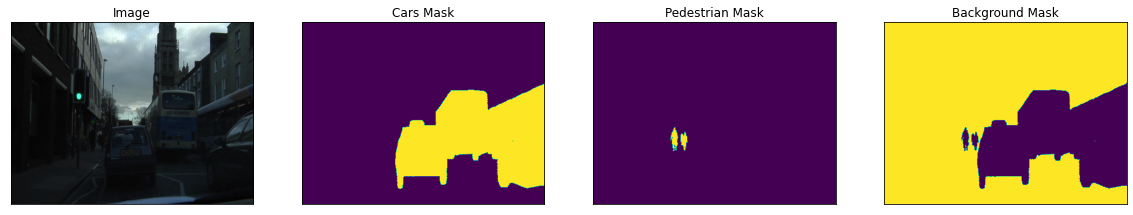

In [ ]:
dataset_debug = CamVidDatasetTF(DATASET_TRAIN_X_DIR_CAMVID, DATASET_TRAIN_Y_DIR_CAMVID, 
                                interested_classes_name=['car', 'pedestrian'],
                                augmentation=None,
                                resizing=None,
                                preprocessing=None,)
dataset_debug.mode = 'tf.data.Dataset'
image, mask = next(iter(dataset_debug.get_tf_dataset())) # get some sample
print('image : {} {} value range {}~{},\nmask : {} {} value range {}~{}'.format(image.numpy().shape, image.numpy().dtype, image.numpy().min(), image.numpy().max(), 
                                                                                mask.numpy().shape, mask.numpy().dtype, mask.numpy().min(), mask.numpy().max()))
DataPostProcessTools.visualize(
    image=image.numpy().astype('int'),
    cars_mask=mask[..., 0].numpy().squeeze(),
    pedestrian_mask=mask[..., 1].numpy().squeeze(),
    background_mask=mask[..., 2].numpy().squeeze(),
)

mask tensor shape : (360, 480, 3), number of classes + background : 3
image input: 0~255 (dtype:int64, shape:(360, 480, 3))
mask input: 0.0~1.0 (dtype:float32, shape:(360, 480, 3))
2 x 4


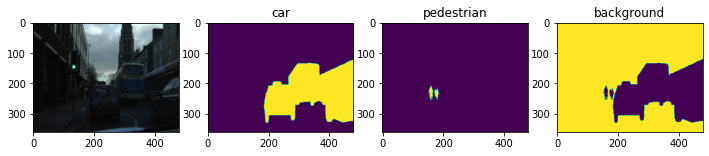

In [ ]:
DataPostProcessTools.visualize_v2(
    image=image.numpy().astype('int'),
    mask_tensor=mask.numpy(),
    label_li=['car', 'pedestrian']
)

augmentation : <class 'albumentations.core.composition.Compose'> -> <class 'albumentations.core.composition.Compose'>
preprocessing : <class 'NoneType'> -> <class 'NoneType'>
resizing : <class 'NoneType'> -> <class 'NoneType'>
no resizing
no preprocessing

[Important] Warning : augmetation not support on TPU Yet!
Pipeline will remove augmentation automatically.
(reason : tf.numpy_function not support for tpu.)
no augmentation.
_read_fn: Tracing!
_parse_classid_mask_pure_fn: Tracing
_resizing_pure_fn: Tracing!
_get_elsebranch_resizing: Tracing (no resizing)
_preprocessing_pure_fn: Tracing!
_get_elsebranch_preprocessing: Tracing (no preprocessing)
image : (360, 480, 3) float32 value range 0.0~255.0,
mask : (360, 480, 6) float32 value range 0.0~1.0


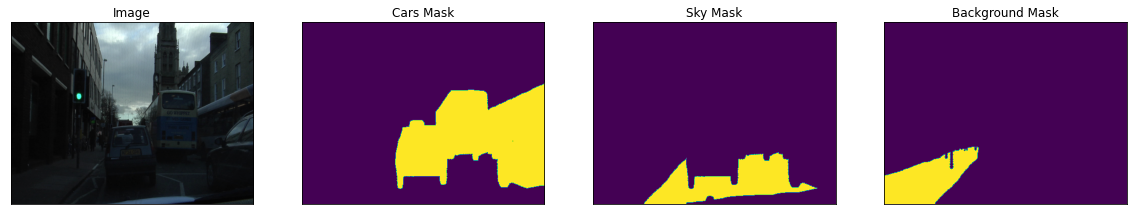

In [ ]:
dataset_debug_aug = CamVidDatasetTF(DATASET_TRAIN_X_DIR_CAMVID, DATASET_TRAIN_Y_DIR_CAMVID, 
                                    interested_classes_name=INTERESTED_CLASSES_NAME, 
                                    augmentation=get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN, rectangle=RECTANGLE),
                                    resizing=None,
                                    preprocessing=None,)

dataset_debug_aug.mode = 'tf.data.Dataset'
image, mask = next(iter(dataset_debug_aug.get_tf_dataset())) # get some sample
print('image : {} {} value range {}~{},\nmask : {} {} value range {}~{}'.format(image.numpy().shape, image.numpy().dtype, image.numpy().min(), image.numpy().max(), 
                                                                                mask.numpy().shape, mask.numpy().dtype, mask.numpy().min(), mask.numpy().max()))
DataPostProcessTools.visualize(
    image=image.numpy().astype('int'),
    cars_mask=mask[..., 0].numpy().squeeze(),
    sky_mask=mask[..., 1].numpy().squeeze(),
    background_mask=mask[..., 2].numpy().squeeze(),
)

mask tensor shape : (360, 480, 6), number of classes + background : 6
image input: 0~255 (dtype:int64, shape:(360, 480, 3))
mask input: 0.0~1.0 (dtype:float32, shape:(360, 480, 6))
3 x 4


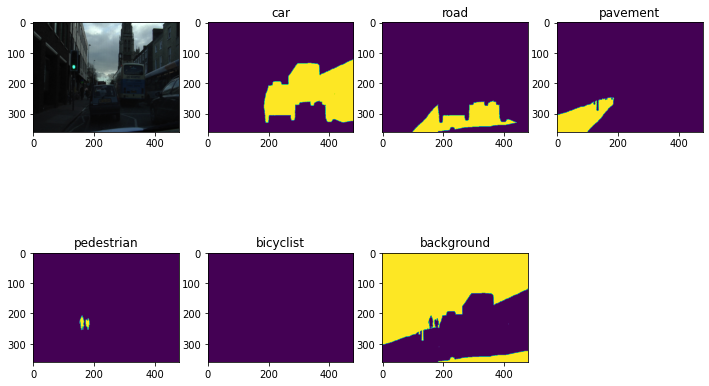

In [ ]:
DataPostProcessTools.visualize_v2(
    image=image.numpy().astype('int'),
    mask_tensor=mask.numpy(),
    label_li=INTERESTED_CLASSES_NAME
)

get_resizing: get pure tf function. (tpu compatible mode)
augmentation : <class 'albumentations.core.composition.Compose'> -> <class 'albumentations.core.composition.Compose'>
preprocessing : <class 'NoneType'> -> <class 'NoneType'>
resizing : <class 'function'> -> <class 'function'>
no preprocessing

[Important] Warning : augmetation not support on TPU Yet!
Pipeline will remove augmentation automatically.
(reason : tf.numpy_function not support for tpu.)
no augmentation.
_read_fn: Tracing!
_parse_classid_mask_pure_fn: Tracing
_resizing_pure_fn: Tracing!
_preprocessing_pure_fn: Tracing!
_get_elsebranch_preprocessing: Tracing (no preprocessing)
image : (300, 400, 3) float32 value range 2.0~255.0,
mask : (300, 400, 6) float32 value range 0.0~1.0
mask tensor shape : (300, 400, 6), number of classes + background : 6
image input: 2~255 (dtype:int64, shape:(300, 400, 3))
mask input: 0.0~1.0 (dtype:float32, shape:(300, 400, 6))
3 x 4


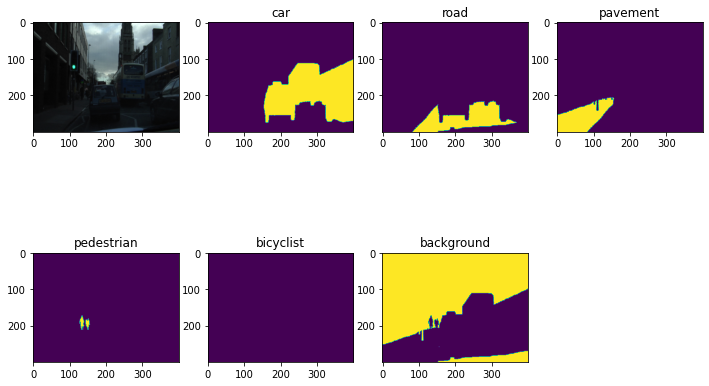

In [ ]:
dataset_debug_aug_resize = CamVidDatasetTF(DATASET_TRAIN_X_DIR_CAMVID, DATASET_TRAIN_Y_DIR_CAMVID, 
                                           interested_classes_name=INTERESTED_CLASSES_NAME, 
                                           augmentation=get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN, rectangle=RECTANGLE),
                                           resizing=get_resizing(400, 300),
                                           preprocessing=None)
dataset_debug_aug_resize.mode = 'tf.data.Dataset'
image, mask = next(iter(dataset_debug_aug_resize.get_tf_dataset())) # get some sample
print('image : {} {} value range {}~{},\nmask : {} {} value range {}~{}'.format(image.numpy().shape, image.numpy().dtype, image.numpy().min(), image.numpy().max(), 
                                                                                mask.numpy().shape, mask.numpy().dtype, mask.numpy().min(), mask.numpy().max()))
DataPostProcessTools.visualize_v2(
    image=image.numpy().astype('int'),
    mask_tensor=mask.numpy(),
    label_li=INTERESTED_CLASSES_NAME
)

get_resizing: get pure tf function. (tpu compatible mode)
served_fn (<function preprocess_input at 0x7f46e64ab830> 이 설정되었으나, TPU 에서 사용하지 못하는 경우가 많기 때문에 우선 제거합니다. 대신 이 함수의 주석을 참고하세요.
get_preprocessing: get pure tf function. (tpu compatible mode)
augmentation : <class 'albumentations.core.composition.Compose'> -> <class 'albumentations.core.composition.Compose'>
preprocessing : <class 'function'> -> <class 'function'>
resizing : <class 'function'> -> <class 'function'>

[Important] Warning : augmetation not support on TPU Yet!
Pipeline will remove augmentation automatically.
(reason : tf.numpy_function not support for tpu.)
no augmentation.
_read_fn: Tracing!
_parse_classid_mask_pure_fn: Tracing
_resizing_pure_fn: Tracing!
_preprocessing_pure_fn: Tracing!
Preprocessing.preprocessing_pure_fn: Tracing!
image : (300, 400, 3) float32 value range 0.01568627543747425~2.0,
mask : (300, 400, 6) float32 value range 0.0~1.0
mask tensor shape : (300, 400, 6), number of classes + background : 6
imag

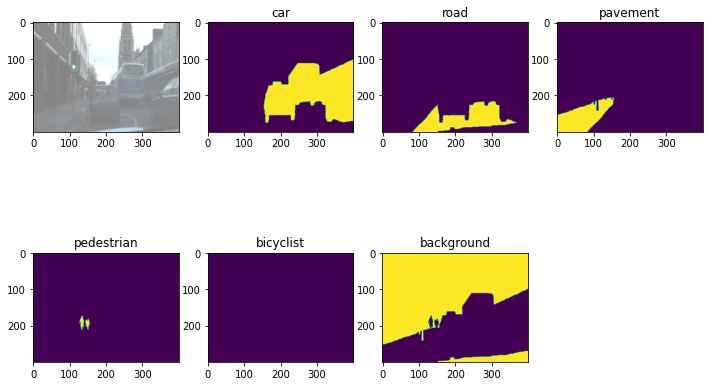

In [ ]:
dataset_debug_aug_resize_prep = CamVidDatasetTF(DATASET_TRAIN_X_DIR_CAMVID, DATASET_TRAIN_Y_DIR_CAMVID, 
                                                interested_classes_name=INTERESTED_CLASSES_NAME, 
                                                augmentation=get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN, rectangle=RECTANGLE),
                                                resizing=get_resizing(400, 300),
                                                preprocessing=get_preprocessing(preprocess_input)
                                                )
dataset_debug_aug_resize_prep.mode = 'tf.data.Dataset'
image, mask = next(iter(dataset_debug_aug_resize_prep.get_tf_dataset())) # get some sample
print('image : {} {} value range {}~{},\nmask : {} {} value range {}~{}'.format(image.numpy().shape, image.numpy().dtype, image.numpy().min(), image.numpy().max(), 
                                                                                mask.numpy().shape, mask.numpy().dtype, mask.numpy().min(), mask.numpy().max()))
DataPostProcessTools.visualize_v2(
    image=image.numpy(),
    mask_tensor=mask.numpy(),
    label_li=INTERESTED_CLASSES_NAME,
    denormalize=True,
)


[Important] Warning : augmetation not support on TPU Yet!
Pipeline will remove augmentation automatically.
(reason : tf.numpy_function not support for tpu.)
no augmentation.


  0%|          | 0/32 [00:00<?, ?it/s]

Only numpy variable could pass to _check_input_util function.
Convert (<class 'tensorflow.python.framework.ops.EagerTensor'>) to numpy automatically.
image from dataset: 0.01568627543747425~2.0 (dtype:float32, shape:(300, 400, 3))
image after denorm: 129~255 (dtype:uint8, shape:(300, 400, 3))
image before visualization: 129~255 (dtype:uint8, shape:(300, 400, 3))
Only numpy variable could pass to _check_input_util function.
Convert (<class 'tensorflow.python.framework.ops.EagerTensor'>) to numpy automatically.
image from dataset: 0.01568627543747425~2.0 (dtype:float32, shape:(300, 400, 3))
image after denorm: 129~255 (dtype:uint8, shape:(300, 400, 3))
image before visualization: 129~255 (dtype:uint8, shape:(300, 400, 3))
Only numpy variable could pass to _check_input_util function.
Convert (<class 'tensorflow.python.framework.ops.EagerTensor'>) to numpy automatically.
image from dataset: 0.01568627543747425~2.0 (dtype:float32, shape:(300, 400, 3))
image after denorm: 129~255 (dtype:uint

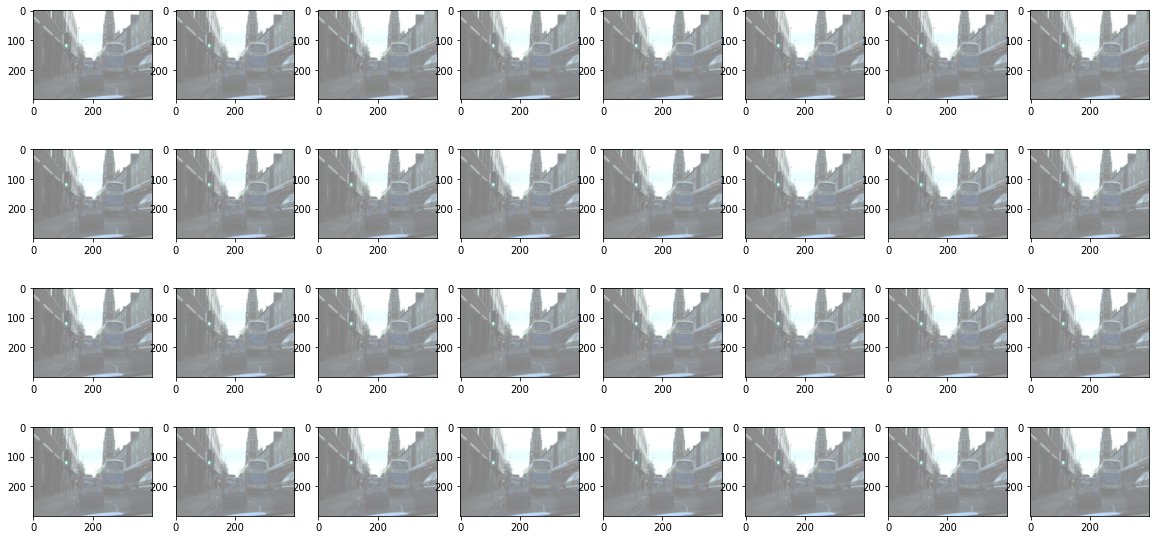

In [ ]:
DataPostProcessTools.visualize_for_qualitative(dataset_debug_aug_resize_prep, denormalize=True, n=32)

get_resizing: get pure tf function. (tpu compatible mode)
served_fn (<function preprocess_input at 0x7f46e64ab830> 이 설정되었으나, TPU 에서 사용하지 못하는 경우가 많기 때문에 우선 제거합니다. 대신 이 함수의 주석을 참고하세요.
get_preprocessing: get pure tf function. (tpu compatible mode)
augmentation : <class 'albumentations.core.composition.Compose'> -> <class 'albumentations.core.composition.Compose'>
preprocessing : <class 'function'> -> <class 'function'>
resizing : <class 'function'> -> <class 'function'>

[Important] Warning : augmetation not support on TPU Yet!
Pipeline will remove augmentation automatically.
(reason : tf.numpy_function not support for tpu.)
no augmentation.
_read_fn: Tracing!
_parse_classid_mask_pure_fn: Tracing
_resizing_pure_fn: Tracing!
_preprocessing_pure_fn: Tracing!
Preprocessing.preprocessing_pure_fn: Tracing!


  0%|          | 0/32 [00:00<?, ?it/s]

Only numpy variable could pass to _check_input_util function.
Convert (<class 'tensorflow.python.framework.ops.EagerTensor'>) to numpy automatically.
image from dataset: 0.01568627543747425~2.0 (dtype:float32, shape:(320, 320, 3))
image after denorm: 129~255 (dtype:uint8, shape:(320, 320, 3))
image before visualization: 129~255 (dtype:uint8, shape:(320, 320, 3))
Only numpy variable could pass to _check_input_util function.
Convert (<class 'tensorflow.python.framework.ops.EagerTensor'>) to numpy automatically.
image from dataset: 0.01568627543747425~2.0 (dtype:float32, shape:(320, 320, 3))
image after denorm: 129~255 (dtype:uint8, shape:(320, 320, 3))
image before visualization: 129~255 (dtype:uint8, shape:(320, 320, 3))
Only numpy variable could pass to _check_input_util function.
Convert (<class 'tensorflow.python.framework.ops.EagerTensor'>) to numpy automatically.
image from dataset: 0.01568627543747425~2.0 (dtype:float32, shape:(320, 320, 3))
image after denorm: 129~255 (dtype:uint

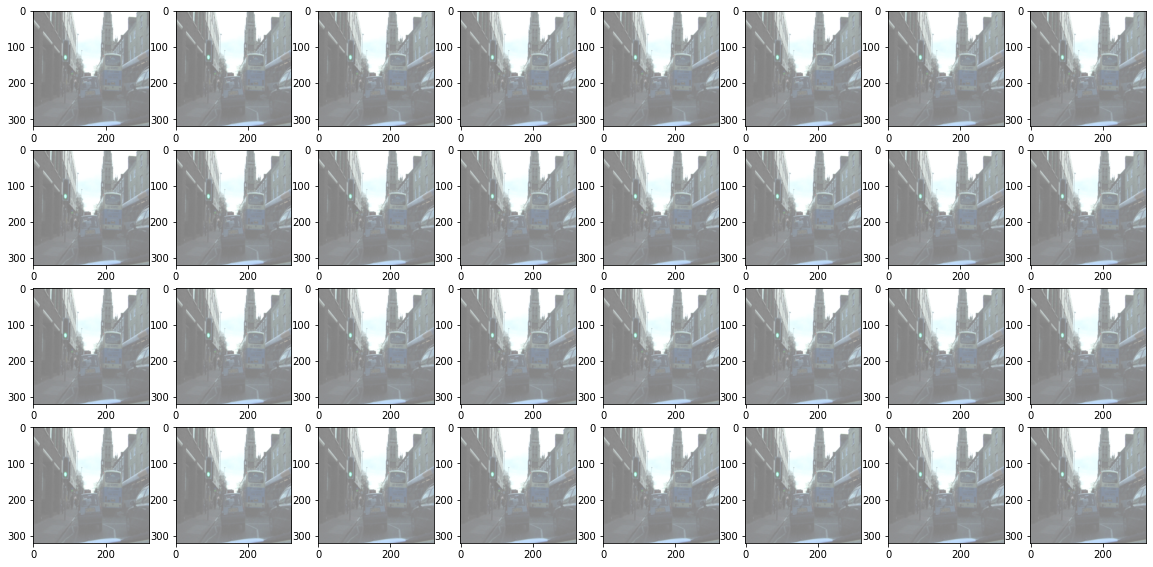

In [ ]:
dataset_debug_aug_resize = CamVidDatasetTF(DATASET_TRAIN_X_DIR_CAMVID, DATASET_TRAIN_Y_DIR_CAMVID, 
                                           interested_classes_name=INTERESTED_CLASSES_NAME, 
                                           augmentation=get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, DATASET_WIDTH, DATASET_HEIGHT, rectangle=RECTANGLE),
                                           resizing=get_resizing(MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN),
                                           preprocessing=get_preprocessing(preprocess_input)
                                           )
dataset_debug_aug_resize.mode = 'tf.data.Dataset'
DataPostProcessTools.visualize_for_qualitative(dataset_debug_aug_resize, denormalize=True, n=32)

#### [Extension] Debug Data Loader and Augmentation (tf.train.Example&TFRecord)

augmentation : <class 'NoneType'> -> <class 'NoneType'>
preprocessing : <class 'NoneType'> -> <class 'NoneType'>
resizing : <class 'NoneType'> -> <class 'NoneType'>
no augmentation
no resizing
no preprocessing
Running with TFRecord.
_parse_classid_mask_pure_fn: Tracing
_resizing_pure_fn: Tracing!
_get_elsebranch_resizing: Tracing (no resizing)
_preprocessing_pure_fn: Tracing!
_get_elsebranch_preprocessing: Tracing (no preprocessing)
image : (320, 320, 3) float32 value range 0.0~255.0,
mask : (320, 320, 6) float32 value range 0.0~1.0
mask tensor shape : (320, 320, 6), number of classes + background : 6
image input: 0~255 (dtype:int64, shape:(320, 320, 3))
mask input: 0.0~1.0 (dtype:float32, shape:(320, 320, 6))
3 x 4


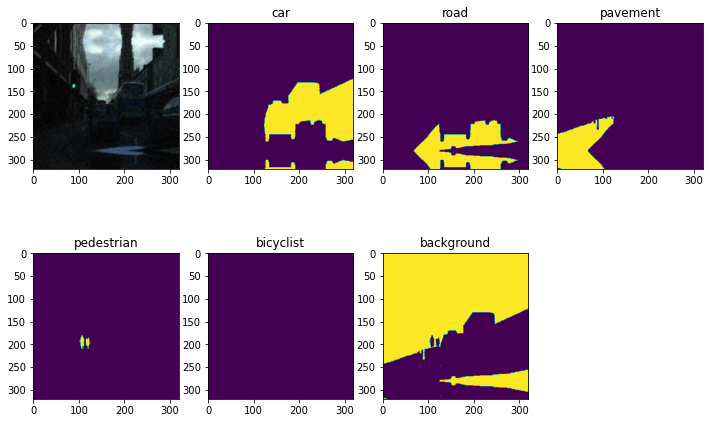

In [ ]:
dataset_debug = CamVidDatasetTFRecord(DATASET_TFRECORD_DIR_CAMVID, 
                                      interested_classes_name=INTERESTED_CLASSES_NAME, 
                                      augmentation=None,
                                      resizing=None,
                                      preprocessing=None,
                                      )
dataset_debug.mode = 'tf.data.Dataset'
image, mask = next(iter(dataset_debug.get_tf_dataset())) # get some sample
print('image : {} {} value range {}~{},\nmask : {} {} value range {}~{}'.format(image.numpy().shape, image.numpy().dtype, image.numpy().min(), image.numpy().max(), 
                                                                                mask.numpy().shape, mask.numpy().dtype, mask.numpy().min(), mask.numpy().max()))
DataPostProcessTools.visualize_v2(
    image=image.numpy().astype('int'),
    mask_tensor=mask.numpy(),
    label_li=INTERESTED_CLASSES_NAME
)

get_resizing: get pure tf function. (tpu compatible mode)
augmentation : <class 'albumentations.core.composition.Compose'> -> <class 'albumentations.core.composition.Compose'>
preprocessing : <class 'NoneType'> -> <class 'NoneType'>
resizing : <class 'function'> -> <class 'function'>
no preprocessing

[Important] Warning : augmetation not support on TPU Yet!
Pipeline will remove augmentation automatically.
(reason : tf.numpy_function not support for tpu.)
no augmentation.
Running with TFRecord.
_parse_classid_mask_pure_fn: Tracing
_resizing_pure_fn: Tracing!
_preprocessing_pure_fn: Tracing!
_get_elsebranch_preprocessing: Tracing (no preprocessing)
image : (320, 320, 3) float32 value range 0.0~255.0,
mask : (320, 320, 6) float32 value range 0.0~1.0
mask unique value : [0. 1.]
mask tensor shape : (320, 320, 6), number of classes + background : 6
image input: 0~255 (dtype:int64, shape:(320, 320, 3))
mask input: 0.0~1.0 (dtype:float32, shape:(320, 320, 6))
3 x 4


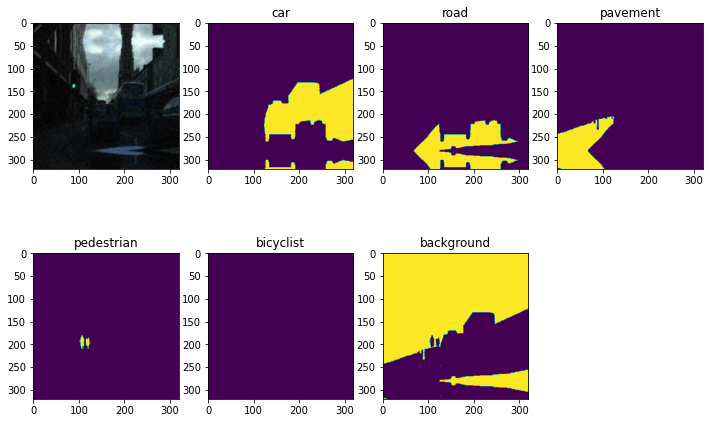

In [ ]:
dataset_debug_aug_resize = CamVidDatasetTFRecord(DATASET_TFRECORD_DIR_CAMVID, 'train',
                                                 interested_classes_name=INTERESTED_CLASSES_NAME, 
                                                 augmentation=get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, DATASET_WIDTH, DATASET_HEIGHT, rectangle=RECTANGLE),
                                                 resizing=get_resizing(MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN),
                                                 preprocessing=None,
                                                 )
dataset_debug_aug_resize.mode = 'tf.data.Dataset'
image, mask = next(iter(dataset_debug_aug_resize.get_tf_dataset())) # get some sample
print('image : {} {} value range {}~{},\nmask : {} {} value range {}~{}'.format(image.numpy().shape, image.numpy().dtype, image.numpy().min(), image.numpy().max(), 
                                                                                mask.numpy().shape, mask.numpy().dtype, mask.numpy().min(), mask.numpy().max()))
print('mask unique value : {}'.format(np.unique(mask.numpy())))
DataPostProcessTools.visualize_v2(
    image=image.numpy().astype('int'),
    mask_tensor=mask.numpy(),
    label_li=INTERESTED_CLASSES_NAME
)


[Important] Warning : augmetation not support on TPU Yet!
Pipeline will remove augmentation automatically.
(reason : tf.numpy_function not support for tpu.)
no augmentation.
Running with TFRecord.


  0%|          | 0/32 [00:00<?, ?it/s]

Only numpy variable could pass to _check_input_util function.
Convert (<class 'tensorflow.python.framework.ops.EagerTensor'>) to numpy automatically.
image from dataset: 0.0~255.0 (dtype:float32, shape:(320, 320, 3))
image before visualization: 0~255 (dtype:int64, shape:(320, 320, 3))
Only numpy variable could pass to _check_input_util function.
Convert (<class 'tensorflow.python.framework.ops.EagerTensor'>) to numpy automatically.
image from dataset: 0.0~255.0 (dtype:float32, shape:(320, 320, 3))
image before visualization: 0~255 (dtype:int64, shape:(320, 320, 3))
Only numpy variable could pass to _check_input_util function.
Convert (<class 'tensorflow.python.framework.ops.EagerTensor'>) to numpy automatically.
image from dataset: 0.0~255.0 (dtype:float32, shape:(320, 320, 3))
image before visualization: 0~255 (dtype:int64, shape:(320, 320, 3))
Only numpy variable could pass to _check_input_util function.
Convert (<class 'tensorflow.python.framework.ops.EagerTensor'>) to numpy automat

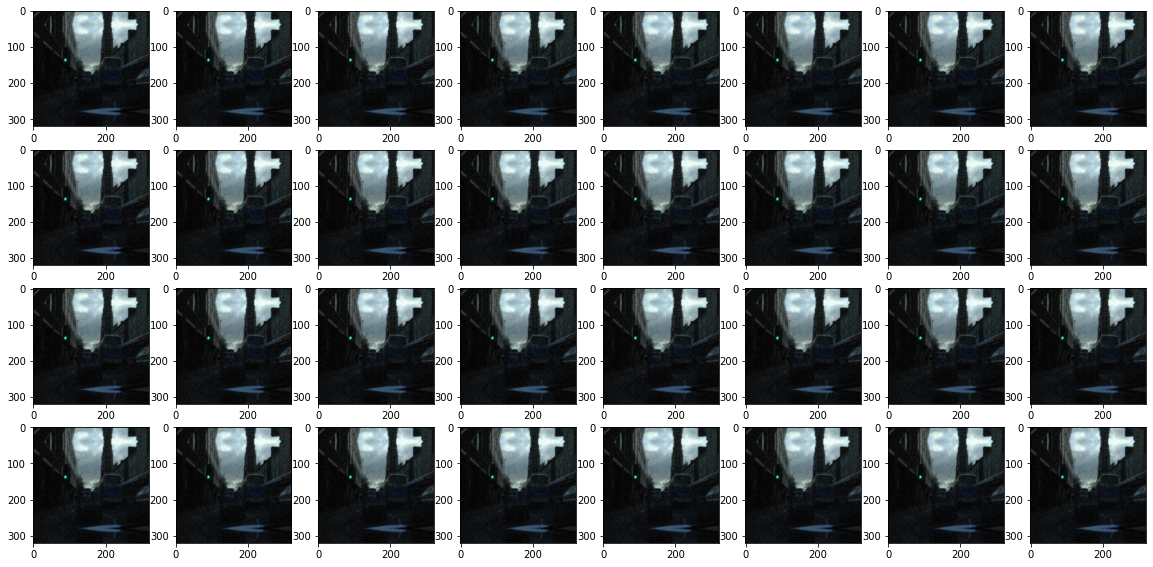

In [ ]:
DataPostProcessTools.visualize_for_qualitative(dataset_debug_aug_resize, denormalize=False, n=32)

get_resizing: get pure tf function. (tpu compatible mode)
served_fn (<function preprocess_input at 0x7f46e64ab830> 이 설정되었으나, TPU 에서 사용하지 못하는 경우가 많기 때문에 우선 제거합니다. 대신 이 함수의 주석을 참고하세요.
get_preprocessing: get pure tf function. (tpu compatible mode)
augmentation : <class 'albumentations.core.composition.Compose'> -> <class 'albumentations.core.composition.Compose'>
preprocessing : <class 'function'> -> <class 'function'>
resizing : <class 'function'> -> <class 'function'>

[Important] Warning : augmetation not support on TPU Yet!
Pipeline will remove augmentation automatically.
(reason : tf.numpy_function not support for tpu.)
no augmentation.
Running with TFRecord.
_parse_classid_mask_pure_fn: Tracing
_resizing_pure_fn: Tracing!
_preprocessing_pure_fn: Tracing!
Preprocessing.preprocessing_pure_fn: Tracing!
image : (320, 320, 3) float32 value range 0.0~2.0,
mask : (320, 320, 6) float32 value range 0.0~1.0
mask unique value : [0. 1.]
mask tensor shape : (320, 320, 6), number of classes + bac

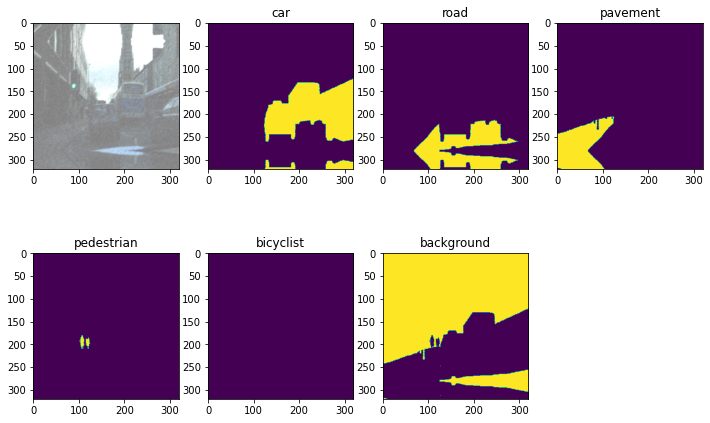

In [ ]:
dataset_debug_aug_resize_prep = CamVidDatasetTFRecord(DATASET_TFRECORD_DIR_CAMVID, 'train',
                                                      interested_classes_name=INTERESTED_CLASSES_NAME, 
                                                      augmentation=get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, DATASET_WIDTH, DATASET_HEIGHT, rectangle=RECTANGLE),
                                                      resizing=get_resizing(MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN),
                                                      preprocessing=get_preprocessing(preprocess_input)
                                                      )
dataset_debug_aug_resize_prep.mode = 'tf.data.Dataset'
image, mask = next(iter(dataset_debug_aug_resize_prep.get_tf_dataset())) # get some sample
print('image : {} {} value range {}~{},\nmask : {} {} value range {}~{}'.format(image.numpy().shape, image.numpy().dtype, image.numpy().min(), image.numpy().max(), 
                                                                                mask.numpy().shape, mask.numpy().dtype, mask.numpy().min(), mask.numpy().max()))
print('mask unique value : {}'.format(np.unique(mask.numpy())))
DataPostProcessTools.visualize_v2(
    image=image.numpy(),
    mask_tensor=mask.numpy(),
    label_li=INTERESTED_CLASSES_NAME,
    denormalize=True,
)


[Important] Warning : augmetation not support on TPU Yet!
Pipeline will remove augmentation automatically.
(reason : tf.numpy_function not support for tpu.)
no augmentation.
Running with TFRecord.


  0%|          | 0/32 [00:00<?, ?it/s]

Only numpy variable could pass to _check_input_util function.
Convert (<class 'tensorflow.python.framework.ops.EagerTensor'>) to numpy automatically.
image from dataset: 0.0~2.0 (dtype:float32, shape:(320, 320, 3))
image after denorm: 127~255 (dtype:uint8, shape:(320, 320, 3))
image before visualization: 127~255 (dtype:uint8, shape:(320, 320, 3))
Only numpy variable could pass to _check_input_util function.
Convert (<class 'tensorflow.python.framework.ops.EagerTensor'>) to numpy automatically.
image from dataset: 0.0~2.0 (dtype:float32, shape:(320, 320, 3))
image after denorm: 127~255 (dtype:uint8, shape:(320, 320, 3))
image before visualization: 127~255 (dtype:uint8, shape:(320, 320, 3))
Only numpy variable could pass to _check_input_util function.
Convert (<class 'tensorflow.python.framework.ops.EagerTensor'>) to numpy automatically.
image from dataset: 0.0~2.0 (dtype:float32, shape:(320, 320, 3))
image after denorm: 127~255 (dtype:uint8, shape:(320, 320, 3))
image before visualizati

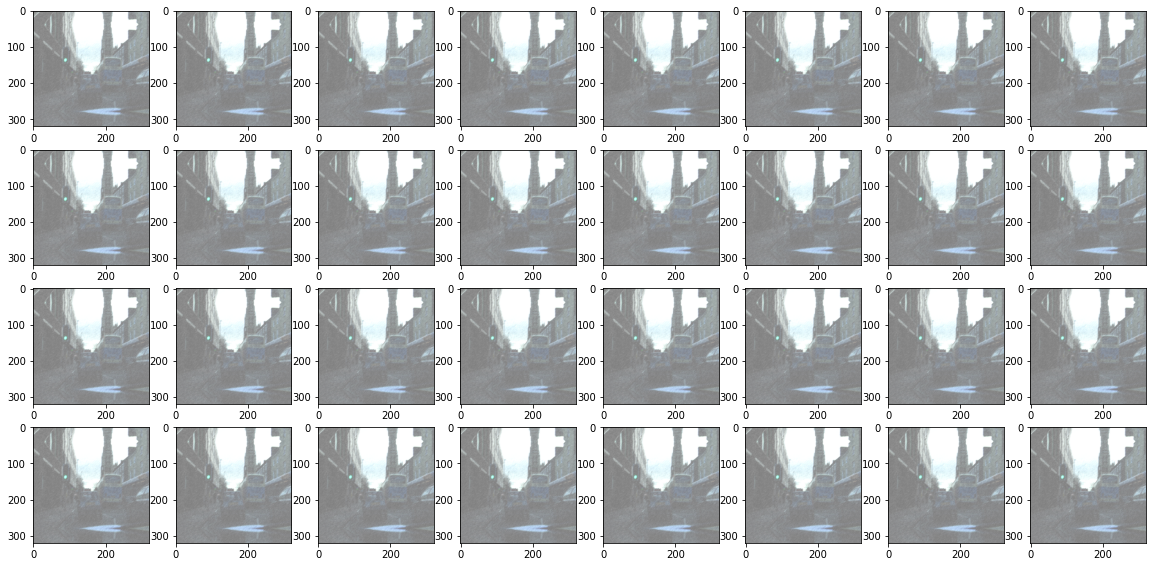

In [ ]:
DataPostProcessTools.visualize_for_qualitative(dataset_debug_aug_resize_prep, denormalize=True, n=32)

### Run UNet-BACKBONE

#### Train

- get_resizing 을 사용하지 않으면, 케라스가 자동으로 입력 사이즈를 맞추려고 함.
- 하지만 이렇게 되는 경우, 리사이징을 하는 부분이 tpu 에 호환되지 않음.
- tf 의 연산을 사용해서 TPU 가 원하는 대로 맞춰준 채로 모델의 입력에 사용할 수 있도록 tpu 사용 시 get_resizing 을 True 로 사용할 것

In [ ]:
INIT_TENSORBOARD_LOG = False #@param {type: "boolean"}
INIT_KERAS_SESSION = True #@param {type: "boolean"}
GET_RESIZING = True #@param {type: "boolean"}
if USE_TPU:
    assert GET_RESIZING  # FIXME
GET_AUGMENTATION = False #@param {type: "boolean"}
GET_PREPROCESSING = True #@param {type: "boolean"}

In [ ]:
if INIT_TENSORBOARD_LOG:
    !rm -r {LOG_DIR_DATASETNAME_MODELINFO} #select model
if INIT_KERAS_SESSION:
    tf.keras.backend.clear_session()


if TRAINING_PARALLEL_STRATEGY is not None:
    assert USE_GCS, """All input files and the model directory must use a cloud storage bucket path (gs://bucket-name/...), \
    and this bucket must be accessible from the TPU server. \
    Note that all data processing and model checkpointing is performed on the TPU server, not the local machine. \
    For information on how to properly configure cloud storage for use with the TPU, see the guide Connecting to Cloud Storage Buckets."""
    # assume that training strategy is only set up with google colab TPU
    assert INPUT_PIPELINE == 'tf.data.Dataset', '{} does not support TPU strategy.'.format(INPUT_PIPELINE)
    pass

if INPUT_PIPELINE == 'tf.keras.Sequence':
    if GET_RESIZING:
        XY_train.resizing       = get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN)
    if GET_AUGMENTATION:
        XY_train.augmentation   = get_training_augmentation(dataset_w=DATASET_WIDTH, 
                                                            dataset_h=DATASET_HEIGHT,
                                                            cropped_augmented_image_return_w=DATASET_WIDTH,
                                                            cropped_augmented_image_return_h=DATASET_HEIGHT,
                                                            rectangle=RECTANGLE)
    if GET_PREPROCESSING:
        XY_train.preprocessing  = get_preprocessing(preprocess_input) # 사전학습 모델에 맞는 전처리방법을 선택
        
    if GET_RESIZING:
        XY_valid.resizing       = get_resizing(MODEL_INPUT_WIDTH_FOR_VALID, MODEL_INPUT_HEIGHT_FOR_VALID)
    if GET_AUGMENTATION:
        XY_valid.augmentation   = get_validation_augmentation(dataset_w=DATASET_WIDTH,
                                                              dataset_h=DATASET_HEIGHT,
                                                              cropped_augmented_image_return_w=DATASET_WIDTH,
                                                              cropped_augmented_image_return_h=DATASET_HEIGHT)
    if GET_PREPROCESSING:
        XY_valid.preprocessing  = get_preprocessing(preprocess_input) # 사전학습 모델에 맞는 전처리방법을 선택

elif INPUT_PIPELINE == 'tf.data.Dataset':
    if USE_TFRECORD:
        XY_train_tf = XY_train_tfr
        XY_valid_tf = XY_valid_tfr
        XY_test_tf = XY_test_tfr

    if GET_RESIZING:
        XY_train_tf.resizing      = get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN)
    if GET_AUGMENTATION:
        XY_train_tf.augmentation  = get_training_augmentation(dataset_w=DATASET_WIDTH, 
                                                              dataset_h=DATASET_HEIGHT,
                                                              cropped_augmented_image_return_w=DATASET_WIDTH,
                                                              cropped_augmented_image_return_h=DATASET_HEIGHT,
                                                              rectangle=RECTANGLE)
    if GET_PREPROCESSING:
        XY_train_tf.preprocessing = get_preprocessing(preprocess_input) # 사전학습 모델에 맞는 전처리방법을 선택

    if GET_RESIZING:
        XY_valid_tf.resizing      = get_resizing(MODEL_INPUT_WIDTH_FOR_VALID, MODEL_INPUT_HEIGHT_FOR_VALID)
    if GET_AUGMENTATION:
        XY_valid_tf.augmentation  = get_validation_augmentation(dataset_w=DATASET_WIDTH,
                                                                dataset_h=DATASET_HEIGHT,
                                                                cropped_augmented_image_return_w=DATASET_WIDTH,
                                                                cropped_augmented_image_return_h=DATASET_HEIGHT)
    if GET_PREPROCESSING:
        XY_valid_tf.preprocessing = get_preprocessing(preprocess_input) # 사전학습 모델에 맞는 전처리방법을 선택

    XY_train_tf.mode = 'tf.data.Dataset'
    XY_valid_tf.mode = 'tf.data.Dataset'

else:
    raise NotImplementedError


if INPUT_PIPELINE == 'tf.keras.Sequence':
    train_dataloader = DataLoader(XY_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(XY_valid, batch_size=VALID_BATCH_SIZE, shuffle=True)
    assert valid_dataloader[0][0].shape == (VALID_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, 3)
    assert valid_dataloader[0][1].shape == (VALID_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, N_CLASSES)

elif INPUT_PIPELINE == 'tf.data.Dataset':
    train_dataloader = data_loader_tf(XY_train_tf.get_tf_dataset(), batch_size=TRAIN_BATCH_SIZE)
    valid_dataloader = data_loader_tf(XY_valid_tf.get_tf_dataset(), batch_size=VALID_BATCH_SIZE)
    if TRAINING_PARALLEL_STRATEGY is not None:
        pass
    else:
        assert next(iter(train_dataloader))[0].shape == (TRAIN_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, 3), '{} (desired {})'.format(next(iter(train_dataloader))[0].shape, (TRAIN_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, 3))
        assert next(iter(train_dataloader))[1].shape == (TRAIN_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, N_CLASSES)
        assert next(iter(valid_dataloader))[0].shape == (VALID_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, 3)
        assert next(iter(valid_dataloader))[1].shape == (VALID_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, N_CLASSES)
else:
    print('{} is not support'.format(INPUT_PIPELINE))
    raise NotImplemendedError

if TRAINING_PARALLEL_STRATEGY is None: 
    #tf.summary function unstable. Do not use this function when you run on TPU
    #later, wrap with @tf.function instead. See tf.summary documentation.
    image_writer = tf.summary.create_file_writer(os.path.join(LOG_DIR_DATASETNAME_MODELINFO, 'image_ex')) #select model
    mask_writer = tf.summary.create_file_writer(os.path.join(LOG_DIR_DATASETNAME_MODELINFO, 'mask_ex')) #select model
    with image_writer.as_default():
        if INPUT_PIPELINE == 'tf.keras.Sequence':
            images = train_dataloader[0][0]
        elif INPUT_PIPELINE == 'tf.data.Dataset':
            images = next(iter(train_dataloader))[0]
        else:
            raise NotImplementedError

        if GET_PREPROCESSING:
            tf.summary.image("One batch image", DataPostProcessTools.denormalize(images), max_outputs=TRAIN_BATCH_SIZE, step=0)
        else:
            tf.summary.image("One batch image", images, max_outputs=TRAIN_BATCH_SIZE, step=0)

    with mask_writer.as_default():
        if INPUT_PIPELINE == 'tf.keras.Sequence':
            masks = train_dataloader[0][1] # get 1 mask
        elif INPUT_PIPELINE == 'tf.data.Dataset':
            masks = next(iter(train_dataloader))[1][0,:,:,:] # get 1 mask
        else:
            raise NotImplementedError
        tf.summary.image("One batch mask", 
                          tf.reshape(masks, [N_CLASSES, 
                                             MODEL_INPUT_HEIGHT_FOR_TRAIN, 
                                             MODEL_INPUT_WIDTH_FOR_TRAIN, 1]), 
                          #max_outputs=TRAIN_BATCH_SIZE, 
                          step=0)
        

callback_tboard = tf.keras.callbacks.TensorBoard(
    log_dir=LOG_DIR_DATASETNAME_MODELINFO, #select model
    histogram_freq=1, write_graph=False, 
    #write_graph=True option unstable. Do not use option especially when you run on TPU
    write_images=True, update_freq=TBOARD_HISTOGRAM_LOG_UPDATE_FREQ, profile_batch=1,
    #profile_batch does not work on tf 2.5 or tensorboard latest version. Maybe we should wait for bugfix :)
    embeddings_freq=0, embeddings_metadata=None
)
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(WEIGHTS_DIR_DATASETNAME_MODELINFO,'epoch-{epoch:02d}-valloss-{val_loss:.2f}'), #select model
    save_weights_only=True, save_best_only=True, mode='min', verbose=1 #save weights True
)
callback_lrtuner = tf.keras.callbacks.ReduceLROnPlateau()


if TRAINING_PARALLEL_STRATEGY is not None:
    with TRAINING_PARALLEL_STRATEGY.scope():
        model = Arch(BACKBONE, 
                        input_shape=(MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, 3), 
                        classes=N_CLASSES,
                        activation='softmax',
                        encoder_weights=PRETRAINED_WEIGHT if PRETRAINED_WEIGHT in ['imagenet'] else None,
                        encoder_freeze=False)
        model.compile(OPTIMIZER, LOSS_SET, METRICS_SET)
else:
    model = Arch(BACKBONE, 
                    classes=N_CLASSES, 
                    activation='softmax',
                    encoder_weights=PRETRAINED_WEIGHT if PRETRAINED_WEIGHT in ['imagenet'] else None,
                    encoder_freeze=False)
    model.compile(OPTIMIZER, LOSS_SET, METRICS_SET)

if not USE_GCS:
    f = os.path.join(MODEL_PLOT_DIR, '{}-{}.jpg'.format(ARCHITECTURE, BACKBONE)) #select model
    tf.keras.utils.plot_model(model, to_file=f, show_shapes=True, show_layer_names=True)

model.summary()

if INPUT_PIPELINE == 'tf.keras.Sequence':
    TRAIN_STEPS_PER_EPOCH = len(train_dataloader)
    VALID_STEPS_PER_EPOCH = len(valid_dataloader)
elif INPUT_PIPELINE == 'tf.data.Dataset':
    import math
    TRAIN_STEPS_PER_EPOCH = math.floor(len(XY_train_tf) // TRAIN_BATCH_SIZE)
    VALID_STEPS_PER_EPOCH = math.floor(len(XY_valid_tf) // VALID_BATCH_SIZE)
else:
    raise NotImplementedError

print('training steps per epoch : {}\nvalidation steps per epoch : {}'.format(TRAIN_STEPS_PER_EPOCH, VALID_STEPS_PER_EPOCH))
model.fit(train_dataloader,
          validation_data=valid_dataloader,
          steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
          validation_steps=VALID_STEPS_PER_EPOCH,
          epochs=N_EPOCH,
          callbacks=[callback_tboard, callback_bestmodel, callback_lrtuner],
          verbose=1
          )

## Aihub Pedestrian Surface masking

For this example we will use Aihub Pedestrian Surface masking dataset. It is a set of:
- **images and labels** images + segmentation masks
- All images have 1080 pixels height and 1920 pixels width.

<br>

For more inforamtion about dataset visit 
- https://www.aihub.or.kr/aidata/136

<br>

This notebook does not serve dataset download shortcut.

### Datasets

In [37]:
DATASETNAME = 'pedestrian/surface_masking' #@param ['pedestrian/surface_masking', 'pedestrian_sample/surface_masking']

DATASET_INDEXFILE_DIR_PEDESTRIAN = os.path.join(DATA_INDEXFILE_DIR, DATASETNAME.upper())
DATASET_INDEXFILE_TRAIN_PEDESTRIAN = os.path.join(DATASET_INDEXFILE_DIR_PEDESTRIAN, 'train')
DATASET_INDEXFILE_VAL_PEDESTRIAN = os.path.join(DATASET_INDEXFILE_DIR_PEDESTRIAN, 'val')
DATASET_INDEXFILE_TEST_PEDESTRIAN = os.path.join(DATASET_INDEXFILE_DIR_PEDESTRIAN, 'test')

DATASET_TFRECORD_DIR_PEDESTRIAN = os.path.join(DATA_TFRECORD_DIR, DATASETNAME.upper())
#DATASET_TFRECORD_TRAIN_PATH_PEDESTRIAN = os.path.join(DATASET_TFRECORD_DIR_PEDESTRIAN, 'train')
#DATASET_TFRECORD_VAL_PATH_PEDESTRIAN = os.path.join(DATASET_TFRECORD_DIR_PEDESTRIAN, 'val')
#DATASET_TFRECORD_TEST_PATH_PEDESTRIAN = os.path.join(DATASET_TFRECORD_DIR_PEDESTRIAN, 'test')

if USE_GCS:
    print('\nshow {}'.format(WS))
    !gsutil ls {WS}
    print('\nshow {}'.format(DATASET_INDEXFILE_DIR_PEDESTRIAN))
    !gsutil ls {DATASET_INDEXFILE_DIR_PEDESTRIAN}
    print('\nshow {}'.format(DATASET_TFRECORD_DIR_PEDESTRIAN))
    !gsutil ls {DATASET_TFRECORD_DIR_PEDESTRIAN}
else:
    %cd {WS}
    %ls -al
    %cd {DATASET_INDEXFILE_DIR_PEDESTRIAN}
    %ls -al
    %cd {DATASET_TFRECORD_DIR_PEDESTRIAN}
    %ls -al

/content/gdrive/MyDrive/ColabWorkspace
total 24
drwx------ 10 root root 4096 Nov  3 09:04 albumentations/
drwx------ 10 root root 4096 Nov 18 06:31 efficientnet/
drwx------  2 root root 4096 Jun 25 04:43 .ipynb_checkpoints/
drwx------ 15 root root 4096 May 25 05:07 paper_implementation_and_testing_tf2/
drwx------  9 root root 4096 Jun 22 02:12 segmentation_models/
drwx------  2 root root 4096 Nov 16 09:47 sknw/
/content/gdrive/MyDrive/data/index/PEDESTRIAN/SURFACE_MASKING
total 8380
-rw------- 1 root root  85655 Nov  9 09:45 test_0
-rw------- 1 root root  85655 Nov  9 09:45 test_1
-rw------- 1 root root  85655 Nov  9 09:45 test_2
-rw------- 1 root root  85655 Nov  9 09:45 test_3
-rw------- 1 root root  85655 Nov  9 09:45 test_4
-rw------- 1 root root  85655 Nov  9 09:45 test_5
-rw------- 1 root root  85655 Nov  9 09:45 test_6
-rw------- 1 root root  85655 Nov  9 09:45 test_7
-rw------- 1 root root  85655 Nov  9 09:45 test_8
-rw------- 1 root root  85655 Nov  9 09:45 test_9
-rw------- 1

### Hyper Parameters

In [48]:
# dataset and training info
DATASET_WIDTH = 1920 #@param
DATASET_HEIGHT = 1080 #@param
MODEL_INPUT_WIDTH_FOR_TRAIN =  384#@param
MODEL_INPUT_HEIGHT_FOR_TRAIN =  288#@param
RECTANGLE = MODEL_INPUT_WIDTH_FOR_TRAIN == MODEL_INPUT_HEIGHT_FOR_TRAIN 
MODEL_INPUT_WIDTH_FOR_VALID =  384#@param
MODEL_INPUT_HEIGHT_FOR_VALID =  288#@param
if USE_TPU:
    assert MODEL_INPUT_WIDTH_FOR_TRAIN == MODEL_INPUT_WIDTH_FOR_VALID
    assert MODEL_INPUT_HEIGHT_FOR_TRAIN == MODEL_INPUT_HEIGHT_FOR_VALID

# model info
ARCHITECTURE = 'fpn' #@param ['unet', 'pspnet', 'fpn', 'linknet']
BACKBONE = 'efficientnetb0' #@param ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']
PRETRAINED_WEIGHT = 'none' #@param ['imagenet', 'none']
assert PRETRAINED_WEIGHT != 'imagenet', f'Now {PRETRAINED_WEIGHT} is not supported.'\
    'See https://github.com/ProtossDragoon/paper_implementation_and_testing_tf2/issues/4'
preprocess_input = sm.get_preprocessing(BACKBONE)

if ARCHITECTURE == 'unet':
    assert MODEL_INPUT_WIDTH_FOR_TRAIN % 32 == 0, 'unet restricts input image width to multiple of 32.'
    assert MODEL_INPUT_HEIGHT_FOR_TRAIN % 32 == 0, 'unet restricts input image height to multiple of 32.'

if ARCHITECTURE.lower() == 'unet':
    Arch = sm.Unet
elif ARCHITECTURE.lower() == 'fpn':
    Arch = sm.FPN
elif ARCHITECTURE.lower() == 'pspnet':
    Arch = sm.PSPNet
elif ARCHITECTURE.lower() == 'linknet':
    Arch = sm.Linknet

# pipeline info
SAVE_WEIGHTS_ONLY = True
INPUT_PIPELINE = 'tf.data.Dataset' #@param ['tf.keras.Sequence', 'tf.data.Dataset']
USE_TFRECORD = True #@param {type:"boolean"}
if USE_TFRECORD:
    assert INPUT_PIPELINE == 'tf.data.Dataset', 'tf.data.Dataset pipeline required to use TFRecord'

# model hyper parameters
TRAIN_BATCH_SIZE = 96#@param
TRAIN_DATA_LEN = None
TRAIN_DATA_SHAPE = None
TRAIN_STEPS_PER_EPOCH = None
VALID_BATCH_SIZE =  96#@param
VALID_DATA_LEN = None
VALID_STEPS_PER_EPOCH = None
N_EPOCH =  150#@param
START_LR = 0.0001 #@param

INTERESTED_CLASSES_NAME = ["sidewalk_block", "sidewalk_other", "crosswalk", "carroad", "tree", "manhole", "guideblock", "dangerous"] #@param
# ["sidewalk_block", "sidewalk_other", "crosswalk", "carroad", "tree", "manhole", "guideblock", "dangerous"] #@param
# ["alley_normal", "alley_crosswalk", "alley_speed_bump", "roadway_crosswalk", "roadway_normal",      "bike_lane_normal", "caution_zone_stairs", "alley_damaged", "caution_zone_grating",       "caution_zone_manhole", "caution_zone_tree_zone", "caution_zone_repair_zone", "sidewalk_damaged", "braille_guide_blocks_normal", "braille_guide_blocks_damaged",       "sidewalk_blocks", "sidewalk_cement", "sidewalk_urethane", "sidewalk_asphalt",       "sidewalk_soil_stone", "sidewalk_other"]  #@param
N_CLASSES = 1 if len(INTERESTED_CLASSES_NAME) == 1 else (len(INTERESTED_CLASSES_NAME) + 1) # case for binary and multiclass segmentation

# tensorboard option
TBOARD_HISTOGRAM_LOG_UPDATE_FREQ = 'epoch' #@param ['batch', 'epoch']
if TBOARD_HISTOGRAM_LOG_UPDATE_FREQ == 'batch':
    print('Warning: This option ({}) could make training process slow.'.format(TBOARD_HISTOGRAM_LOG_UPDATE_FREQ))
    print('Warning: Especially, USE_TPU=True. (Current mode : {})'.format(USE_TPU))


def _get_optimizer():
    global START_LR
    _OPTIM = tf.keras.optimizers.Adam(learning_rate=START_LR)
    return _OPTIM
    
def _get_dice_loss():
    global N_CLASSES
    _DICE_LOSS_WEIGHT = [1, 1, 1, 1, 1, 1, 1, 1, 1,] #@param
    # _DICE_LOSS_WEIGHT = [0.01, 0.06, 0.05, 0.02, 1, 0.3, 0.6, 1, 0.03,] #@param
    # _DICE_LOSS_WEIGHT = [1 for i in range(len(INTERESTED_CLASSES_NAME)+1)] #@param
    # sidewalk_block  3469 -> 100 -> 1 -> 0.01
    # sidewalk_other 514 -> 15 -> 6 -> 0.06
    # crosswalk 647 -> 20 -> 5 -> 0.05
    # carroad 1547 -> 50 -> 2 -> 0.02
    # tree 31 -> 1 -> 100 -> 1
    # manhole 81 -> 3 -> 30 -> 0.3
    # guideblock 232 -> 6 -> 15 -> 0.6
    # dangerous 41 -> 1 -> 100 -> 1
    # background 1278 -> 30 -> 3 -> 0.03

    assert len(_DICE_LOSS_WEIGHT) == N_CLASSES
    _DICE_LOSS = sm.losses.DiceLoss(class_weights=np.array(_DICE_LOSS_WEIGHT)) # len(INTERESTED_CLASSES_NAME) + 1
    return _DICE_LOSS

def _get_focal_loss():
    global N_CLASSES
    _FOCAL_LOSS = sm.losses.BinaryFocalLoss() if N_CLASSES == 1 else sm.losses.CategoricalFocalLoss()
    return _FOCAL_LOSS

def _get_metric_iou():
    _IOU = sm.metrics.IOUScore(threshold=0.5)
    return _IOU

def _get_metric_FScore():
    _FScore = sm.metrics.FScore(threshold=0.5)
    return _FScore

def _get_metric_Accuracy():
    global N_CLASSES
    _Accuracy = tf.keras.metrics.BinaryAccuracy(name='binary_acc') if N_CLASSES == 1 else tf.keras.metrics.CategoricalAccuracy(name='categorical_acc')
    return _Accuracy

# Create the model, optimizer and metrics inside the strategy scope, so that the
# variables can be mirrored on each device.
if TRAINING_PARALLEL_STRATEGY is not None:
    with TRAINING_PARALLEL_STRATEGY.scope():
        LOSS_SET = [_get_dice_loss() + _get_focal_loss()]
        METRICS_SET = [_get_metric_iou(), _get_metric_FScore(), _get_metric_Accuracy()]
        OPTIMIZER = _get_optimizer()
else:
    LOSS_SET = [_get_dice_loss() + _get_focal_loss()]
    METRICS_SET = [_get_metric_iou(), _get_metric_FScore(), _get_metric_Accuracy()]
    OPTIMIZER = _get_optimizer()


MODEL_MEMO = 'b{}_{}c_{}_{}'.format(TRAIN_BATCH_SIZE, N_CLASSES, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN)
ADDITIONAL_MEMO = 'tpu_tfrecord_gcs_nodice' #@param {type:"string"}
MODEL_MEMO += ('_' + ADDITIONAL_MEMO if len(ADDITIONAL_MEMO) > 0 else '')


LOG_DIR_DATASETNAME = os.path.join(LOG_DIR, DATASETNAME.upper())
LOG_DIR_DATASETNAME_MODELINFO = os.path.join(LOG_DIR_DATASETNAME, '{}_{}'.format(ARCHITECTURE.upper(), BACKBONE.upper()), MODEL_MEMO)
WEIGHTS_DIR_DATASETNAME = os.path.join(WEIGHTS_DIR, DATASETNAME.upper())
WEIGHTS_DIR_DATASETNAME_MODELINFO = os.path.join(WEIGHTS_DIR_DATASETNAME, '{}_{}'.format(ARCHITECTURE.upper(), BACKBONE.upper()), MODEL_MEMO)
MODELS_DIR_DATASETNAME = os.path.join(MODELS_DIR, DATASETNAME.upper())
MODELS_DIR_DATASETNAME_MODELINFO = os.path.join(MODELS_DIR_DATASETNAME, '{}_{}'.format(ARCHITECTURE.upper(), BACKBONE.upper()), MODEL_MEMO)
BACKUP_DIR_DATASETNAME = os.path.join(BACKUP_DIR, DATASETNAME.upper())
BACKUP_DIR_DATASETNAME_MODELINFO = os.path.join(BACKUP_DIR_DATASETNAME, '{}_{}'.format(ARCHITECTURE.upper(), BACKBONE.upper()), MODEL_MEMO)

if USE_GCS:
    print('\nGenerate : {}'.format(LOG_DIR_DATASETNAME_MODELINFO))
    tf.io.gfile.makedirs(LOG_DIR_DATASETNAME_MODELINFO)
    !gsutil ls {LOG_DIR_DATASETNAME}

    print('\nGenerate : {}'.format(WEIGHTS_DIR_DATASETNAME_MODELINFO))
    tf.io.gfile.makedirs(WEIGHTS_DIR_DATASETNAME_MODELINFO)
    !gsutil ls {WEIGHTS_DIR_DATASETNAME}

    print('\nGenerate : {}'.format(MODELS_DIR_DATASETNAME_MODELINFO))
    tf.io.gfile.makedirs(MODELS_DIR_DATASETNAME_MODELINFO)
    !gsutil ls {MODELS_DIR_DATASETNAME}

    print('\nGenerate : {}'.format(BACKUP_DIR_DATASETNAME_MODELINFO))
    tf.io.gfile.makedirs(BACKUP_DIR_DATASETNAME_MODELINFO)
    !gsutil ls {BACKUP_DIR_DATASETNAME}

else:
    print('\nGenerate : {}'.format(LOG_DIR_DATASETNAME_MODELINFO))
    !mkdir -p {LOG_DIR_DATASETNAME_MODELINFO}
    %cd {LOG_DIR_DATASETNAME}
    %ls

    print('\nGenerate : {}'.format(WEIGHTS_DIR_DATASETNAME_MODELINFO))
    !mkdir -p {WEIGHTS_DIR_DATASETNAME_MODELINFO}
    %cd {WEIGHTS_DIR_DATASETNAME}
    %ls

    print('\nGenerate : {}'.format(MODELS_DIR_DATASETNAME_MODELINFO))
    !mkdir -p {MODELS_DIR_DATASETNAME_MODELINFO}
    %cd {MODELS_DIR_DATASETNAME}
    %ls

    print('\nGenerate : {}'.format(BACKUP_DIR_DATASETNAME_MODELINFO))
    !mkdir -p {BACKUP_DIR_DATASETNAME_MODELINFO}
    %cd {BACKUP_DIR_DATASETNAME}
    %ls


Generate : /content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/tboard/PEDESTRIAN/SURFACE_MASKING/FPN_EFFICIENTNETB0/b96_9c_288_384_tpu_tfrecord_gcs_nodice
/content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/tboard/PEDESTRIAN/SURFACE_MASKING
FPN_EFFICIENTNETB0/  UNET_EFFICIENTNETB0/

Generate : /content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/weights/PEDESTRIAN/SURFACE_MASKING/FPN_EFFICIENTNETB0/b96_9c_288_384_tpu_tfrecord_gcs_nodice
/content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/weights/PEDESTRIAN/SURFACE_MASKING
FPN_EFFICIENTNETB0/  UNET_EFFICIENTNETB0/

Generate : /content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/models/PEDESTRIAN/SURFACE_MASKING/FPN_EFFICIENTNETB0/b96_9c_288_384_tpu_tfrecord_gcs_nodice
/content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/models/PEDESTRIAN/SURFACE_MASKING
FPN_EFFICIENTNETB0/  UNET_EFFICIENTNETB0/

G

### Dataset Specific utils


#### Dataset class info

In [39]:
class AihubPedestrianDataset(SegmentationDataset):
    """Aihub Pedestrian Segmentation Dataset Read images, apply augmentation and preprocessing transformations.
    """

    ["alley_normal", "alley_crosswalk", "alley_speed_bump", "roadway_crosswalk", "roadway_normal",
     "bike_lane_normal", "caution_zone_stairs", "alley_damaged", "caution_zone_grating", 
     "caution_zone_manhole", "caution_zone_tree_zone", "caution_zone_repair_zone",
     "sidewalk_damaged", "braille_guide_blocks_normal", "braille_guide_blocks_damaged", 
     "sidewalk_blocks", "sidewalk_cement", "sidewalk_urethane", "sidewalk_asphalt", 
     "sidewalk_soil_stone", "sidewalk_other"]

    # all separate class
    class_id_to_label_li_dict = {}
    # NOTE : BACKGROUND CLASS AUTOMATICALLY DIFINED BY FRAMEWORK
    # DO NOT CONTAIN 'BACKGROUND' on 'INTERESTED_CLASSES'.
    class_id_to_label_li_dict[0] = ["background"] # background, car, man, building, sky, ... and so on.
    class_id_to_label_li_dict[1] = ["alley_normal"] # can go : man / vehicle / bycicle
    class_id_to_label_li_dict[2] = ["alley_crosswalk",] # can go : man / vehicle / bycicle
    class_id_to_label_li_dict[3] = ["alley_speed_bump",] # can go : man / vehicle / bycicle
    class_id_to_label_li_dict[4] = ["roadway_crosswalk",] # can go : man / bycicle / vehicle
    class_id_to_label_li_dict[5] = ["roadway_normal",] # can go : vehicle
    class_id_to_label_li_dict[6] = ["bike_lane_normal"] # can go : bycicle
    class_id_to_label_li_dict[7] = ["caution_zone_stairs",] # scooter cannot go. (not recommend)
    class_id_to_label_li_dict[8] = ["alley_damaged",] # scooter cannot go. (not recommend)
    class_id_to_label_li_dict[9] = ["caution_zone_grating",] # scooter cannot go. (not recommend)
    class_id_to_label_li_dict[10] = ["caution_zone_manhole",] # scooter cannot go. (not recommend)
    class_id_to_label_li_dict[11] = ["caution_zone_tree_zone",] # scooter cannot go. (not recommend)
    class_id_to_label_li_dict[12] = ["caution_zone_repair_zone",] # scooter cannot go. (not recommend)
    class_id_to_label_li_dict[13] = ["sidewalk_damaged"] # scooter cannot go. (not recommend)
    class_id_to_label_li_dict[14] = ["braille_guide_blocks_normal",] # scooter cannot go. (not recommend)
    class_id_to_label_li_dict[15] = ["braille_guide_blocks_damaged", ] # scooter cannot go. (not recommend)
    class_id_to_label_li_dict[16] = ["sidewalk_blocks",] # can go : man
    class_id_to_label_li_dict[17] = ["sidewalk_cement",]  # can go : man
    class_id_to_label_li_dict[18] = ["sidewalk_urethane",] # can go : man
    class_id_to_label_li_dict[19] = ["sidewalk_asphalt",] # can go : man
    class_id_to_label_li_dict[20] = ["sidewalk_soil_stone",] # can go : man
    class_id_to_label_li_dict[21] = ["sidewalk_other"] # can go : man
    class_id_to_rgb_li_dict_v1 = {
        0: (0,     0,    0),   # background
        1: (230, 170, 255),   # alley_normal
        2: (208, 88, 255),   # alley_crosswalk
        3: (138, 60, 200),   # alley_speed_bump
        4: (255, 0, 255),   # roadway_crosswalk
        5: (255, 128, 255),   # roadway_normal
        6: (255, 155, 155),   # bike_lane_normal
        7: (255, 192, 0),   # caution_zone_stairs
        8: (88, 38, 128),   # alley_damaged <-- 원본에서 확인 안됨.
        9: (255, 128, 0),   # caution_zone_grating
        10:(255, 0, 0),   # caution_zone_manhole
        11:(0, 255, 0),   # caution_zone_tree_zone
        12:(105, 105, 255),   # caution_zone_repair_zone
        13:(55, 86, 35),   # sidewalk_damaged
        14:(255, 255, 0),   # braille_guide_blocks_normal
        15:(128, 96, 0),   # braille_guide_blocks_damaged
        16:(0, 0, 255),   # sidewalk_blocks
        17:(217, 217, 217),   # sidewalk_cement
        18:(198, 89, 17),   # sidewalk_urethane 
        19:(128, 128, 128),   # sidewalk_asphalt
        20:(255, 230, 153),   # sidewalk_soil_stone
        21:(110, 168, 70),   # sidewalk_other
        }

    class_id_to_label_li_dict_v2 = {}
    class_id_to_label_li_dict_v2[0] = ["background"] # background, car, man, building, sky, ... and so on.
    # NOTE : BACKGROUND CLASS AUTOMATICALLY DIFINED BY FRAMEWORK
    # DO NOT CONTAIN 'BACKGROUND' on 'INTERESTED_CLASSES'.
    # 이유1 : alley 와 roadway 사이의 구분이 모호한 경향이 있음.
    # 이유2 : sidewalk_urethane, sidewalk_cement 과 bikelane 의 시각적 차이는 과연..? 없다면 이것도 노이즈다.
    # 이유3 : 시각정보만 가지고 annotation 한 정보량과, 지도나 도로교통 DB를 참고해서 annotation 한 것의 차이가 존재함.
    # 이유4 : 학습에 용이한 annotation 과 그렇지 않은 것 사이의 차이가 존재함.
    # 이유5 : sidewalk_damaged, braille_guide_blocks_damaged 보니까 그냥 갈만 함.. 또 잘 등장하지도 않는 클래스임.
    # 이유6 : braille_guide_blocks_normal 이 인도 진입점을 파악하는데 많은 도움을 줄 수 있다고 판단함.

    # class ------ 
    # sidewalk_block : sidewalk_blocks, 
    # sidewalk_other : sidewalk_cement, sidewalk_urethane, sidewalk_asphalt, sidewalk_other,  bike_lane_normal, sidewalk_damaged
    # crosswalk : alley_crosswalk, roadway_crosswalk, 
    # carroad : alley_normal, alley_speed_bump, roadway_normal, alley_damaged,
    # stair : caution_zone_stairs, 
    # tree : caution_zone_tree_zone,
    # manhole : caution_zone_grating, caution_zone_manhole,
    # guideblock : braille_guide_blocks_normal, braille_guide_blocks_damaged,
    # dangerous : sidewalk_soil_stone, caution_zone_repair_zone, caution_zone_stairs
    # background : 그 외 나머지것들 전부.
    # EDA 및 재배정 필요 : caution_zone_repair_zone(ok), braille_guide_blocks_normal(ok), bike_lane_normal(ok), sidewalk_urethane(ok), sidewalk_cement(re), sidewalk_asphalt(re), sidewalk_soil_stone(ok), caution_zone_stairs(ok)
    
    class_id_to_label_li_dict_v2[1] = ["sidewalk_block"]
    class_id_to_label_li_dict_v2[2] = ["sidewalk_other"]
    class_id_to_label_li_dict_v2[3] = ["crosswalk"]
    class_id_to_label_li_dict_v2[4] = ["carroad"]
    class_id_to_label_li_dict_v2[5] = ["tree"]
    class_id_to_label_li_dict_v2[6] = ["manhole"]
    class_id_to_label_li_dict_v2[7] = ["guideblock"]
    class_id_to_label_li_dict_v2[8] = ["dangerous"]
    class_id_to_rgb_li_dict_v2 = {
        0: [(0, 0, 0)],
        1: [(0, 0, 255)],
        2: [(217, 217, 217), (198, 89, 17), (128, 128, 128), (110, 168, 70), (255, 155, 155), (55, 86, 35)],
        3: [(208, 88, 255), (255, 0, 255),],
        4: [(230, 170, 255), (138, 60, 200), (255, 128, 255), (88, 38, 128),], 
        5: [(0, 255, 0)],
        6: [(255, 128, 0), (255, 0, 0)],
        7: [(255, 255, 0), (128, 96, 0)],
        8: [(255, 230, 153), (105, 105, 255), (255, 192, 0)]
        }
    
    CLASSES = [i[0] for i in list(class_id_to_label_li_dict_v2.values())]
    for cls in list(class_id_to_label_li_dict_v2.values()):
        assert len(cls) == 1, 'len({}) != 1'.format(cls)
    COLORMAP = class_id_to_rgb_li_dict_v2


    def __init__(self, *args, **kwargs):
        # convert str names to class values on masks
        interested_classes_name = kwargs.pop("interested_classes_name") # removed from kwargs
        interested_class_ids = [self.CLASSES.index(cls.lower()) for cls in interested_classes_name]
        assert not ('background' in interested_classes_name), 'BACKGROUND CLASS AUTOMATICALLY DIFINED BY FRAMEWORK'
        kwargs['interested_class_ids']=interested_class_ids
        self.class_id_to_rgb_li_dict = self.COLORMAP
        super(AihubPedestrianDataset, self).__init__(**kwargs)

#### [Default] Dataset (tf.keras.Sequence)

In [40]:
class AihubPedestrianDatasetKeras(AihubPedestrianDataset):
    """Aihub Pedestrian Segmentation Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        interested_classes_name (list): values of interested classes names
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
        resizing (tf.image function): func*
    """

    def fill_data(self, im_mask_txt_path):
        # self.images_fps (list): path to images folder
        # self.masks_fps (list): path to segmentation masks folder
        self.images_fps = []
        self.masks_fps = []

        assert tf.io.gfile.exists(im_mask_txt_path), '{:s} not exist'.format(im_mask_txt_path)
        with tf.io.gfile.GFile(im_mask_txt_path, 'r') as file:
            num_lines = sum(1 for i in file)
            file.seek(0)
            with tqdm(total=num_lines, position=1) as pbar:
                for line in file:
                    line_info = line.rstrip('\r').rstrip('\n').strip(' ').split()
                    src_image_path = line_info[0]
                    label_image_path = line_info[1]
                    assert tf.io.gfile.exists(src_image_path), '{:s} not exist'.format(src_image_path)
                    assert tf.io.gfile.exists(label_image_path), '{:s} not exist'.format(label_image_path)
                    self.images_fps.append(src_image_path)
                    self.masks_fps.append(label_image_path)
                    pbar.update(1)
        
        """
        # 1개 디렉터리만 심층분석. 너가 못하고 있는거냐 내가 잘못짠거냐?
        debug_dir = os.path.join(DATASET_DIR_PEDESTRIAN, 'Surface_048')
        f_name_li = os.listdir(debug_dir)
        assert tf.io.gfile.exists(debug_dir), '{:s} not exist'.format(debug_dir)
        with tqdm(total=len(f_name_li), position=1) as pbar:
            for f_name in f_name_li:
                f_full_path = os.path.join(debug_dir, f_name)
                assert tf.io.gfile.exists(f_full_path), '{:s} not exist'.format(f_full_path)
                if os.path.isdir(f_full_path):
                    pass
                else:
                    if f_name[-3:] == 'xml':
                        # if xml file
                        pass # nothing to do
                    else:
                        mask_full_path = os.path.join(debug_dir, 'MASK', f_name.split('.')[0]+'.png')
                        if tf.io.gfile.exists(mask_full_path):
                            self.images_fps.append(f_full_path)
                            self.masks_fps.append(mask_full_path)
                pbar.update(1)
        """

    def __init__(self, im_mask_txt_path, *args, **kwargs):
        # convert str names to class values on masks
        super(AihubPedestrianDatasetKeras, self).__init__(*args, **kwargs)
        self.fill_data(im_mask_txt_path)

    def __len__(self):
        return len(self.images_fps)

if USE_GCS:
    print('Running this cell from GCS dataset is not recommended, because GCS I/O with separate file is too slow')
    RUN_ANYWAY = False #@param {type:"boolean"}
if (not USE_GCS) or RUN_ANYWAY:
    TEST_ONLY = True #@param {type:"boolean"}
    if not TEST_ONLY:
        # Dataset for train images
        XY_train = AihubPedestrianDatasetKeras(
            DATASET_INDEXFILE_TRAIN_PEDESTRIAN, 
            interested_classes_name=INTERESTED_CLASSES_NAME, 
            augmentation=None,
            preprocessing=None,
            resizing=None
        )

        # Dataset for validation images
        XY_valid = AihubPedestrianDatasetKeras(
            DATASET_INDEXFILE_VAL_PEDESTRIAN, 
            interested_classes_name=INTERESTED_CLASSES_NAME, 
            augmentation=None,
            preprocessing=None,
            resizing=None
        )
    if TEST_ONLY:
        # Dataset for test images
        XY_test = AihubPedestrianDatasetKeras(
            DATASET_INDEXFILE_TEST_PEDESTRIAN,
            interested_classes_name=INTERESTED_CLASSES_NAME, 
            augmentation=None,
            preprocessing=None,
            resizing=None
        )

augmentation : <class 'NoneType'> -> <class 'NoneType'>
preprocessing : <class 'NoneType'> -> <class 'NoneType'>
resizing : <class 'NoneType'> -> <class 'NoneType'>


AssertionError: ignored

#### [Extension] Dataset (tf.data.Dataset)

In [ ]:
class AihubPedestrianDatasetTF(AihubPedestrianDatasetKeras):
    """Aihub Pedestrian Segmentation Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        interested_classes_name (list): values of interested classes names
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    """

    def convert_filled_data(self):
        # convert data to tensorflow dataset format
        self.images_dataset = tf.data.Dataset.from_tensor_slices(self.images_fps)
        self.masks_dataset = tf.data.Dataset.from_tensor_slices(self.masks_fps)


    def get_base_dataset(self):
        return tf.data.Dataset.zip((self.images_dataset, self.masks_dataset)).map(
            lambda im, mask: self._read_fn(im, mask), num_parallel_calls=tf.data.AUTOTUNE)


    def __init__(self, *args, **kwargs):
        super(AihubPedestrianDatasetTF, self).__init__(*args, **kwargs)
        self.convert_filled_data()


if USE_GCS:
    print('Running this cell from GCS dataset is not recommended, because GCS I/O with separate file is too slow')
    RUN_ANYWAY = False #@param {type:"boolean"}
if (not USE_GCS) or RUN_ANYWAY:
    if TRAINING_PARALLEL_STRATEGY is None:
        # Dataset for train images
        XY_train_tf = AihubPedestrianDatasetTF(
            DATASET_INDEXFILE_TRAIN_PEDESTRIAN, 
            interested_classes_name=INTERESTED_CLASSES_NAME, 
            augmentation=None,
            preprocessing=None,
            resizing=None
        )

        # Dataset for validation images
        XY_valid_tf = AihubPedestrianDatasetTF(
            DATASET_INDEXFILE_VAL_PEDESTRIAN, 
            interested_classes_name=INTERESTED_CLASSES_NAME, 
            augmentation=None,
            preprocessing=None,
            resizing=None
        )

        # Dataset for test images
        XY_test_tf = AihubPedestrianDatasetTF(
            DATASET_INDEXFILE_TEST_PEDESTRIAN,
            interested_classes_name=INTERESTED_CLASSES_NAME, 
            augmentation=None,
            preprocessing=None,
            resizing=None
        )
    else:
        with TRAINING_PARALLEL_STRATEGY.scope():
            # Dataset for train images
            XY_train_tf = AihubPedestrianDatasetTF(
                DATASET_INDEXFILE_TRAIN_PEDESTRIAN, 
                interested_classes_name=INTERESTED_CLASSES_NAME, 
                augmentation=None,
                preprocessing=None,
                resizing=None
            )
            
            # Dataset for validation images
            XY_valid_tf = AihubPedestrianDatasetTF(
                DATASET_INDEXFILE_VAL_PEDESTRIAN, 
                interested_classes_name=INTERESTED_CLASSES_NAME, 
                augmentation=None,
                preprocessing=None,
                resizing=None
            )

            # Dataset for test images
            XY_test_tf = AihubPedestrianDatasetTF(
                DATASET_INDEXFILE_TEST_PEDESTRIAN,
                interested_classes_name=INTERESTED_CLASSES_NAME, 
                augmentation=None,
                preprocessing=None,
                resizing=None
            )

    XY_train_tf.mode = 'tf.data.Dataset'
    XY_valid_tf.mode = 'tf.data.Dataset'
    XY_test_tf.mode = 'tf.data.Dataset'

#### [Extension] Dataset (tf.train.Example&TFRecord)

In [ ]:
class AihubPedestrianDatasetTFRecord(AihubPedestrianDataset):
    """Aihub Pedestrian Segmentation Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        masks_dir (str): path to segmentation masks folder
        interested_classes_name (list): values of interested classes names
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
        resizing (tf.image function): func*
    """

    def __len__(self):
        print('Warning: len(tfrecord_dataset_loader) could be very slow if dataset is pretty large.')
        ds = tf.data.TFRecordDataset(self.tfrecord_file_fullpaths)
        ds = ds.map(self._parse_tfrecord)
        ds = ds.repeat(1)
        ds = ds.batch(1)
        cnt = 0
        for _ in ds:
            cnt += 1
        return cnt


    def _parse_tfrecord(self, example):
        feature_description = {
            "image": tf.io.FixedLenFeature([], tf.string),
            "mask": tf.io.FixedLenFeature([], tf.string),
        }

        # case 1 : using parse_single_example parser
        # example = tf.io.parse_single_example(example, feature_description)

        # case 2 : using parse_example parser
        example = tf.io.parse_example(example, feature_description)

        # common
        image = example["image"]
        mask = example["mask"]

        #debugging code
        #tf.print('_parse_tfrecord / after decode image / <image> tensorspec :', tf.TensorSpec.from_tensor(image))
        image = tf.io.decode_image(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.uint8)
        
        #debugging code
        #tf.print('_parse_tfrecord / after dtype convert / <image> tensorspec :', tf.TensorSpec.from_tensor(image))
        mask = tf.io.decode_image(mask)
        mask = tf.image.convert_image_dtype(mask, tf.uint8)

        return image, mask


    def get_base_dataset(self):
        print('Running with TFRecord.')
        return tf.data.TFRecordDataset(self.tfrecord_file_fullpaths).map(
            self._parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)


    def __init__(self, tfrecord_dir, tfrecord_file_name, *args, **kwargs):
        self.tfrecord_file_fullpaths = tf.io.gfile.glob(f'{tfrecord_dir}/*{tfrecord_file_name}*')
        super(AihubPedestrianDatasetTFRecord, self).__init__(*args, **kwargs)


assert USE_TFRECORD, 'Turn USE_TFRECORD on.'
if TRAINING_PARALLEL_STRATEGY is None:
    # Dataset for train images
    XY_train_tfr = AihubPedestrianDatasetTFRecord(
        DATASET_TFRECORD_DIR_PEDESTRIAN, 'train',
        interested_classes_name=INTERESTED_CLASSES_NAME, 
        augmentation=None,
        preprocessing=None,
        resizing=None,
    )

    # Dataset for validation images
    XY_valid_tfr = AihubPedestrianDatasetTFRecord(
        DATASET_TFRECORD_DIR_PEDESTRIAN, 'val',
        interested_classes_name=INTERESTED_CLASSES_NAME, 
        augmentation=None,
        preprocessing=None,
        resizing=None,
    )

    # Dataset for test images
    XY_test_tfr = AihubPedestrianDatasetTFRecord(
        DATASET_TFRECORD_DIR_PEDESTRIAN, 'test',
        interested_classes_name=INTERESTED_CLASSES_NAME, 
        augmentation=None,
        preprocessing=None,
        resizing=None,
    )
else:
    with TRAINING_PARALLEL_STRATEGY.scope():
        # Dataset for train images
        XY_train_tfr = AihubPedestrianDatasetTFRecord(
            DATASET_TFRECORD_DIR_PEDESTRIAN, 'train',
            interested_classes_name=INTERESTED_CLASSES_NAME, 
            augmentation=None,
            preprocessing=None,
            resizing=None,
        )

        # Dataset for validation images
        XY_valid_tfr = AihubPedestrianDatasetTFRecord(
            DATASET_TFRECORD_DIR_PEDESTRIAN, 'val',
            interested_classes_name=INTERESTED_CLASSES_NAME, 
            augmentation=None,
            preprocessing=None,
            resizing=None,
        )

        # Dataset for test images
        XY_test_tfr = AihubPedestrianDatasetTFRecord(
            DATASET_TFRECORD_DIR_PEDESTRIAN, 'test',
            interested_classes_name=INTERESTED_CLASSES_NAME, 
            augmentation=None,
            preprocessing=None,
            resizing=None,
        )

XY_train_tfr.mode = 'tf.data.Dataset'
XY_valid_tfr.mode = 'tf.data.Dataset'
XY_test_tfr.mode = 'tf.data.Dataset'

### Data Augmentation

In [ ]:
class RoundAndClipZeroOrOneOnMask(A.core.transforms_interface.DualTransform):
    def __init__(self, always_apply=True, p=0.5):
        super(RoundAndClipZeroOrOneOnMask, self).__init__(always_apply, p)
    def apply(self, img, **params): # target : img
        return img
    def apply_to_mask(self, img, **params): # target : mask
        return self.round_and_clip_0_1(img, **params) # mask value should be zero or one.
    def round_and_clip_0_1(self, x, **kwargs):
        return x.round().clip(0, 1)
    def get_transform_init_args_names(self):
        return ()


# define heavy augmentations
def get_training_augmentation(
    dataset_w=None, 
    dataset_h=None,
    cropped_augmented_image_return_w=None,
    cropped_augmented_image_return_h=None,
    #model_input_w_for_train=None,
    #model_input_h_for_train=None,
    rectangle=RECTANGLE
    ):
    assert dataset_w is not None
    assert dataset_h is not None
    assert cropped_augmented_image_return_w is not None
    assert cropped_augmented_image_return_h is not None

    shorter_side = dataset_w if dataset_w < dataset_h else dataset_h
    longer_side = dataset_w if dataset_w > dataset_h else dataset_h
    padding_percent = 10
    pad_h = int(cropped_augmented_image_return_h / 100 * padding_percent)
    pad_w = int(cropped_augmented_image_return_w / 100 * padding_percent)

    # for aihub pedestrian dataset
    desired_resize_w = cropped_augmented_image_return_w + (dataset_w - cropped_augmented_image_return_w)//4 if dataset_w > cropped_augmented_image_return_w else dataset_w
    desired_resize_h = cropped_augmented_image_return_h + (dataset_h - cropped_augmented_image_return_h)//4 if dataset_h > cropped_augmented_image_return_h else dataset_h

    train_transform = [
        
        A.HorizontalFlip(p=0.5),

        # for aihub pedestrian dataset
        A.OneOf(
            [
                A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=1, border_mode=4), # difference !!!
                A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=1, border_mode=0), # difference !!!
            ],
            p=0.6,
        ),

        # for aihub pedestrian dataset
        A.PadIfNeeded(min_height=longer_side, min_width=longer_side, always_apply=True, border_mode=0) if rectangle \
        else A.PadIfNeeded(min_height=cropped_augmented_image_return_h+pad_h, min_width=cropped_augmented_image_return_w+pad_w, always_apply=True, border_mode=0),

        # for aihub pedestrian dataset
        A.RandomCrop(height=cropped_augmented_image_return_h, width=cropped_augmented_image_return_w, always_apply=True) if rectangle \
        else A.RandomCrop(height=cropped_augmented_image_return_h, width=cropped_augmented_image_return_w, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2), # not working well on tf.data (dtype float32)
        #A.Perspective(p=0.5, always_apply=True), # This method not support yet. (2021.05.28) try later.

        A.OneOf(
            [
                A.CLAHE(p=1), # this method deprecated, not working well on tf.data (dtype float32)
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1), # this method deprecated, not working well on tf.data (dtype float32)
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1), # not working well on tf.data (dtype float32) 
            ],
            p=0.9,
        ),

        RoundAndClipZeroOrOneOnMask()
    ]
    return A.Compose(train_transform)


def get_validation_augmentation(
    dataset_w=None, 
    dataset_h=None,
    cropped_augmented_image_return_w=None,
    cropped_augmented_image_return_h=None,
    #model_input_w_for_valid=None,
    #model_input_h_for_valid=None
    ):
    assert dataset_w is not None
    assert dataset_h is not None
    assert cropped_augmented_image_return_w is not None
    assert cropped_augmented_image_return_h is not None

    test_transform = [
        
        # for aihub pedestrian dataset
        # background mask 및 최종 2개 채널의 mask pixel value 을 망가뜨리는 것으로 의심되는 augmentation.
        # A.Resize(height=desired_resize_h, width=desired_resize_w, always_apply=True, p=1), # add for aihubsidewalk because this dataset is too high-resoluted.

        # for aihub pedestrian dataset
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=1, border_mode=4), # difference !!!

        # for aihub pedestrian dataset
        ## A.ShiftScaleRotate(scale_limit=(-0.5, -0.2), rotate_limit=0, shift_limit=0.1, p=1, border_mode=4), # do not use
        
        # for aihub pedestrian dataset
        ## A.PadIfNeeded(min_height=dataset_h, min_width=dataset_w) # do not use
    ]

    if (cropped_augmented_image_return_w is not None) and (cropped_augmented_image_return_h is not None):
        test_transform.append(
            A.RandomCrop(height=cropped_augmented_image_return_h, 
                         width=cropped_augmented_image_return_w, 
                         always_apply=True)
            )
    else:
        pass
        
    return A.Compose(test_transform)

### EDA

#### Debug Data Loader and Augmentation (tf.keras.Sequence)

In [ ]:
if not USE_TPU:
    XY_train.augmentation = get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, DATASET_WIDTH, DATASET_HEIGHT, rectangle=RECTANGLE)
    XY_train.resizing = get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN)
    XY_train.preprocessing = None
    XY_train.mode = 'tf.keras.Sequence'
    image, mask = XY_train[3] # get some sample
    print('image : {} {} value range {}~{},\nmask : {} {} value range {}~{}'.format(image.shape, image.dtype, image.min(), image.max(), 
                                                                                    mask.shape, mask.dtype, mask.min(), mask.max()))
    DataPostProcessTools.visualize(
        image=image,
        cls0=mask[..., 0],
        cls1=mask[..., 1],
        cls_n=mask[..., -2],
        cls_bg=mask[..., -1],
    )

In [ ]:
if not USE_TPU:
    DataPostProcessTools.visualize_v2(
        image=image,
        mask_tensor=mask,
        label_li=INTERESTED_CLASSES_NAME
    )

In [ ]:
if not USE_TPU:
    DataPostProcessTools.visualize_for_qualitative(XY_train, denormalize=False, n=8)

In [ ]:
if not USE_TPU:
    XY_train.augmentation = get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, DATASET_WIDTH, DATASET_HEIGHT, rectangle=RECTANGLE)
    XY_train.resizing = get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN)
    XY_train.preprocessing = get_preprocessing(preprocess_input)
    XY_train.mode = 'tf.keras.Sequence'
    
    image, mask = XY_train[3] # get some sample
    DataPostProcessTools.visualize_v2(
        image=image,
        mask_tensor=mask,
        label_li=INTERESTED_CLASSES_NAME,
        denormalize=True
    )

In [ ]:
if not USE_TPU:
    DataPostProcessTools.visualize_for_qualitative(XY_train, denormalize=True, n=8)

In [ ]:
if not USE_TPU:
    XY_valid.augmentation = get_validation_augmentation(DATASET_WIDTH, DATASET_HEIGHT, DATASET_WIDTH, DATASET_HEIGHT)
    XY_valid.resizing = get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN)
    XY_valid.preprocessing = None
    XY_valid.mode = 'tf.keras.Sequence'
    image, mask = XY_valid[2] # get some sample

    DataPostProcessTools.visualize(
        image=image,
        cls0=mask[..., 0],
        cls1=mask[..., 1],
        cls_n=mask[..., -2],
        cls_bg=mask[..., -1],
    )

In [ ]:
if not USE_TPU:
    DataPostProcessTools.visualize_v2(
        image=image,
        mask_tensor=mask,
        label_li=INTERESTED_CLASSES_NAME
    )

In [ ]:
if not USE_TPU:
    DataPostProcessTools.visualize_for_qualitative(XY_valid, denormalize=False, n=8)

In [ ]:
if not USE_TPU:
    XY_valid.augmentation = get_validation_augmentation(DATASET_WIDTH, DATASET_HEIGHT, DATASET_WIDTH, DATASET_HEIGHT)
    XY_valid.resizing = get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN)
    XY_valid.preprocessing = get_preprocessing(preprocess_input)
    XY_valid.mode = 'tf.keras.Sequence'
    image, mask = XY_valid[2] # get some sample

    DataPostProcessTools.visualize_v2(
        image=image,
        mask_tensor=mask,
        label_li=INTERESTED_CLASSES_NAME,
        denormalize=True,
    )

In [ ]:
if not USE_TPU:
    DataPostProcessTools.visualize_for_qualitative(XY_valid, denormalize=True, n=8)

#### [Extension] Debug Data Loader and Augmentation (tf.data.Dataset)

In [ ]:
XY_train_resize_tf_debug = AihubPedestrianDatasetTF(
    DATASET_INDEXFILE_TRAIN_PEDESTRIAN, 
    interested_classes_name=INTERESTED_CLASSES_NAME, 
    augmentation=None,
    resizing=get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN),
    preprocessing=None,
)
XY_train_resize_tf_debug.mode = 'tf.data.Dataset'
image, mask = next(iter(XY_train_resize_tf_debug.get_tf_dataset())) # get some sample
print('image : {} {} value range {}~{},\nmask : {} {} value range {}~{}'.format(image.numpy().shape, image.numpy().dtype, image.numpy().min(), image.numpy().max(), 
                                                                                mask.numpy().shape, mask.numpy().dtype, mask.numpy().min(), mask.numpy().max()))

DataPostProcessTools.visualize_v2(
    image=image.numpy().astype('int'),
    mask_tensor=mask.numpy(),
    label_li=INTERESTED_CLASSES_NAME,
    denormalize=False,
)

In [ ]:
DataPostProcessTools.visualize_for_qualitative(XY_train_resize_tf_debug, denormalize=False, n=8)

In [ ]:
XY_train_aug_resize_tf_debug = AihubPedestrianDatasetTF(
    DATASET_INDEXFILE_TRAIN_PEDESTRIAN, 
    interested_classes_name=INTERESTED_CLASSES_NAME, 
    augmentation=get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, DATASET_WIDTH, DATASET_HEIGHT, rectangle=RECTANGLE),
    resizing=get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN),
    preprocessing=None,
)
XY_train_aug_resize_tf_debug.mode = 'tf.data.Dataset'
image, mask = next(iter(XY_train_aug_resize_tf_debug.get_tf_dataset())) # get some sample
print('image : {} {} value range {}~{},\nmask : {} {} value range {}~{}'.format(image.numpy().shape, image.numpy().dtype, image.numpy().min(), image.numpy().max(), 
                                                                                mask.numpy().shape, mask.numpy().dtype, mask.numpy().min(), mask.numpy().max()))

DataPostProcessTools.visualize_v2(
    image=image.numpy().astype('int'),
    mask_tensor=mask.numpy(),
    label_li=INTERESTED_CLASSES_NAME,
    denormalize=False,
)

In [ ]:
DataPostProcessTools.visualize_for_qualitative(XY_train_aug_resize_tf_debug, denormalize=False, n=8)

In [ ]:
XY_train_aug_resize_prep_tf_debug = AihubPedestrianDatasetTF(
    DATASET_INDEXFILE_TRAIN_PEDESTRIAN, 
    interested_classes_name=INTERESTED_CLASSES_NAME, 
    augmentation=get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, DATASET_WIDTH, DATASET_HEIGHT, rectangle=RECTANGLE),
    resizing=get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN),
    preprocessing=get_preprocessing(preprocess_input),
)
XY_train_aug_resize_prep_tf_debug.mode = 'tf.data.Dataset'

image, mask = next(iter(XY_train_aug_resize_prep_tf_debug.get_tf_dataset())) # get some sample
print(image.numpy().min(), image.numpy().max())
DataPostProcessTools.visualize_v2(
    image=image.numpy(),
    mask_tensor=mask.numpy(),
    label_li=INTERESTED_CLASSES_NAME,
    denormalize=True,
)

In [ ]:
DataPostProcessTools.visualize_for_qualitative(XY_train_aug_resize_prep_tf_debug, denormalize=True, n=8)

In [ ]:
# Dataset for validation images
XY_valid_aug_resize_prep_tf_debug = AihubPedestrianDatasetTF(
    DATASET_INDEXFILE_VAL_PEDESTRIAN, 
    interested_classes_name=INTERESTED_CLASSES_NAME, 
    augmentation=get_validation_augmentation(DATASET_WIDTH, DATASET_HEIGHT, DATASET_WIDTH, DATASET_HEIGHT),
    resizing=get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN),
    preprocessing=get_preprocessing(preprocess_input),
)
XY_valid_aug_resize_prep_tf_debug.mode = 'tf.data.Dataset'
image, mask = next(iter(XY_valid_aug_resize_prep_tf_debug.get_tf_dataset())) # get some sample

DataPostProcessTools.visualize(
    image=image,
    cls0=mask[..., 0].numpy().squeeze(),
    cls1=mask[..., 1].numpy().squeeze(),
    cls_n=mask[..., -2].numpy().squeeze(),
    cls_bg=mask[..., -1].numpy().squeeze(),
)

In [ ]:
DataPostProcessTools.visualize_v2(
    image=image,
    mask_tensor=mask,
    label_li=INTERESTED_CLASSES_NAME,
    denormalize=True,
)

In [ ]:
DataPostProcessTools.visualize_for_qualitative(XY_valid_aug_resize_prep_tf_debug, denormalize=True, n=8)

#### [Extension] Debug Data Loader and Augmentation (tf.train.Example&TFRecord)

get_resizing: get pure tf function. (tpu compatible mode)
augmentation : <class 'albumentations.core.composition.Compose'> -> <class 'albumentations.core.composition.Compose'>
preprocessing : <class 'NoneType'> -> <class 'NoneType'>
resizing : <class 'function'> -> <class 'function'>
no preprocessing

[Important] Warning : augmetation not support on TPU Yet!
Pipeline will remove augmentation automatically.
(reason : tf.numpy_function not support for tpu.)
no augmentation.
Running with TFRecord.
_parse_rgb_mask_pure_fn: Tracing
_resizing_pure_fn: Tracing!
_preprocessing_pure_fn: Tracing!
_get_elsebranch_preprocessing: Tracing (no preprocessing)
image : (224, 224, 3) float32 value range 0.0~255.0,
mask : (224, 224, 9) float32 value range 0.0~1.0


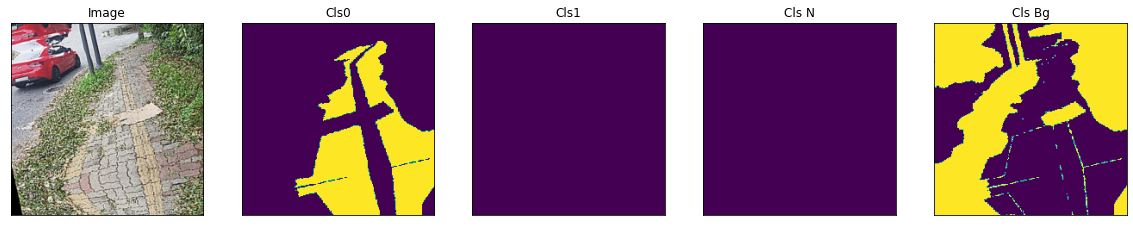

In [ ]:
XY_train_aug_resize_tfr_debug = AihubPedestrianDatasetTFRecord(
    DATASET_TFRECORD_DIR_PEDESTRIAN, 'train',
    interested_classes_name=INTERESTED_CLASSES_NAME, 
    augmentation=get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, DATASET_WIDTH, DATASET_HEIGHT, rectangle=RECTANGLE),
    resizing=get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN),
    preprocessing=None,
)
XY_train_aug_resize_tfr_debug.mode = 'tf.data.Dataset'

image, mask = next(iter(XY_train_aug_resize_tfr_debug.get_tf_dataset())) # get some sample
print('image : {} {} value range {}~{},\nmask : {} {} value range {}~{}'.format(image.numpy().shape, image.numpy().dtype, image.numpy().min(), image.numpy().max(), 
                                                                                mask.numpy().shape, mask.numpy().dtype, mask.numpy().min(), mask.numpy().max()))
DataPostProcessTools.visualize(
    image=image.numpy().astype('int'),
    cls0=mask[..., 0].numpy().squeeze(),
    cls1=mask[..., 1].numpy().squeeze(),
    cls_n=mask[..., -2].numpy().squeeze(),
    cls_bg=mask[..., -1].numpy().squeeze(),
)

mask tensor shape : (224, 224, 9), number of classes + background : 9
image input: 0~255 (dtype:int64, shape:(224, 224, 3))
mask input: 0.0~1.0 (dtype:float32, shape:(224, 224, 9))
4 x 4


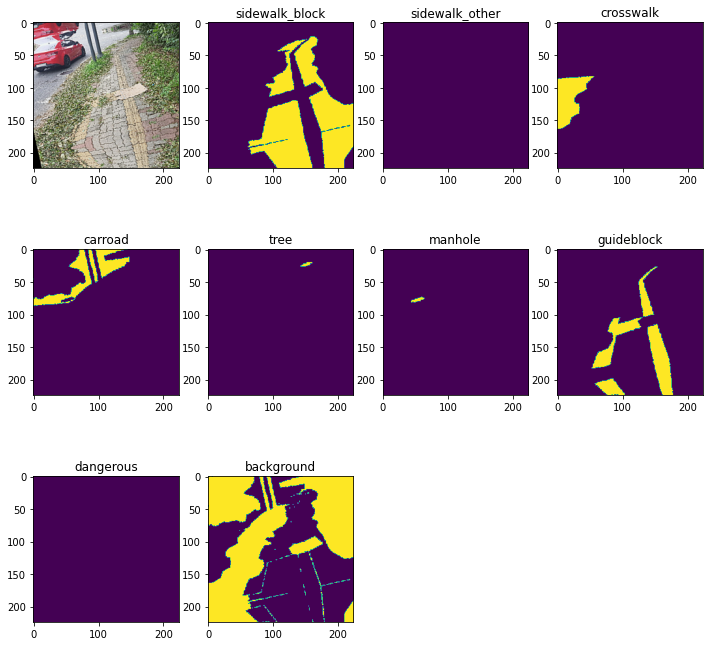

In [ ]:
DataPostProcessTools.visualize_v2(
    image=image.numpy().astype('int'),
    mask_tensor=mask.numpy(),
    label_li=INTERESTED_CLASSES_NAME
)

get_resizing: get pure tf function. (tpu compatible mode)
augmentation : <class 'albumentations.core.composition.Compose'> -> <class 'albumentations.core.composition.Compose'>
preprocessing : <class 'NoneType'> -> <class 'NoneType'>
resizing : <class 'function'> -> <class 'function'>
no preprocessing

[Important] Warning : augmetation not support on TPU Yet!
Pipeline will remove augmentation automatically.
(reason : tf.numpy_function not support for tpu.)
no augmentation.
Running with TFRecord.
_parse_rgb_mask_pure_fn: Tracing
_resizing_pure_fn: Tracing!
_preprocessing_pure_fn: Tracing!
_get_elsebranch_preprocessing: Tracing (no preprocessing)


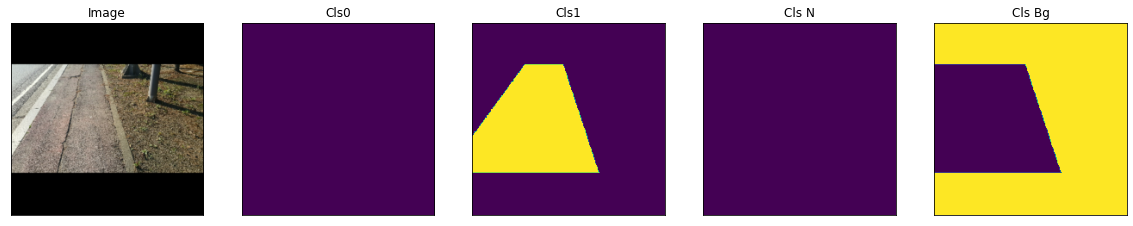

In [ ]:
XY_valid_aug_resize_tfr_debug = AihubPedestrianDatasetTFRecord(
    DATASET_TFRECORD_DIR_PEDESTRIAN, 'val',
    interested_classes_name=INTERESTED_CLASSES_NAME, 
    augmentation=get_validation_augmentation(DATASET_WIDTH, DATASET_HEIGHT, DATASET_WIDTH, DATASET_HEIGHT),
    resizing=get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN),
    preprocessing=None
)
XY_valid_aug_resize_tfr_debug.mode = 'tf.data.Dataset'
image, mask = next(iter(XY_valid_aug_resize_tfr_debug.get_tf_dataset())) # get some sample

DataPostProcessTools.visualize(
    image=image.numpy().astype('int'),
    cls0=mask[..., 0].numpy().squeeze(),
    cls1=mask[..., 1].numpy().squeeze(),
    cls_n=mask[..., -2].numpy().squeeze(),
    cls_bg=mask[..., -1].numpy().squeeze(),
)

mask tensor shape : (224, 224, 9), number of classes + background : 9
image input: 0~252 (dtype:int64, shape:(224, 224, 3))
mask input: 0.0~1.0 (dtype:float32, shape:(224, 224, 9))
4 x 4


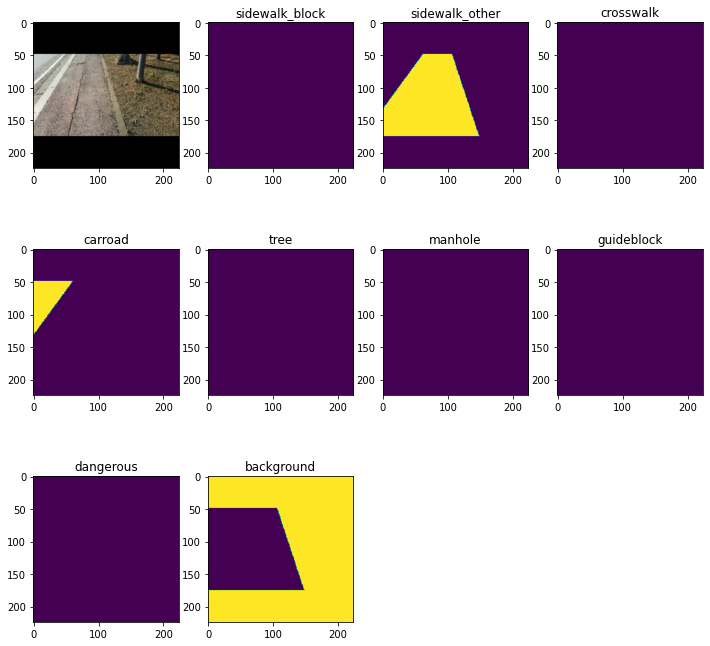

In [ ]:
DataPostProcessTools.visualize_v2(
    image=image.numpy().astype('int'),
    mask_tensor=mask.numpy(),
    label_li=INTERESTED_CLASSES_NAME
)

get_resizing: get pure tf function. (tpu compatible mode)
served_fn (<function preprocess_input at 0x7f7f9a8e4c20> 이 설정되었으나, TPU 에서 사용하지 못하는 경우가 많기 때문에 우선 제거합니다. 대신 이 함수의 주석을 참고하세요.
get_preprocessing: get pure tf function. (tpu compatible mode)
augmentation : <class 'albumentations.core.composition.Compose'> -> <class 'albumentations.core.composition.Compose'>
preprocessing : <class 'function'> -> <class 'function'>
resizing : <class 'function'> -> <class 'function'>

[Important] Warning : augmetation not support on TPU Yet!
Pipeline will remove augmentation automatically.
(reason : tf.numpy_function not support for tpu.)
no augmentation.
Running with TFRecord.
_parse_rgb_mask_pure_fn: Tracing
_resizing_pure_fn: Tracing!
_preprocessing_pure_fn: Tracing!
Preprocessing.preprocessing_pure_fn: Tracing!


  0%|          | 0/8 [00:00<?, ?it/s]

Only numpy variable could pass to _check_input_util function.
Convert (<class 'tensorflow.python.framework.ops.EagerTensor'>) to numpy automatically.
image from dataset: -1.0~1.0 (dtype:float32, shape:(224, 224, 3))
image after denorm: 0~255 (dtype:uint8, shape:(224, 224, 3))
image before visualization: 0~255 (dtype:uint8, shape:(224, 224, 3))
Only numpy variable could pass to _check_input_util function.
Convert (<class 'tensorflow.python.framework.ops.EagerTensor'>) to numpy automatically.
image from dataset: -1.0~1.0 (dtype:float32, shape:(224, 224, 3))
image after denorm: 0~255 (dtype:uint8, shape:(224, 224, 3))
image before visualization: 0~255 (dtype:uint8, shape:(224, 224, 3))
Only numpy variable could pass to _check_input_util function.
Convert (<class 'tensorflow.python.framework.ops.EagerTensor'>) to numpy automatically.
image from dataset: -1.0~1.0 (dtype:float32, shape:(224, 224, 3))
image after denorm: 0~255 (dtype:uint8, shape:(224, 224, 3))
image before visualization: 0~2

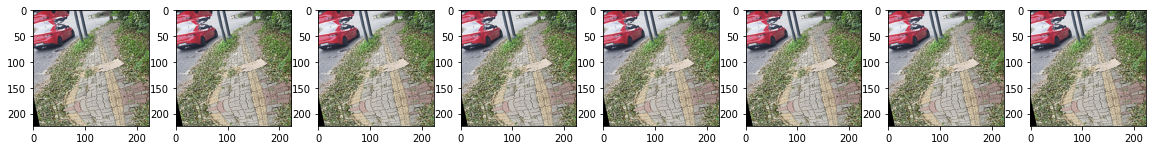

In [ ]:
XY_train_aug_resize_prep_tfr_debug = AihubPedestrianDatasetTFRecord(
    DATASET_TFRECORD_DIR_PEDESTRIAN, 'train',
    interested_classes_name=INTERESTED_CLASSES_NAME, 
    augmentation=get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, DATASET_WIDTH, DATASET_HEIGHT, rectangle=RECTANGLE),
    resizing=get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN),
    preprocessing=get_preprocessing(preprocess_input),
)
XY_train_aug_resize_prep_tfr_debug.mode = 'tf.data.Dataset'

DataPostProcessTools.visualize_for_qualitative(XY_train_aug_resize_prep_tfr_debug, denormalize=True, n=8)

#### [Extension] Check class imbalance (tf.data.Dataset)

In [ ]:
assert len(INTERESTED_CLASSES_NAME) > 1, 'binay segmentation ({} class) not support.'.format(len(INTERESTED_CLASSES_NAME))
dic = {} # clsid : count
print(INTERESTED_CLASSES_NAME+['nolabel'])

def init_dic(dic):
    global INTERESTED_CLASSES_NAME
    for i in range(len(INTERESTED_CLASSES_NAME)+1):
        dic[i] = 0

XY_train_tf.resizing = get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN)

init_dic(dic)
dataset = data_loader_tf(XY_train_tf.get_tf_dataset(), batch_size=1, buffer_size=1)
for im, mask in dataset.take(10):
    y = np.sum(mask.numpy().reshape(-1, len(INTERESTED_CLASSES_NAME)+1), axis=0).astype(np.int64)
    for k, v in enumerate(y):
        dic[k] += v

print('\n----- 10 data -----')
print(dic)
print(list(dic.keys()))
print(list(dic.values()))
fig, ax1 = plt.subplots(figsize=[2*(len(INTERESTED_CLASSES_NAME)+1),9])
ax1.set_ylabel('from 10 * batch size data', color='g')
plt.xticks(list(dic.keys()), INTERESTED_CLASSES_NAME+['background'], rotation=30)
ax1.plot(list(dic.keys()), list(dic.values()), color='g')
print('---------------')

# from 100 data
init_dic(dic)
#dataset = data_loader_tf(XY_train_tf.get_tf_dataset(), batch_size=1, buffer_size=1)
with tqdm(total=100, position=1) as pbar:
    for im, mask in dataset.take(100):
        y = np.sum(mask.numpy().reshape(-1, len(INTERESTED_CLASSES_NAME)+1), axis=0).astype(np.int64)
        for k, v in enumerate(y):
            dic[k] += v
        pbar.update(1)

print('\n----- 100 data -----')
print(dic)
print(list(dic.keys()))
print(list(dic.values()))
ax2 = ax1.twinx()
ax2.set_ylabel('from 100 * batch size data', color='r')
for i, j in zip(list(dic.keys()), list(dic.values())):
    ax2.annotate(str(j), xy=(i,j), color='r')
ax2.plot(list(dic.keys()), list(dic.values()), color='r')
print('---------------')

#### [Extension] Visualize Image that contains specific class

In [ ]:
def specific_class_visualizer(name_visualize_class, denormalize=False):
    assert name_visualize_class in INTERESTED_CLASSES_NAME, '{} is not interested class. One of {} supported'.format(name_visualize_class, INTERESTED_CLASSES_NAME)
    cid = INTERESTED_CLASSES_NAME.index(name_visualize_class)
    dataset = data_loader_tf(XY_train_tf.get_tf_dataset(), batch_size=1, buffer_size=1)

    stack = 0
    images = []
    masks = []
    cnt = 0
    for im, mask in dataset:
        cnt += 1
        init_dic(dic)
        y = np.sum(mask.numpy().reshape(-1, len(INTERESTED_CLASSES_NAME)+1), axis=0).astype(np.int64)
        for k, v in enumerate(y):
            dic[k] += v    
        if dic[cid] > 0:
            im_shape = im.numpy().squeeze().shape
            if dic[cid] == im_shape[0] * im_shape[1]:
                continue
            print('find it!', im_shape, dic[cid], 'pixels')
            images.append(im.numpy().squeeze())
            masks.append(mask.numpy().squeeze()[:,:,cid])
            stack+=1
        if stack == 2:
            break
        if cnt % 100 == 0:
            print('Searched from {} images.'.format(cnt))
        if cnt % 1000 == 0:
            print('Searched from 1000 images, but not found.')
            break

    if len(images) < 2:
       return

    if denormalize:
        images[0] = DataPostProcessTools.denormalize(images[0])
        images[1] = DataPostProcessTools.denormalize(images[1])

    DataPostProcessTools.visualize(
        im1=images[0],
        mask1=masks[0],
        im2=images[1],
        mask2=masks[1],
    )

In [ ]:
name_visualize_class = 'alley_normal' #@param {type:"string"}
specific_class_visualizer(name_visualize_class)

In [ ]:
name_visualize_class = 'caution_zone_repair_zone' #@param {type:"string"}
specific_class_visualizer(name_visualize_class)

In [ ]:
name_visualize_class = 'braille_guide_blocks_normal' #@param {type:"string"}
specific_class_visualizer(name_visualize_class)

In [ ]:
name_visualize_class = 'braille_guide_blocks_damaged' #@param {type:"string"}
specific_class_visualizer(name_visualize_class)

In [ ]:
name_visualize_class = 'bike_lane_normal' #@param {type:"string"}
specific_class_visualizer(name_visualize_class)

In [ ]:
name_visualize_class = 'sidewalk_urethane' #@param {type:"string"}
specific_class_visualizer(name_visualize_class)

In [ ]:
name_visualize_class = 'sidewalk_cement' #@param {type:"string"}
specific_class_visualizer(name_visualize_class)

In [ ]:
name_visualize_class = 'sidewalk_soil_stone' #@param {type:"string"}
specific_class_visualizer(name_visualize_class)

In [ ]:
name_visualize_class = 'sidewalk_asphalt' #@param {type:"string"}
specific_class_visualizer(name_visualize_class)

In [ ]:
name_visualize_class = 'sidewalk_other' #@param {type:"string"}
specific_class_visualizer(name_visualize_class)

In [ ]:
name_visualize_class = 'sidewalk_damaged' #@param {type:"string"}
specific_class_visualizer(name_visualize_class)

In [ ]:
name_visualize_class = 'caution_zone_stairs' #@param {type:"string"}
specific_class_visualizer(name_visualize_class, denormalize=True)

### Run UNet-BACKBONE

#### Train

- tip : ```.fit``` 에서 오류가 발생한다면 가장 놓치기 쉬운 부분이기도 한... input 의 size 가 32의 배수인지 확인해 보자.
- tip : ```get_resizing``` 을 사용하지 않는 경우, 모델이 동적 자료형으로 착각한다. ```shape=[h,w]``` 를 명시적으로 입력받지 않기 때문이다. 되도록이면 get_resizing 을 사용하고 모델을 돌리도록 하자.
- 만약 모델이 정상적으로 돌지 않았을때, 아래 체크 옵션들을 변경해 가면서 다시 시도하곤 할 것이다. 하지만 TensorFlow function 의 Tracing 은 항상 일어나지 않는다. 따라서 Dataset Specific utils 에 해당하는 셀들을 다시 실행해서, 데이터 로더 파이프라인을 다시 Tracing 시켜주도록 하자.
- load-and-run (callback_restore) 을 할때

In [ ]:
INIT_TENSORBOARD_LOG = False #@param {type: "boolean"}
INIT_KERAS_SESSION = True #@param {type: "boolean"}

GET_RESIZING = True #@param {type: "boolean"}
if USE_TPU:
    assert GET_RESIZING # FIXME
GET_AUGMENTATION = False #@param {type: "boolean"}
GET_PREPROCESSING = True #@param {type: "boolean"}

if PRETRAINED_WEIGHT == 'none':
    print('You did not set pretrained weight on your model.')
    print('if you train from scratch, preprocessing could be meaningless.')

You did not set pretrained weight on your model.
if you train from scratch, preprocessing could be meaningless.


In [ ]:
if INIT_TENSORBOARD_LOG:
    !rm -r {LOG_DIR_DATASETNAME_MODELINFO} #select model
if INIT_KERAS_SESSION:
    tf.keras.backend.clear_session()


if TRAINING_PARALLEL_STRATEGY is not None:
    assert USE_GCS, """All input files and the model directory must use a cloud storage bucket path (gs://bucket-name/...), \
    and this bucket must be accessible from the TPU server. \
    Note that all data processing and model checkpointing is performed on the TPU server, not the local machine. \
    For information on how to properly configure cloud storage for use with the TPU, see the guide Connecting to Cloud Storage Buckets."""
    # assume that training strategy is only set up with google colab TPU
    assert INPUT_PIPELINE == 'tf.data.Dataset', '{} does not support TPU strategy.'.format(INPUT_PIPELINE)
    pass

if INPUT_PIPELINE == 'tf.keras.Sequence':
    if GET_RESIZING:
        XY_train.resizing       = get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN)
    if GET_AUGMENTATION:
        XY_train.augmentation   = get_training_augmentation(dataset_w=DATASET_WIDTH, 
                                                            dataset_h=DATASET_HEIGHT,
                                                            cropped_augmented_image_return_w=DATASET_WIDTH,
                                                            cropped_augmented_image_return_h=DATASET_HEIGHT,
                                                            rectangle=RECTANGLE)
    if GET_PREPROCESSING:
        XY_train.preprocessing  = get_preprocessing(preprocess_input) # 사전학습 모델에 맞는 전처리방법을 선택
        
    if GET_RESIZING:
        XY_valid.resizing       = get_resizing(MODEL_INPUT_WIDTH_FOR_VALID, MODEL_INPUT_HEIGHT_FOR_VALID)
    if GET_AUGMENTATION:
        XY_valid.augmentation   = get_validation_augmentation(dataset_w=DATASET_WIDTH,
                                                              dataset_h=DATASET_HEIGHT,
                                                              cropped_augmented_image_return_w=DATASET_WIDTH,
                                                              cropped_augmented_image_return_h=DATASET_HEIGHT)
    if GET_PREPROCESSING:
        XY_valid.preprocessing  = get_preprocessing(preprocess_input) # 사전학습 모델에 맞는 전처리방법을 선택

elif INPUT_PIPELINE == 'tf.data.Dataset':
    if USE_TFRECORD:
        XY_train_tf = XY_train_tfr
        XY_valid_tf = XY_valid_tfr
        XY_test_tf = XY_test_tfr

    if GET_RESIZING:
        XY_train_tf.resizing      = get_resizing(MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN)
    if GET_AUGMENTATION:
        XY_train_tf.augmentation  = get_training_augmentation(dataset_w=DATASET_WIDTH, 
                                                              dataset_h=DATASET_HEIGHT,
                                                              cropped_augmented_image_return_w=DATASET_WIDTH,
                                                              cropped_augmented_image_return_h=DATASET_HEIGHT,
                                                              rectangle=RECTANGLE)
    if GET_PREPROCESSING:
        XY_train_tf.preprocessing = get_preprocessing(preprocess_input) # 사전학습 모델에 맞는 전처리방법을 선택

    if GET_RESIZING:
        XY_valid_tf.resizing      = get_resizing(MODEL_INPUT_WIDTH_FOR_VALID, MODEL_INPUT_HEIGHT_FOR_VALID)
    if GET_AUGMENTATION:
        XY_valid_tf.augmentation  = get_validation_augmentation(dataset_w=DATASET_WIDTH,
                                                                dataset_h=DATASET_HEIGHT,
                                                                cropped_augmented_image_return_w=DATASET_WIDTH,
                                                                cropped_augmented_image_return_h=DATASET_HEIGHT)
    if GET_PREPROCESSING:
        XY_valid_tf.preprocessing = get_preprocessing(preprocess_input) # 사전학습 모델에 맞는 전처리방법을 선택

    XY_train_tf.mode = 'tf.data.Dataset'
    XY_valid_tf.mode = 'tf.data.Dataset'

else:
    raise NotImplementedError

if INPUT_PIPELINE == 'tf.keras.Sequence':
    train_dataloader = DataLoader(XY_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(XY_valid, batch_size=VALID_BATCH_SIZE, shuffle=True)
    assert train_dataloader[0][0].shape == (TRAIN_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, 3)
    assert train_dataloader[0][1].shape == (TRAIN_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, N_CLASSES)
    assert valid_dataloader[0][0].shape == (VALID_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, 3)
    assert valid_dataloader[0][1].shape == (VALID_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, N_CLASSES)

elif INPUT_PIPELINE == 'tf.data.Dataset':
    train_dataloader = data_loader_tf(XY_train_tf.get_tf_dataset(), batch_size=TRAIN_BATCH_SIZE)
    valid_dataloader = data_loader_tf(XY_valid_tf.get_tf_dataset(), batch_size=VALID_BATCH_SIZE)
    if TRAINING_PARALLEL_STRATEGY is not None:
        pass
    else:
        assert next(iter(train_dataloader))[0].shape == (TRAIN_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, 3), '{} (desired {})'.format(next(iter(train_dataloader))[0].shape, (TRAIN_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, 3))
        assert next(iter(train_dataloader))[1].shape == (TRAIN_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, N_CLASSES)
        assert next(iter(valid_dataloader))[0].shape == (VALID_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, 3)
        assert next(iter(valid_dataloader))[1].shape == (VALID_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, N_CLASSES)
else:
    print('{} is not support'.format(INPUT_PIPELINE))
    raise NotImplemendedError

if TRAINING_PARALLEL_STRATEGY is None:
    #tf.summary function unstable. Do not use this function when you run on TPU
    #later, wrap with @tf.function instead. See tf.summary documentation.
    image_writer = tf.summary.create_file_writer(os.path.join(LOG_DIR_DATASETNAME_MODELINFO, 'image_ex')) #select model
    mask_writer = tf.summary.create_file_writer(os.path.join(LOG_DIR_DATASETNAME_MODELINFO, 'mask_ex')) #select model
    with image_writer.as_default():
        if INPUT_PIPELINE == 'tf.keras.Sequence':
            images = train_dataloader[0][0]
        elif INPUT_PIPELINE == 'tf.data.Dataset':
            images = next(iter(train_dataloader))[0]
        else:
            raise NotImplementedError

        if GET_PREPROCESSING:
            tf.summary.image("One batch image", DataPostProcessTools.denormalize(images), max_outputs=TRAIN_BATCH_SIZE, step=0)
        else:
            tf.summary.image("One batch image", images, max_outputs=TRAIN_BATCH_SIZE, step=0)

    with mask_writer.as_default():
        if INPUT_PIPELINE == 'tf.keras.Sequence':
            masks = train_dataloader[0][1] # get 1 mask
        elif INPUT_PIPELINE == 'tf.data.Dataset':
            masks = next(iter(train_dataloader))[1][0,:,:,:] # get 1 mask
        else:
            raise NotImplementedError
        tf.summary.image("One batch mask", 
                          tf.reshape(masks, [N_CLASSES, 
                                             MODEL_INPUT_HEIGHT_FOR_TRAIN, 
                                             MODEL_INPUT_WIDTH_FOR_TRAIN, 1]), 
                          #max_outputs=TRAIN_BATCH_SIZE, 
                          step=0)


callback_tboard = tf.keras.callbacks.TensorBoard(
    log_dir=LOG_DIR_DATASETNAME_MODELINFO, #select model
    histogram_freq=1, write_graph=False, 
    #write_graph=True option unstable. Do not use option especially when you run on TPU
    write_images=True, update_freq=TBOARD_HISTOGRAM_LOG_UPDATE_FREQ, profile_batch=1,
    #profile_batch does not work on tf 2.5 or tensorboard latest version. Maybe we should wait for bugfix :)
    embeddings_freq=0, embeddings_metadata=None
)
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(WEIGHTS_DIR_DATASETNAME_MODELINFO,'epoch-{epoch:02d}-valloss-{val_loss:.2f}'), #select model
    save_weights_only=True, save_best_only=True, mode='min', verbose=1 #save weights True
)
callback_lrtuner = tf.keras.callbacks.ReduceLROnPlateau()

import time
class InterruptForColabTimeout(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.first_epoch_time     = None
        self.this_epoch_time      = None
        self.train_starting_time  = time.time()
        self.since_training_start = None
        self.first_epoch          = True
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
        if not self.first_epoch: # 첫 에폭은 보통 평소와 다르게 엄청 오래 걸리니까.
            if self.since_training_start + self.this_epoch_time < 1*60*60*20: # 19 hour
                # 다음 epoch 까지 돌릴 시간이 확보된다면
                pass
            else:
                # 다음 epoch 까지 돌릴 시간이 확보되지 않는다면
                raise TimeoutError('COLAB Time pre-interrupt.')
    def on_epoch_end(self, epoch, logs={}):
        self.since_training_start = time.time() - self.train_starting_time
        self.this_epoch_time      = time.time() - self.epoch_time_start
        self.first_epoch          = False

callback_colabtout = InterruptForColabTimeout()
callback_restore = tf.keras.callbacks.experimental.BackupAndRestore(BACKUP_DIR_DATASETNAME_MODELINFO)

if TRAINING_PARALLEL_STRATEGY is not None:
    with TRAINING_PARALLEL_STRATEGY.scope():        
        model = Arch(BACKBONE, 
                     #input_shape=(MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, 3),
                     classes=N_CLASSES,
                     activation='softmax',
                     encoder_weights= PRETRAINED_WEIGHT if PRETRAINED_WEIGHT in ['imagenet'] else None,
                     encoder_freeze=False)
        model.compile(OPTIMIZER, LOSS_SET, METRICS_SET)
else:
    model = Arch(BACKBONE, 
                 classes=N_CLASSES, 
                 activation='softmax',
                 encoder_weights= PRETRAINED_WEIGHT if PRETRAINED_WEIGHT in ['imagenet'] else None,
                 encoder_freeze=False)
    model.compile(OPTIMIZER, LOSS_SET, METRICS_SET)

if not USE_GCS:
    f = os.path.join(MODEL_PLOT_DIR, '{}-{}.jpg'.format(ARCHITECTURE, BACKBONE)) #select model
    tf.keras.utils.plot_model(model, to_file=f, show_shapes=True, show_layer_names=True)

model.summary()

if INPUT_PIPELINE == 'tf.keras.Sequence':
    TRAIN_STEPS_PER_EPOCH = len(train_dataloader)
    VALID_STEPS_PER_EPOCH = len(valid_dataloader)
elif INPUT_PIPELINE == 'tf.data.Dataset':
    import math
    TRAIN_STEPS_PER_EPOCH = math.floor(len(XY_train_tf) // TRAIN_BATCH_SIZE)
    VALID_STEPS_PER_EPOCH = math.floor(len(XY_valid_tf) // VALID_BATCH_SIZE)
else:
    raise NotImplementedError

print('training steps per epoch : {}\nvalidation steps per epoch : {}'.format(TRAIN_STEPS_PER_EPOCH, VALID_STEPS_PER_EPOCH))
model.fit(train_dataloader,
          validation_data=valid_dataloader,
          steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
          validation_steps=VALID_STEPS_PER_EPOCH,
          epochs=N_EPOCH,
          callbacks=[callback_tboard, callback_bestmodel, callback_lrtuner, callback_colabtout, callback_restore],
          verbose=1
          )

get_resizing: get pure tf function. (tpu compatible mode)
served_fn (<function preprocess_input at 0x7fd72f2947a0> 이 설정되었으나, TPU 에서 사용하지 못하는 경우가 많기 때문에 우선 제거합니다. 대신 이 함수의 주석을 참고하세요.
get_preprocessing: get pure tf function. (tpu compatible mode)
get_resizing: get pure tf function. (tpu compatible mode)
served_fn (<function preprocess_input at 0x7fd72f2947a0> 이 설정되었으나, TPU 에서 사용하지 못하는 경우가 많기 때문에 우선 제거합니다. 대신 이 함수의 주석을 참고하세요.
get_preprocessing: get pure tf function. (tpu compatible mode)
no augmentation
Running with TFRecord.
_parse_rgb_mask_pure_fn: Tracing
_resizing_pure_fn: Tracing!
_preprocessing_pure_fn: Tracing!
Preprocessing.preprocessing_pure_fn: Tracing!
no augmentation
Running with TFRecord.
_parse_rgb_mask_pure_fn: Tracing
_resizing_pure_fn: Tracing!
_preprocessing_pure_fn: Tracing!
Preprocessing.preprocessing_pure_fn: Tracing!
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output

Instructions for updating:
use `experimental_local_results` instead.


   6/1930 [..............................] - ETA: 22:10 - loss: 0.2530 - iou_score: 0.7156 - f1-score: 0.7748 - categorical_acc: 0.9533WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0069s vs `on_train_batch_end` time: 8.3623s). Check your callbacks.


1930/1930 [==============================] - ETA: 0s - loss: 0.2679 - iou_score: 0.7044 - f1-score: 0.7640 - categorical_acc: 0.9427
Epoch 00130: val_loss improved from inf to 0.32650, saving model to gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/weights/PEDESTRIAN/SURFACE_MASKING/FPN_EFFICIENTNETB0/b96_9c_288_384_tpu_tfrecord_gcs_nodice/epoch-130-valloss-0.33
1930/1930 [==============================] - 1510s 746ms/step - loss: 0.2679 - iou_score: 0.7044 - f1-score: 0.7640 - categorical_acc: 0.9427 - val_loss: 0.3265 - val_iou_score: 0.6715 - val_f1-score: 0.7354 - val_categorical_acc: 0.9394 - lr: 1.0000e-07
Epoch 131/150
1930/1930 [==============================] - ETA: 0s - loss: 0.2675 - iou_score: 0.7041 - f1-score: 0.7640 - categorical_acc: 0.9427
Epoch 00131: val_loss improved from 0.32650 to 0.32443, saving model to gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/weights/PEDESTRIAN/SURFACE_MASKING/FPN_EFFICIENTNETB0/b96_9c_288_38